# Our imports:

In [1]:
import shap
import lime
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from imageio import imread
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from lime import lime_image, submodular_pick
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2


# just to ignore some unnecessary and annoying warnings like deprecations and all:
warnings.filterwarnings('ignore')

# taken from https://www.youtube.com/watch?v=Z2kfLs2Dwqw&ab_channel=bsaldivar%3ADatascience
shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough

C:\Program Files\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1 - Part (b):

In [2]:
# load the dataset:
df = pd.read_csv('Life Expectancy Data.csv')

print(df.head())
print(f'{df.columns = }\n')
print(f'{df.shape = }\n')

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

make a new feature called continents:

inspired by https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry



In [3]:
def convert_to_common_names(country):
    # since, "pycountry_convert" package couldn't recognize which continent this country is in:
    if country == 'Timor-Leste':
        return 'Asia'
    else:
        return continents[(country_alpha2_to_continent_code(country_name_to_country_alpha2(country)))]

In [4]:
# names of some countries have parentheses, like: "Bolivia (Plurinational State of)", "Iran (Islamic Republic of)"...
# ...we have to remove them:
df['Country'] = df['Country'].str.replace(r' \(.*\)', '')

# modernizing or converting some country names to their common form:
df['Country'] = df['Country'].str.replace('Republic of Korea', 'South Korea')
df['Country'] = df['Country'].str.replace('Democratic People\'s South Korea', 'South Korea')
df['Country'] = df['Country'].str.replace('The former Yugoslav republic of Macedonia', 'North Macedonia')

In [5]:
continents = {'NA': 'North America', 'SA': 'South America', 'AS': 'Asia', 'OC': 'Australia', 'AF': 'Africa', 'EU': 'Europe'}

# applying a function on the dataframe to create a new column called "Continent":
# we use apply method since it is much faster than for-loop.
df['Continent'] = df['Country'].apply(lambda x: convert_to_common_names(x))

print(df[['Country', 'Continent']])

          Country Continent
0     Afghanistan      Asia
1     Afghanistan      Asia
2     Afghanistan      Asia
3     Afghanistan      Asia
4     Afghanistan      Asia
...           ...       ...
2933     Zimbabwe    Africa
2934     Zimbabwe    Africa
2935     Zimbabwe    Africa
2936     Zimbabwe    Africa
2937     Zimbabwe    Africa

[2938 rows x 2 columns]


replace the null or missing values with mean values of the feature:

taken from: https://www.kaggle.com/code/varunsaikanuri/life-expectancy-visualization

In [6]:
print('Before imputing missing values:\n', df.isnull().sum())

Before imputing missing values:
 Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
Continent                            0
dtype: int64


In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)

df['Life expectancy '] = imputer.fit_transform(df[['Life expectancy ']])
df['GDP'] = imputer.fit_transform(df[['GDP']])
df['Population'] = imputer.fit_transform(df[['Population']])
df['Adult Mortality'] = imputer.fit_transform(df[['Adult Mortality']])
df['Alcohol'] = imputer.fit_transform(df[['Alcohol']])
df['Hepatitis B'] = imputer.fit_transform(df[['Hepatitis B']])
df[' BMI '] = imputer.fit_transform(df[[' BMI ']])
df['Polio'] = imputer.fit_transform(df[['Polio']])
df['Total expenditure'] = imputer.fit_transform(df[['Total expenditure']])
df['Diphtheria '] = imputer.fit_transform(df[['Diphtheria ']])
df[' thinness  1-19 years'] = imputer.fit_transform(df[[' thinness  1-19 years']])
df[' thinness 5-9 years'] = imputer.fit_transform(df[[' thinness 5-9 years']])
df['Income composition of resources'] = imputer.fit_transform(df[['Income composition of resources']])
df['Schooling'] = imputer.fit_transform(df[['Schooling']])

In [8]:
print('After imputing missing values:\n', df.isnull().sum())

After imputing missing values:
 Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Continent                          0
dtype: int64


removing this feature since it has negative effect on training...

we actually compared the accuracy scores and saw that, this feature is better to be removed.

but since the question asks us to observe SHAP values on all features, we don't remove this feature.

In [9]:
#df.drop('Year', inplace=True, axis=1)

splitting the data into x and y:

In [10]:
x = df.drop('Life expectancy ', axis=1)
y = df[['Life expectancy ']]

split the data into training and testing sets, stratifying on the 'Continent' feature

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=df['Continent'], random_state=42)

iterate over the continents present in the testing data:

we want to make sure that we have at least 3 unique countries from each continent in test data

In [12]:
for continent in x_test['Continent'].unique():
    # get a list of all countries in the testing data for this continent:
    countries = x_test[x_test['Continent'] == continent]['Country'].unique()

    # ensure that there are at least 3 unique countries in the testing data for this continent:
    # if it throws an error, it means there are not at least 3 unique countries in each continent.
    assert len(countries) >= 3, f'At least 3 unique countries from {continent} must be in the testing data'

in order to solve last part, we have to have indices of datapoints for each continent. we will take two datapoints for each continent.

later, we will use these indices to produce new array and solve the last paragraph of this section of the question. the reason for doing so is that since we do standardization, scaling and such, there's no way of telling which datapoint belongs to which continent.

In [13]:
# the key is the name of the continents and the value for each key is a list containing indices...
# ...of the countries belonging to that cotinent.
continents_indices_for_df = {value: [] for _, value in continents.items()}
continents_indices_for_x_test = {value: [] for _, value in continents.items()}

In [14]:
while True:
    # from each continent we take two samples:
    new_df = x_test.groupby('Continent').apply(lambda x: x.sample(n=2))#.reset_index(drop=True)

    # we have to make sure that these two samples are from different countries:
    if len(new_df['Country'].unique()) == 2 * len(continents_indices_for_df.keys()):
        print(new_df)

        # we just simply take indices from each continent and assign it to our dictionary:
        # i know that the codes do actually intimidating, but they are actually working.
        # the point is, for "continents_indices_for_df" i have to have the original index...
        # ...from the original dataset, df, so that i can access country name...
        # ...and as for "continents_indices_for_x_test", i need the reset (past tense) index of this...
        # ...array so that i can actually use the contents correctly to plot the SHAP values.
        for continent in new_df['Continent'].unique():
            continents_indices_for_df[continent] = [int(item[1]) for item in new_df[new_df['Continent'] == continent].index.values]
            continents_indices_for_x_test[continent] = [int(x_test.reset_index()[x_test.reset_index()['index'] == int(item[1])].index.values) for item in new_df[new_df['Continent'] == continent].index.values]

        break

                            Country  Year      Status  Adult Mortality  \
Continent                                                                
Africa        1367            Kenya  2010  Developing       294.000000   
              1509            Libya  2012  Developing       133.000000   
Asia          194        Bangladesh  2013  Developing       135.000000   
              2         Afghanistan  2013  Developing       268.000000   
Australia     2847          Vanuatu  2010  Developing       145.000000   
              2363  Solomon Islands  2013  Developing       182.000000   
Europe        2354         Slovenia  2006   Developed        17.000000   
              1742       Montenegro  2005  Developing       133.000000   
North America 769          Dominica  2013  Developing       164.796448   
              217          Barbados  2006  Developing       115.000000   
South America 2480         Suriname  2008  Developing       196.000000   
              789           Ecuador  2

In [15]:
print('Continents indices for original df:\n', continents_indices_for_df)
print('\n')
print('Continents indices for test df:\n', continents_indices_for_x_test)

Continents indices for original df:
 {'North America': [769, 217], 'South America': [2480, 789], 'Asia': [194, 2], 'Australia': [2847, 2363], 'Africa': [1367, 1509], 'Europe': [2354, 1742]}


Continents indices for test df:
 {'North America': [280, 113], 'South America': [220, 205], 'Asia': [236, 165], 'Australia': [23, 59], 'Africa': [266, 6], 'Europe': [201, 276]}


to prove that items from x_test and df with their own indices point to actually same datapoint. i pick randomly, you are free to try it for yourself. you won't see "Life expectancy" column in x_test:

In [16]:
print('From original df:\n', df.iloc[continents_indices_for_df['Asia'][0]])
print('\nFrom test df:\n', x_test.iloc[continents_indices_for_x_test['Asia'][0]])

From original df:
 Country                             Bangladesh
Year                                      2013
Status                              Developing
Life expectancy                           71.0
Adult Mortality                          135.0
infant deaths                              104
Alcohol                                   0.01
percentage expenditure               52.829865
Hepatitis B                               96.0
Measles                                    237
 BMI                                      17.0
under-five deaths                          130
Polio                                     96.0
Total expenditure                         2.88
Diphtheria                                96.0
 HIV/AIDS                                  0.1
GDP                                 951.889453
Population                         157571292.0
 thinness  1-19 years                     18.3
 thinness 5-9 years                       18.8
Income composition of resources          

removing Continent feature after we're done with it:

In [17]:
x_train.drop('Continent', inplace=True, axis=1)
x_test.drop('Continent', inplace=True, axis=1)

turning text strings into categorical values:

In [18]:
l_encoder= preprocessing.LabelEncoder()
x_train.loc[:, 'Status'] = l_encoder.fit_transform(x_train.loc[:, 'Status'])

l_encoder= preprocessing.LabelEncoder()
x_test.loc[:, 'Status'] = l_encoder.fit_transform(x_test.loc[:, 'Status'])

l_encoder= preprocessing.LabelEncoder()
x_train.loc[:, 'Country'] = l_encoder.fit_transform(x_train.loc[:, 'Country'])

l_encoder= preprocessing.LabelEncoder()
x_test.loc[:, 'Country'] = l_encoder.fit_transform(x_test.loc[:, 'Country'])

In [19]:
'''
# standardizing and scaling the train and test data:
# inspired by https://github.com/BatuhanSeremet/Life_Expectancy-Regression/blob/main/Reg_Life_Expectancy.ipynb
scaler = preprocessing.StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
''';

MinMax scaling the train and test data:

inspired by https://www.kaggle.com/code/mohamedsalemmohamed/life-expectancy-prediction-with-nn

In [20]:
scaler = preprocessing.MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

to convert our data to proper numpy arrays for later classification:

In [21]:
x_train = np.asarray(x_train).astype(np.float64)
y_train = np.asarray(y_train).astype(np.float64)
x_test = np.asarray(x_test).astype(np.float64)
y_test = np.asarray(y_test).astype(np.float64)

In [22]:
print(f'{x_train.shape = }')
print(f'{y_train.shape = }')
print(f'{x_test.shape = }')
print(f'{y_test.shape = }')

x_train.shape = (2644, 21)
y_train.shape = (2644, 1)
x_test.shape = (294, 21)
y_test.shape = (294, 1)


# this is the run we got error by using SELU activation function

we are building the architecture of our model. we use Model and Functional API:

In [23]:
inputs = tf.keras.layers.Input(shape=x_train.shape[1])

features = tf.keras.layers.Dense(32)(inputs)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(64)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(128)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(256)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(512)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(1024)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(512)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(256)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(128)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(64)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.15)(features)

features = tf.keras.layers.Dense(32)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.activations.selu(features)
#features = tf.keras.layers.Dropout(0.1)(features)

outputs = tf.keras.layers.Dense(1, activation='linear')(features)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

to see the architecture and the layers of our model:

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 32)                704       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 tf.nn.selu (TFOpLambda)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

compile the model:

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

train the model:

In [26]:
history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_split=0.1)

Epoch 1/200
38/38 [==============================] - 5s 32ms/step - loss: 4758.3442 - val_loss: 3790.8330
Epoch 2/200
38/38 [==============================] - 1s 28ms/step - loss: 4637.5435 - val_loss: 4123.2158
Epoch 3/200
38/38 [==============================] - 1s 25ms/step - loss: 4518.6582 - val_loss: 3992.2368
Epoch 4/200
38/38 [==============================] - 1s 22ms/step - loss: 4380.8960 - val_loss: 3930.4331
Epoch 5/200
38/38 [==============================] - 1s 26ms/step - loss: 4209.5322 - val_loss: 3750.8716
Epoch 6/200
38/38 [==============================] - 1s 23ms/step - loss: 4019.8376 - val_loss: 3929.0432
Epoch 7/200
38/38 [==============================] - 1s 21ms/step - loss: 3831.7273 - val_loss: 3917.3445
Epoch 8/200
38/38 [==============================] - 1s 21ms/step - loss: 3590.0244 - val_loss: 3293.6506
Epoch 9/200
38/38 [==============================] - 1s 21ms/step - loss: 3344.5271 - val_loss: 3020.8350
Epoch 10/200
38/38 [==========================

Epoch 80/200
38/38 [==============================] - 1s 27ms/step - loss: 7.5147 - val_loss: 9.5933
Epoch 81/200
38/38 [==============================] - 1s 26ms/step - loss: 8.3071 - val_loss: 9.8267
Epoch 82/200
38/38 [==============================] - 1s 26ms/step - loss: 9.1814 - val_loss: 9.2420
Epoch 83/200
38/38 [==============================] - 1s 26ms/step - loss: 8.1974 - val_loss: 15.0229
Epoch 84/200
38/38 [==============================] - 1s 27ms/step - loss: 7.5650 - val_loss: 9.5258
Epoch 85/200
38/38 [==============================] - 1s 26ms/step - loss: 8.0394 - val_loss: 9.4028
Epoch 86/200
38/38 [==============================] - 1s 26ms/step - loss: 7.7087 - val_loss: 9.1301
Epoch 87/200
38/38 [==============================] - 1s 27ms/step - loss: 7.9730 - val_loss: 8.4735
Epoch 88/200
38/38 [==============================] - 1s 26ms/step - loss: 7.6558 - val_loss: 8.2681
Epoch 89/200
38/38 [==============================] - 1s 26ms/step - loss: 7.4447 - val_lo

plot the training progress:

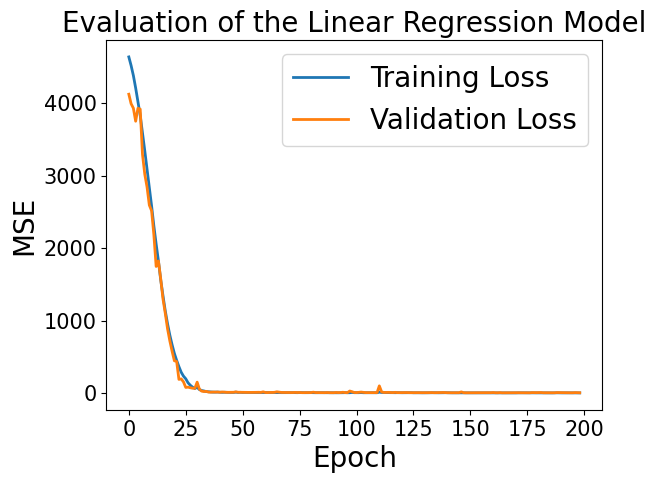

In [27]:
plt.plot(history.history['loss'][1:], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'][1:], label='Validation Loss', linewidth=2)
plt.title('Evaluation of the Linear Regression Model', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

evaluate the model on test-set:

In [28]:
model.evaluate(x=x_test, y=y_test)

10/10 [==============================] - 0s 11ms/step - loss: 5.6498


5.649839878082275

#### now onto SHAP values:

first, kernelshap method:

since we don't have the enough processing power to process all train-set data, we just take 500 datapoints from it.

inspired by https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

In [29]:
#background = shap.kmeans(x_train, 500)
background = x_train[np.random.choice(x_train.shape[0], 500, replace=False)]

16/16 [==============================] - 1s 21ms/step


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|                                                                                                                    | 0/294 [00:00<?, ?it/s]

32657/32657 [==============================] - 187s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  0%|▎                                                                                                       | 1/294 [03:15<15:54:42, 195.50s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  1%|▋                                                                                                       | 2/294 [06:04<14:35:57, 179.99s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  1%|█                                                                                                       | 3/294 [08:46<13:53:41, 171.89s/it]

32657/32657 [==============================] - 164s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  1%|█▍                                                                                                      | 4/294 [11:38<13:49:37, 171.65s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|█▊                                                                                                      | 5/294 [14:22<13:34:19, 169.06s/it]

32657/32657 [==============================] - 166s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|██                                                                                                      | 6/294 [17:14<13:36:49, 170.17s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|██▍                                                                                                     | 7/294 [19:59<13:25:23, 168.38s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|██▊                                                                                                     | 8/294 [22:42<13:14:27, 166.67s/it]

32657/32657 [==============================] - 165s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|███▏                                                                                                    | 9/294 [25:34<13:19:44, 168.37s/it]

32657/32657 [==============================] - 174s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|███▌                                                                                                   | 10/294 [28:35<13:35:39, 172.32s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  4%|███▊                                                                                                   | 11/294 [31:33<13:40:01, 173.86s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  4%|████▏                                                                                                  | 12/294 [34:30<13:41:24, 174.77s/it]

32657/32657 [==============================] - 174s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  4%|████▌                                                                                                  | 13/294 [37:31<13:48:01, 176.80s/it]

32657/32657 [==============================] - 175s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  5%|████▉                                                                                                  | 14/294 [40:33<13:52:45, 178.45s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  5%|█████▎                                                                                                 | 15/294 [43:23<13:36:45, 175.65s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  5%|█████▌                                                                                                 | 16/294 [46:05<13:15:35, 171.71s/it]

32657/32657 [==============================] - 175s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  6%|█████▉                                                                                                 | 17/294 [49:07<13:26:57, 174.79s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  6%|██████▎                                                                                                | 18/294 [51:51<13:09:01, 171.53s/it]

32657/32657 [==============================] - 171s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  6%|██████▋                                                                                                | 19/294 [54:49<13:15:10, 173.49s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  7%|███████                                                                                                | 20/294 [57:38<13:06:23, 172.20s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  7%|███████▏                                                                                             | 21/294 [1:00:13<12:39:23, 166.90s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  7%|███████▌                                                                                             | 22/294 [1:02:49<12:21:39, 163.60s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  8%|███████▉                                                                                             | 23/294 [1:05:31<12:16:34, 163.08s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  8%|████████▏                                                                                            | 24/294 [1:08:21<12:23:31, 165.23s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  9%|████████▌                                                                                            | 25/294 [1:11:07<12:21:50, 165.47s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  9%|████████▉                                                                                            | 26/294 [1:13:48<12:12:49, 164.07s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  9%|█████████▎                                                                                           | 27/294 [1:16:29<12:06:43, 163.31s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 10%|█████████▌                                                                                           | 28/294 [1:19:16<12:08:11, 164.25s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 10%|█████████▉                                                                                           | 29/294 [1:21:57<12:01:33, 163.37s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 10%|██████████▎                                                                                          | 30/294 [1:24:38<11:55:37, 162.64s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 11%|██████████▋                                                                                          | 31/294 [1:27:16<11:47:19, 161.37s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 11%|██████████▉                                                                                          | 32/294 [1:29:51<11:36:05, 159.41s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 11%|███████████▎                                                                                         | 33/294 [1:32:27<11:29:03, 158.41s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 12%|███████████▋                                                                                         | 34/294 [1:35:02<11:21:58, 157.38s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 12%|████████████                                                                                         | 35/294 [1:37:36<11:15:15, 156.43s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 12%|████████████▎                                                                                        | 36/294 [1:40:11<11:10:49, 156.00s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 13%|████████████▋                                                                                        | 37/294 [1:42:46<11:06:33, 155.62s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 13%|█████████████                                                                                        | 38/294 [1:45:22<11:04:30, 155.74s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 13%|█████████████▍                                                                                       | 39/294 [1:47:59<11:03:11, 156.04s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 14%|█████████████▋                                                                                       | 40/294 [1:51:24<12:02:21, 170.63s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 14%|██████████████                                                                                       | 41/294 [1:53:58<11:38:42, 165.70s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 14%|██████████████▍                                                                                      | 42/294 [1:56:33<11:23:15, 162.68s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 15%|██████████████▊                                                                                      | 43/294 [1:59:08<11:10:09, 160.20s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 15%|███████████████                                                                                      | 44/294 [2:01:42<11:00:03, 158.42s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 15%|███████████████▍                                                                                     | 45/294 [2:04:17<10:52:58, 157.35s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 16%|███████████████▊                                                                                     | 46/294 [2:06:51<10:46:50, 156.49s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 16%|████████████████▏                                                                                    | 47/294 [2:09:27<10:42:48, 156.15s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 16%|████████████████▍                                                                                    | 48/294 [2:12:02<10:38:36, 155.76s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 17%|████████████████▊                                                                                    | 49/294 [2:14:37<10:35:21, 155.60s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 17%|█████████████████▏                                                                                   | 50/294 [2:17:14<10:34:09, 155.94s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 17%|█████████████████▌                                                                                   | 51/294 [2:19:50<10:31:52, 156.02s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 18%|█████████████████▊                                                                                   | 52/294 [2:22:25<10:27:55, 155.68s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 18%|██████████████████▏                                                                                  | 53/294 [2:25:00<10:25:25, 155.71s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 18%|██████████████████▌                                                                                  | 54/294 [2:27:35<10:21:25, 155.36s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 19%|██████████████████▉                                                                                  | 55/294 [2:30:09<10:17:38, 155.06s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 19%|███████████████████▏                                                                                 | 56/294 [2:32:44<10:14:13, 154.85s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 19%|███████████████████▌                                                                                 | 57/294 [2:35:18<10:10:34, 154.58s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 20%|███████████████████▉                                                                                 | 58/294 [2:37:55<10:10:50, 155.30s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 20%|████████████████████▎                                                                                | 59/294 [2:40:30<10:07:53, 155.21s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 20%|████████████████████▌                                                                                | 60/294 [2:43:04<10:04:39, 155.04s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 21%|████████████████████▉                                                                                | 61/294 [2:45:39<10:02:18, 155.10s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 21%|█████████████████████▌                                                                                | 62/294 [2:48:14<9:59:02, 154.93s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 21%|█████████████████████▊                                                                                | 63/294 [2:50:49<9:56:01, 154.81s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 22%|██████████████████████▏                                                                               | 64/294 [2:53:23<9:53:10, 154.74s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 22%|██████████████████████▌                                                                               | 65/294 [2:55:59<9:52:28, 155.23s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 22%|██████████████████████▉                                                                               | 66/294 [2:58:34<9:49:31, 155.14s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 23%|███████████████████████▏                                                                              | 67/294 [3:01:10<9:46:59, 155.15s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 23%|███████████████████████▌                                                                              | 68/294 [3:03:44<9:43:39, 154.96s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 23%|███████████████████████▉                                                                              | 69/294 [3:06:23<9:45:45, 156.20s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 24%|████████████████████████▎                                                                             | 70/294 [3:08:58<9:41:35, 155.79s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 24%|████████████████████████▋                                                                             | 71/294 [3:11:32<9:37:07, 155.28s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 24%|████████████████████████▉                                                                             | 72/294 [3:14:07<9:34:05, 155.16s/it]

32657/32657 [==============================] - 147s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 25%|█████████████████████████▎                                                                            | 73/294 [3:16:41<9:30:21, 154.85s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 25%|█████████████████████████▋                                                                            | 74/294 [3:19:15<9:27:15, 154.71s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 26%|██████████████████████████                                                                            | 75/294 [3:22:02<9:37:19, 158.17s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 26%|██████████████████████████▎                                                                           | 76/294 [3:24:43<9:38:34, 159.24s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 26%|██████████████████████████▋                                                                           | 77/294 [3:27:26<9:39:52, 160.34s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 27%|███████████████████████████                                                                           | 78/294 [3:30:10<9:41:03, 161.41s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 27%|███████████████████████████▍                                                                          | 79/294 [3:32:55<9:42:28, 162.55s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 27%|███████████████████████████▊                                                                          | 80/294 [3:35:41<9:42:47, 163.40s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 28%|████████████████████████████                                                                          | 81/294 [3:38:38<9:54:40, 167.51s/it]

32657/32657 [==============================] - 169s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 28%|████████████████████████████▏                                                                        | 82/294 [3:41:34<10:00:23, 169.92s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 28%|████████████████████████████▊                                                                         | 83/294 [3:44:25<9:58:42, 170.25s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 29%|█████████████████████████████▏                                                                        | 84/294 [3:47:11<9:51:43, 169.06s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 29%|█████████████████████████████▍                                                                        | 85/294 [3:49:57<9:46:04, 168.25s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 29%|█████████████████████████████▊                                                                        | 86/294 [3:52:41<9:38:56, 167.00s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 30%|██████████████████████████████▏                                                                       | 87/294 [3:55:32<9:39:45, 168.05s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 30%|██████████████████████████████▌                                                                       | 88/294 [3:58:21<9:37:40, 168.25s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 30%|██████████████████████████████▉                                                                       | 89/294 [4:01:11<9:36:52, 168.84s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 31%|███████████████████████████████▏                                                                      | 90/294 [4:03:55<9:29:03, 167.37s/it]

32657/32657 [==============================] - 166s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 31%|███████████████████████████████▌                                                                      | 91/294 [4:06:48<9:32:18, 169.16s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 31%|███████████████████████████████▉                                                                      | 92/294 [4:09:45<9:37:53, 171.65s/it]

32657/32657 [==============================] - 168s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 32%|████████████████████████████████▎                                                                     | 93/294 [4:12:41<9:38:55, 172.81s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 32%|████████████████████████████████▌                                                                     | 94/294 [4:15:38<9:39:58, 173.99s/it]

32657/32657 [==============================] - 164s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 32%|████████████████████████████████▉                                                                     | 95/294 [4:18:29<9:34:01, 173.07s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 33%|█████████████████████████████████▎                                                                    | 96/294 [4:21:25<9:34:53, 174.21s/it]

32657/32657 [==============================] - 168s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 33%|█████████████████████████████████▋                                                                    | 97/294 [4:24:20<9:32:27, 174.35s/it]

32657/32657 [==============================] - 165s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 33%|██████████████████████████████████                                                                    | 98/294 [4:27:12<9:27:09, 173.62s/it]

32657/32657 [==============================] - 146s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 34%|██████████████████████████████████▎                                                                   | 99/294 [4:29:45<9:03:43, 167.30s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 34%|██████████████████████████████████▎                                                                  | 100/294 [4:32:19<8:48:27, 163.44s/it]

32657/32657 [==============================] - 147s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 34%|██████████████████████████████████▋                                                                  | 101/294 [4:34:53<8:36:29, 160.57s/it]

32657/32657 [==============================] - 148s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 35%|███████████████████████████████████                                                                  | 102/294 [4:37:28<8:28:40, 158.96s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 35%|███████████████████████████████████▍                                                                 | 103/294 [4:40:04<8:22:58, 158.00s/it]

32657/32657 [==============================] - 160s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 35%|███████████████████████████████████▋                                                                 | 104/294 [4:42:51<8:29:03, 160.76s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 36%|████████████████████████████████████                                                                 | 105/294 [4:45:40<8:34:00, 163.18s/it]

32657/32657 [==============================] - 173s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 36%|████████████████████████████████████▍                                                                | 106/294 [4:48:41<8:48:14, 168.59s/it]

32657/32657 [==============================] - 174s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 36%|████████████████████████████████████▊                                                                | 107/294 [4:51:43<8:57:36, 172.49s/it]

32657/32657 [==============================] - 203s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 37%|█████████████████████████████████████                                                                | 108/294 [4:55:13<9:29:42, 183.78s/it]

32657/32657 [==============================] - 201s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 37%|█████████████████████████████████████▍                                                               | 109/294 [4:58:41<9:49:15, 191.11s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 37%|█████████████████████████████████████▊                                                               | 110/294 [5:01:32<9:27:49, 185.16s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 38%|██████████████████████████████████████▏                                                              | 111/294 [5:04:21<9:09:56, 180.31s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 38%|██████████████████████████████████████▍                                                              | 112/294 [5:07:05<8:51:34, 175.24s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 38%|██████████████████████████████████████▊                                                              | 113/294 [5:09:50<8:39:59, 172.37s/it]

32657/32657 [==============================] - 183s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 39%|███████████████████████████████████████▏                                                             | 114/294 [5:13:00<8:52:44, 177.58s/it]

32657/32657 [==============================] - 173s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 39%|███████████████████████████████████████▌                                                             | 115/294 [5:16:00<8:51:51, 178.28s/it]

32657/32657 [==============================] - 174s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 39%|███████████████████████████████████████▊                                                             | 116/294 [5:19:01<8:51:17, 179.09s/it]

32657/32657 [==============================] - 179s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|████████████████████████████████████████▏                                                            | 117/294 [5:22:07<8:54:42, 181.26s/it]

32657/32657 [==============================] - 167s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|████████████████████████████████████████▌                                                            | 118/294 [5:25:01<8:45:24, 179.12s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|████████████████████████████████████████▉                                                            | 119/294 [5:27:45<8:28:47, 174.44s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 41%|█████████████████████████████████████████▏                                                           | 120/294 [5:30:29<8:16:41, 171.27s/it]

32657/32657 [==============================] - 166s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 41%|█████████████████████████████████████████▌                                                           | 121/294 [5:33:22<8:15:27, 171.83s/it]

32657/32657 [==============================] - 169s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 41%|█████████████████████████████████████████▉                                                           | 122/294 [5:36:18<8:16:18, 173.13s/it]

32657/32657 [==============================] - 153s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 42%|██████████████████████████████████████████▎                                                          | 123/294 [5:38:58<8:01:53, 169.09s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 42%|██████████████████████████████████████████▌                                                          | 124/294 [5:41:38<7:51:38, 166.46s/it]

32657/32657 [==============================] - 141s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 43%|██████████████████████████████████████████▉                                                          | 125/294 [5:44:06<7:33:27, 160.99s/it]

32657/32657 [==============================] - 134s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 43%|███████████████████████████████████████████▎                                                         | 126/294 [5:46:27<7:13:37, 154.86s/it]

32657/32657 [==============================] - 135s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 43%|███████████████████████████████████████████▋                                                         | 127/294 [5:48:48<6:59:51, 150.85s/it]

32657/32657 [==============================] - 134s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 44%|███████████████████████████████████████████▉                                                         | 128/294 [5:51:10<6:49:12, 147.91s/it]

32657/32657 [==============================] - 138s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 44%|████████████████████████████████████████████▎                                                        | 129/294 [5:53:34<6:44:10, 146.97s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 44%|████████████████████████████████████████████▋                                                        | 130/294 [5:55:50<6:32:32, 143.61s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 45%|█████████████████████████████████████████████                                                        | 131/294 [5:58:08<6:25:43, 141.98s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 45%|█████████████████████████████████████████████▎                                                       | 132/294 [6:00:26<6:19:49, 140.67s/it]

32657/32657 [==============================] - 132s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 45%|█████████████████████████████████████████████▋                                                       | 133/294 [6:02:45<6:15:50, 140.06s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 46%|██████████████████████████████████████████████                                                       | 134/294 [6:05:02<6:11:24, 139.28s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 46%|██████████████████████████████████████████████▍                                                      | 135/294 [6:07:19<6:07:33, 138.70s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 46%|██████████████████████████████████████████████▋                                                      | 136/294 [6:09:36<6:03:24, 138.00s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 47%|███████████████████████████████████████████████                                                      | 137/294 [6:11:50<5:58:03, 136.84s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 47%|███████████████████████████████████████████████▍                                                     | 138/294 [6:14:05<5:54:22, 136.30s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 47%|███████████████████████████████████████████████▊                                                     | 139/294 [6:16:22<5:53:05, 136.68s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 48%|████████████████████████████████████████████████                                                     | 140/294 [6:18:38<5:50:09, 136.43s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 48%|████████████████████████████████████████████████▍                                                    | 141/294 [6:20:56<5:49:03, 136.88s/it]

32657/32657 [==============================] - 136s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 48%|████████████████████████████████████████████████▊                                                    | 142/294 [6:23:19<5:50:57, 138.54s/it]

32657/32657 [==============================] - 133s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 49%|█████████████████████████████████████████████████▏                                                   | 143/294 [6:25:38<5:49:19, 138.80s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 49%|█████████████████████████████████████████████████▍                                                   | 144/294 [6:27:53<5:44:14, 137.70s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 49%|█████████████████████████████████████████████████▊                                                   | 145/294 [6:30:09<5:40:25, 137.08s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 50%|██████████████████████████████████████████████████▏                                                  | 146/294 [6:32:24<5:36:57, 136.61s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 50%|██████████████████████████████████████████████████▌                                                  | 147/294 [6:34:41<5:34:54, 136.70s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 50%|██████████████████████████████████████████████████▊                                                  | 148/294 [6:36:56<5:31:33, 136.26s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 51%|███████████████████████████████████████████████████▏                                                 | 149/294 [6:39:13<5:29:13, 136.23s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 51%|███████████████████████████████████████████████████▌                                                 | 150/294 [6:41:30<5:27:33, 136.48s/it]

32657/32657 [==============================] - 133s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 51%|███████████████████████████████████████████████████▊                                                 | 151/294 [6:43:49<5:27:27, 137.39s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 52%|████████████████████████████████████████████████████▏                                                | 152/294 [6:46:05<5:24:20, 137.04s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 52%|████████████████████████████████████████████████████▌                                                | 153/294 [6:48:20<5:20:38, 136.44s/it]

32657/32657 [==============================] - 137s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 52%|████████████████████████████████████████████████████▉                                                | 154/294 [6:50:44<5:23:37, 138.69s/it]

32657/32657 [==============================] - 193s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 53%|█████████████████████████████████████████████████████▏                                               | 155/294 [6:54:04<6:03:46, 157.03s/it]

32657/32657 [==============================] - 191s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 53%|█████████████████████████████████████████████████████▌                                               | 156/294 [6:57:23<6:29:43, 169.45s/it]

32657/32657 [==============================] - 179s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 53%|█████████████████████████████████████████████████████▉                                               | 157/294 [7:00:29<6:38:49, 174.67s/it]

32657/32657 [==============================] - 188s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 54%|██████████████████████████████████████████████████████▎                                              | 158/294 [7:03:44<6:49:31, 180.68s/it]

32657/32657 [==============================] - 184s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 54%|██████████████████████████████████████████████████████▌                                              | 159/294 [7:06:56<6:53:46, 183.90s/it]

32657/32657 [==============================] - 193s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 54%|██████████████████████████████████████████████████████▉                                              | 160/294 [7:10:16<7:01:58, 188.94s/it]

32657/32657 [==============================] - 193s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 55%|███████████████████████████████████████████████████████▎                                             | 161/294 [7:13:36<7:06:14, 192.29s/it]

32657/32657 [==============================] - 161s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 55%|███████████████████████████████████████████████████████▋                                             | 162/294 [7:16:24<6:46:52, 184.95s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 55%|███████████████████████████████████████████████████████▉                                             | 163/294 [7:19:03<6:26:38, 177.09s/it]

32657/32657 [==============================] - 153s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 56%|████████████████████████████████████████████████████████▎                                            | 164/294 [7:21:43<6:12:23, 171.87s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 56%|████████████████████████████████████████████████████████▋                                            | 165/294 [7:24:21<6:00:50, 167.83s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 56%|█████████████████████████████████████████████████████████                                            | 166/294 [7:27:02<5:53:19, 165.62s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 57%|█████████████████████████████████████████████████████████▎                                           | 167/294 [7:29:42<5:47:17, 164.08s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 57%|█████████████████████████████████████████████████████████▋                                           | 168/294 [7:32:21<5:41:24, 162.58s/it]

32657/32657 [==============================] - 153s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 57%|██████████████████████████████████████████████████████████                                           | 169/294 [7:35:46<6:05:03, 175.23s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 58%|██████████████████████████████████████████████████████████▍                                          | 170/294 [7:38:26<5:53:00, 170.81s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 58%|██████████████████████████████████████████████████████████▋                                          | 171/294 [7:41:05<5:42:38, 167.14s/it]

32657/32657 [==============================] - 137s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 59%|███████████████████████████████████████████████████████████                                          | 172/294 [7:43:29<5:25:41, 160.18s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 59%|███████████████████████████████████████████████████████████▍                                         | 173/294 [7:45:44<5:07:44, 152.60s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 59%|███████████████████████████████████████████████████████████▊                                         | 174/294 [7:47:58<4:54:28, 147.24s/it]

32657/32657 [==============================] - 132s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 60%|████████████████████████████████████████████████████████████                                         | 175/294 [7:50:17<4:46:33, 144.49s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 60%|████████████████████████████████████████████████████████████▍                                        | 176/294 [7:52:32<4:38:53, 141.81s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 60%|████████████████████████████████████████████████████████████▊                                        | 177/294 [7:54:47<4:32:34, 139.79s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 61%|█████████████████████████████████████████████████████████████▏                                       | 178/294 [7:57:03<4:27:43, 138.48s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 61%|█████████████████████████████████████████████████████████████▍                                       | 179/294 [7:59:18<4:23:35, 137.53s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 61%|█████████████████████████████████████████████████████████████▊                                       | 180/294 [8:01:32<4:19:26, 136.55s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 62%|██████████████████████████████████████████████████████████████▏                                      | 181/294 [8:03:47<4:16:03, 135.96s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 62%|██████████████████████████████████████████████████████████████▌                                      | 182/294 [8:06:03<4:14:03, 136.10s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 62%|██████████████████████████████████████████████████████████████▊                                      | 183/294 [8:08:19<4:11:49, 136.12s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 63%|███████████████████████████████████████████████████████████████▏                                     | 184/294 [8:10:35<4:09:20, 136.00s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 63%|███████████████████████████████████████████████████████████████▌                                     | 185/294 [8:12:50<4:06:39, 135.78s/it]

32657/32657 [==============================] - 130s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 63%|███████████████████████████████████████████████████████████████▉                                     | 186/294 [8:15:07<4:04:59, 136.10s/it]

32657/32657 [==============================] - 125s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 64%|████████████████████████████████████████████████████████████████▏                                    | 187/294 [8:17:19<4:00:35, 134.91s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 64%|████████████████████████████████████████████████████████████████▌                                    | 188/294 [8:19:37<3:59:46, 135.72s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 64%|████████████████████████████████████████████████████████████████▉                                    | 189/294 [8:21:55<3:58:56, 136.54s/it]

32657/32657 [==============================] - 128s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 65%|█████████████████████████████████████████████████████████████████▎                                   | 190/294 [8:24:10<3:55:32, 135.89s/it]

32657/32657 [==============================] - 131s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 65%|█████████████████████████████████████████████████████████████████▌                                   | 191/294 [8:26:27<3:54:12, 136.44s/it]

32657/32657 [==============================] - 123s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 65%|█████████████████████████████████████████████████████████████████▉                                   | 192/294 [8:28:38<3:48:43, 134.54s/it]

32657/32657 [==============================] - 129s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 66%|██████████████████████████████████████████████████████████████████▎                                  | 193/294 [8:30:53<3:46:58, 134.84s/it]

32657/32657 [==============================] - 132s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 66%|██████████████████████████████████████████████████████████████████▋                                  | 194/294 [8:33:12<3:46:46, 136.06s/it]

32657/32657 [==============================] - 137s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 66%|██████████████████████████████████████████████████████████████████▉                                  | 195/294 [8:35:36<3:48:19, 138.38s/it]

32657/32657 [==============================] - 135s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 67%|███████████████████████████████████████████████████████████████████▎                                 | 196/294 [8:37:58<3:47:41, 139.41s/it]

32657/32657 [==============================] - 136s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 67%|███████████████████████████████████████████████████████████████████▋                                 | 197/294 [8:40:20<3:46:42, 140.24s/it]

32657/32657 [==============================] - 139s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 67%|████████████████████████████████████████████████████████████████████                                 | 198/294 [8:42:45<3:46:55, 141.83s/it]

32657/32657 [==============================] - 138s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 68%|████████████████████████████████████████████████████████████████████▎                                | 199/294 [8:45:10<3:45:47, 142.61s/it]

32657/32657 [==============================] - 142s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 68%|████████████████████████████████████████████████████████████████████▋                                | 200/294 [8:47:38<3:46:12, 144.39s/it]

32657/32657 [==============================] - 146s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 68%|█████████████████████████████████████████████████████████████████████                                | 201/294 [8:50:11<3:47:40, 146.89s/it]

32657/32657 [==============================] - 176s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 69%|█████████████████████████████████████████████████████████████████████▍                               | 202/294 [8:53:14<4:01:44, 157.66s/it]

32657/32657 [==============================] - 198s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 69%|█████████████████████████████████████████████████████████████████████▋                               | 203/294 [8:56:39<4:20:38, 171.85s/it]

32657/32657 [==============================] - 198s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 69%|██████████████████████████████████████████████████████████████████████                               | 204/294 [9:00:06<4:33:50, 182.56s/it]

32657/32657 [==============================] - 174s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 70%|██████████████████████████████████████████████████████████████████████▍                              | 205/294 [9:03:07<4:30:06, 182.10s/it]

32657/32657 [==============================] - 177s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 70%|██████████████████████████████████████████████████████████████████████▊                              | 206/294 [9:06:12<4:28:01, 182.75s/it]

32657/32657 [==============================] - 175s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 70%|███████████████████████████████████████████████████████████████████████                              | 207/294 [9:09:14<4:24:44, 182.58s/it]

32657/32657 [==============================] - 193s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 71%|███████████████████████████████████████████████████████████████████████▍                             | 208/294 [9:12:34<4:29:11, 187.81s/it]

32657/32657 [==============================] - 167s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 71%|███████████████████████████████████████████████████████████████████████▊                             | 209/294 [9:15:28<4:20:17, 183.74s/it]

32657/32657 [==============================] - 166s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 71%|████████████████████████████████████████████████████████████████████████▏                            | 210/294 [9:18:53<4:26:04, 190.05s/it]

32657/32657 [==============================] - 180s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 72%|████████████████████████████████████████████████████████████████████████▍                            | 211/294 [9:22:01<4:22:12, 189.55s/it]

32657/32657 [==============================] - 180s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 72%|████████████████████████████████████████████████████████████████████████▊                            | 212/294 [9:25:09<4:18:07, 188.87s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 72%|█████████████████████████████████████████████████████████████████████████▏                           | 213/294 [9:27:58<4:07:18, 183.19s/it]

32657/32657 [==============================] - 166s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 73%|█████████████████████████████████████████████████████████████████████████▌                           | 214/294 [9:30:52<4:00:25, 180.32s/it]

32657/32657 [==============================] - 164s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 73%|█████████████████████████████████████████████████████████████████████████▊                           | 215/294 [9:33:43<3:53:44, 177.53s/it]

32657/32657 [==============================] - 165s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 73%|██████████████████████████████████████████████████████████████████████████▏                          | 216/294 [9:36:36<3:48:47, 176.00s/it]

32657/32657 [==============================] - 189s 6ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 74%|██████████████████████████████████████████████████████████████████████████▌                          | 217/294 [9:39:52<3:53:44, 182.14s/it]

32657/32657 [==============================] - 173s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 74%|██████████████████████████████████████████████████████████████████████████▉                          | 218/294 [9:42:52<3:49:51, 181.46s/it]

32657/32657 [==============================] - 165s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 74%|███████████████████████████████████████████████████████████████████████████▏                         | 219/294 [9:45:43<3:43:06, 178.48s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 75%|███████████████████████████████████████████████████████████████████████████▌                         | 220/294 [9:48:25<3:33:58, 173.49s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 75%|███████████████████████████████████████████████████████████████████████████▉                         | 221/294 [9:51:09<3:27:34, 170.60s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 76%|████████████████████████████████████████████████████████████████████████████▎                        | 222/294 [9:53:51<3:21:43, 168.11s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 76%|████████████████████████████████████████████████████████████████████████████▌                        | 223/294 [9:56:35<3:17:29, 166.89s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 76%|████████████████████████████████████████████████████████████████████████████▉                        | 224/294 [9:59:19<3:13:23, 165.76s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 77%|████████████████████████████████████████████████████████████████████████████▌                       | 225/294 [10:02:01<3:09:38, 164.91s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 77%|████████████████████████████████████████████████████████████████████████████▊                       | 226/294 [10:04:43<3:05:36, 163.78s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 227/294 [10:07:25<3:02:19, 163.28s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 228/294 [10:10:08<2:59:28, 163.16s/it]

32657/32657 [==============================] - 161s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 229/294 [10:12:56<2:58:24, 164.69s/it]

32657/32657 [==============================] - 147s 4ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 230/294 [10:15:29<2:52:05, 161.34s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 231/294 [10:18:05<2:47:33, 159.57s/it]

32657/32657 [==============================] - 165s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 232/294 [10:20:56<2:48:31, 163.09s/it]

32657/32657 [==============================] - 170s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 233/294 [10:23:54<2:50:17, 167.49s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 234/294 [10:26:36<2:45:58, 165.98s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 235/294 [10:29:15<2:41:02, 163.78s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 236/294 [10:31:58<2:38:08, 163.59s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 237/294 [10:34:42<2:35:25, 163.60s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 238/294 [10:37:26<2:32:56, 163.86s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 239/294 [10:40:04<2:28:35, 162.10s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 240/294 [10:42:43<2:25:01, 161.13s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 241/294 [10:45:28<2:23:16, 162.20s/it]

32657/32657 [==============================] - 164s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 242/294 [10:48:19<2:22:51, 164.83s/it]

32657/32657 [==============================] - 173s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 243/294 [10:51:19<2:23:59, 169.40s/it]

32657/32657 [==============================] - 171s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 244/294 [10:54:16<2:23:11, 171.82s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 245/294 [10:56:57<2:17:35, 168.49s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 246/294 [10:59:46<2:14:53, 168.61s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 84%|████████████████████████████████████████████████████████████████████████████████████                | 247/294 [11:02:28<2:10:27, 166.55s/it]

32657/32657 [==============================] - 162s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 248/294 [11:05:16<2:08:10, 167.20s/it]

32657/32657 [==============================] - 160s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 249/294 [11:08:04<2:05:31, 167.36s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 85%|█████████████████████████████████████████████████████████████████████████████████████               | 250/294 [11:10:55<2:03:28, 168.37s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 251/294 [11:13:40<1:59:54, 167.30s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 252/294 [11:16:26<1:56:52, 166.97s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 86%|██████████████████████████████████████████████████████████████████████████████████████              | 253/294 [11:19:11<1:53:45, 166.47s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 254/294 [11:21:53<1:50:04, 165.10s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 255/294 [11:24:32<1:46:02, 163.13s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 87%|███████████████████████████████████████████████████████████████████████████████████████             | 256/294 [11:27:10<1:42:26, 161.75s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 257/294 [11:29:47<1:38:52, 160.34s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 258/294 [11:32:24<1:35:39, 159.42s/it]

32657/32657 [==============================] - 153s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 88%|████████████████████████████████████████████████████████████████████████████████████████            | 259/294 [11:35:05<1:33:06, 159.61s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 260/294 [11:37:42<1:30:02, 158.90s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 261/294 [11:40:18<1:27:00, 158.21s/it]

32657/32657 [==============================] - 149s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 262/294 [11:42:54<1:24:01, 157.56s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 263/294 [11:45:38<1:22:17, 159.26s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 264/294 [11:48:15<1:19:22, 158.75s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 265/294 [11:50:53<1:16:33, 158.38s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 266/294 [11:53:30<1:13:49, 158.19s/it]

32657/32657 [==============================] - 151s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 267/294 [11:56:08<1:11:07, 158.07s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 268/294 [11:58:48<1:08:40, 158.48s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 269/294 [12:01:27<1:06:05, 158.63s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 270/294 [12:04:12<1:04:11, 160.50s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 271/294 [12:06:55<1:01:53, 161.45s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 272/294 [12:09:37<59:15, 161.60s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 273/294 [12:12:27<57:24, 164.05s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 274/294 [12:15:13<54:54, 164.73s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 275/294 [12:17:56<52:01, 164.27s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 276/294 [12:20:38<49:02, 163.47s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 277/294 [12:23:20<46:10, 162.97s/it]

32657/32657 [==============================] - 153s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 278/294 [12:26:00<43:13, 162.08s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 279/294 [12:28:43<40:37, 162.48s/it]

32657/32657 [==============================] - 163s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 280/294 [12:31:34<38:27, 164.82s/it]

32657/32657 [==============================] - 157s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 281/294 [12:34:17<35:37, 164.43s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/294 [12:36:59<32:44, 163.67s/it]

32657/32657 [==============================] - 169s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 283/294 [12:39:55<30:40, 167.28s/it]

32657/32657 [==============================] - 158s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 284/294 [12:42:40<27:46, 166.65s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 285/294 [12:45:22<24:46, 165.17s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 286/294 [12:48:04<21:55, 164.43s/it]

32657/32657 [==============================] - 159s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 287/294 [12:50:50<19:12, 164.71s/it]

32657/32657 [==============================] - 152s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 288/294 [12:53:29<16:18, 163.05s/it]

32657/32657 [==============================] - 154s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 289/294 [12:56:10<13:31, 162.39s/it]

32657/32657 [==============================] - 150s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 290/294 [12:58:47<10:43, 160.83s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 291/294 [13:01:29<08:03, 161.33s/it]

32657/32657 [==============================] - 155s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 292/294 [13:04:12<05:23, 161.62s/it]

32657/32657 [==============================] - 156s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 293/294 [13:06:55<02:42, 162.01s/it]

32657/32657 [==============================] - 160s 5ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [13:09:42<00:00, 161.16s/it]


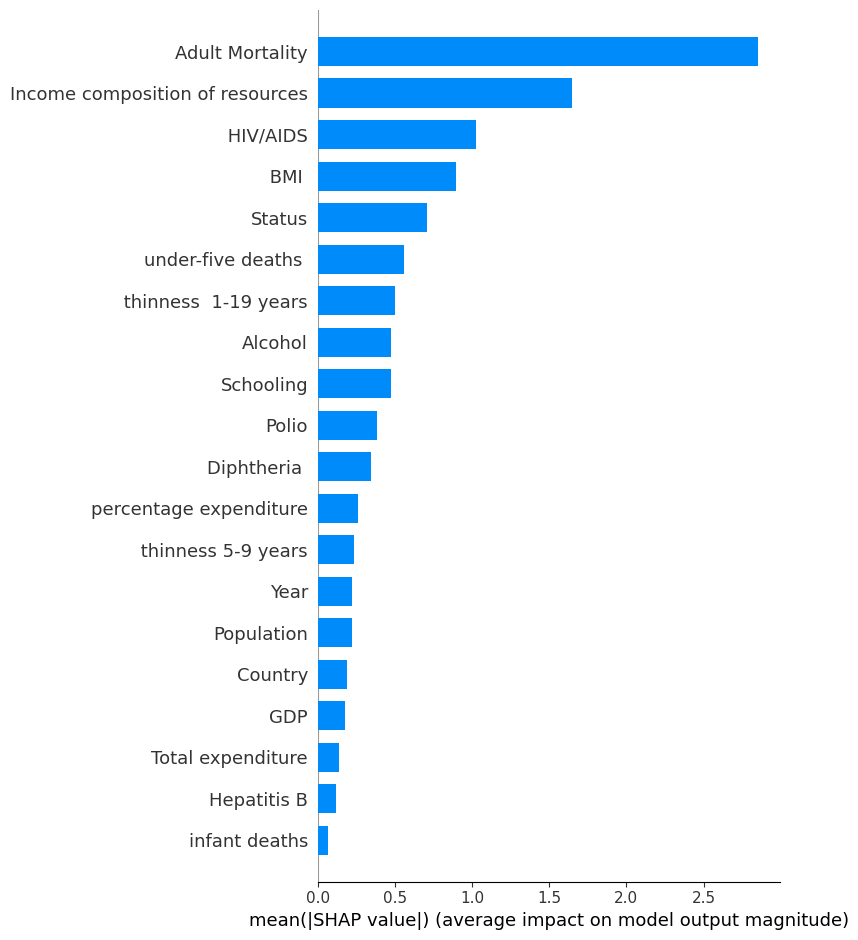

In [30]:
# we will create the objects for our explainer and SHAP method with the help of our model...
# ...and train data (all or part of the data) and try to explain based upon the features:

explainer_kernel_shap = shap.KernelExplainer(model.predict, background)
shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test)

# now, we will plot the summary plot for kernelshap method:
shap.summary_plot(shap_values_kernel_shap[0], x_test, feature_names=x.columns, plot_type='bar')

second, deepshap method:

some parts are inspired from https://snyk.io/advisor/python/shap/functions/shap.DeepExplainer and also https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/deep_explainer/DeepExplainer%20Genomics%20Example.html

"check_additivity=False" is inspired by https://github.com/slundberg/shap/issues/930

In [33]:
#explainer_deep_shap = shap.DeepExplainer(model, background)
#explainer_deep_shap = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
explainer_deep_shap = shap.DeepExplainer((model.input, model.output), background)

shap_values_deep_shap = explainer_deep_shap.shap_values(x_test, check_additivity=False)

# now, we will plot the summary plot for deepshap method:
shap.summary_plot(shap_values_deep_shap[0], x_test, feature_names=x.columns, plot_type='bar')

StagingError: in user code:

    File "C:\Program Files\Python39\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_Selu


#### now, onto the last part and drawing the force_plot for each of the methods:

In [ ]:
'''
# just for testing...

# first for kernelshap method:

shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test[1, :])

shap.force_plot(explainer_kernel_shap.expected_value, shap_values_kernel_shap[0], x_test[1, :],
                matplotlib=True, show=True, feature_names=x.columns, text_rotation=45)

plt.show()

# then, for deepshap method:

shap.force_plot(explainer_deep_shap.expected_value.numpy(), shap_values_deep_shap[0][1], x_test[1, :],
                matplotlib=True, show=True, feature_names=x.columns, text_rotation=45)

plt.show()
''';

In [ ]:
# we forgot to delete this feature from "x":
x.drop('Continent', inplace=True, axis=1)

for continent in continents_indices_for_x_test.keys():
    counter = 0
    #print(continent)

    for index in continents_indices_for_x_test[continent]:
        country = df.loc[continents_indices_for_df[continent][counter], 'Country']
        index_df = continents_indices_for_df[continent][counter]
        
        #print(country)
        #print(index)
        # first for kernelshap method:

        # we just perform on only one single datapoint from test-set:
        shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test[index, :])

        # we just plot and show on only one single datapoint from test-set:
        # inspired by https://www.youtube.com/watch?v=Z2kfLs2Dwqw&ab_channel=bsaldivar%3ADatascience
        shap.force_plot(explainer_kernel_shap.expected_value, shap_values_kernel_shap[0], x_test[index, :],
                        matplotlib=True, show=False, feature_names=x.columns, text_rotation=45)

        plt.title(f'KernelSHAP for continent "{continent}", country {country}, index "{index_df}" from original dataset', y=-0.9)
        plt.show()

        # then, for deepshap method:

        # we just plot and show on only one single datapoint from test-set:
        # inspired by https://www.youtube.com/watch?v=Z2kfLs2Dwqw&ab_channel=bsaldivar%3ADatascience
        # np.newaxis is for add a dimension to the first, meaning, instead of having only one single array...
        # ...we want to have an array which has that single array.
        # dimesnions we have: (21,) -> dimensions we will get after np.newaxis: (1, 21)
        shap_values_deep_shap = explainer_deep_shap.shap_values(x_test[index, :][np.newaxis, ...], check_additivity=False)

        shap.force_plot(explainer_deep_shap.expected_value.numpy(), shap_values_deep_shap[0], x_test[index, :],
                        matplotlib=True, show=False, feature_names=x.columns, text_rotation=45)

        plt.title(f'DeepSHAP for continent "{continent}", country "{country}", index "{index_df}" from original dataset', y=-0.92)
        plt.show()

        counter += 1

# again, after the error, we have to run anew, this time, using ReLU activation function

we are building the architecture of our model. we use Model and Functional API:

In [23]:
inputs = tf.keras.layers.Input(shape=x_train.shape[1])

features = tf.keras.layers.Dense(32)(inputs)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(64)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(128)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.05)(features)

features = tf.keras.layers.Dense(256)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(512)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(1024)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(512)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(256)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(128)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

features = tf.keras.layers.Dense(64)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.15)(features)

features = tf.keras.layers.Dense(32)(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.ReLU()(features)
#features = tf.keras.layers.Dropout(0.1)(features)

outputs = tf.keras.layers.Dense(1, activation='linear')(features)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

to see the architecture and the layers of our model:

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 32)                704       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

compile the model:

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

train the model:

In [26]:
history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_split=0.1)

Epoch 1/200
38/38 [==============================] - 4s 44ms/step - loss: 4788.8135 - val_loss: 4802.3496
Epoch 2/200
38/38 [==============================] - 1s 29ms/step - loss: 4651.7700 - val_loss: 4671.5498
Epoch 3/200
38/38 [==============================] - 1s 29ms/step - loss: 4542.8442 - val_loss: 4515.5244
Epoch 4/200
38/38 [==============================] - 1s 28ms/step - loss: 4434.5845 - val_loss: 4341.3228
Epoch 5/200
38/38 [==============================] - 1s 28ms/step - loss: 4315.5278 - val_loss: 4201.1313
Epoch 6/200
38/38 [==============================] - 1s 29ms/step - loss: 4175.3950 - val_loss: 4087.3279
Epoch 7/200
38/38 [==============================] - 1s 29ms/step - loss: 4004.7654 - val_loss: 3832.7913
Epoch 8/200
38/38 [==============================] - 1s 26ms/step - loss: 3813.3540 - val_loss: 3604.2581
Epoch 9/200
38/38 [==============================] - 1s 23ms/step - loss: 3610.6272 - val_loss: 3327.8860
Epoch 10/200
38/38 [==========================

Epoch 80/200
38/38 [==============================] - 1s 27ms/step - loss: 9.6210 - val_loss: 10.0386
Epoch 81/200
38/38 [==============================] - 1s 28ms/step - loss: 8.8476 - val_loss: 9.4900
Epoch 82/200
38/38 [==============================] - 1s 27ms/step - loss: 7.6299 - val_loss: 9.3056
Epoch 83/200
38/38 [==============================] - 1s 27ms/step - loss: 8.4000 - val_loss: 11.8179
Epoch 84/200
38/38 [==============================] - 1s 22ms/step - loss: 9.6887 - val_loss: 14.8495
Epoch 85/200
38/38 [==============================] - 1s 22ms/step - loss: 7.8016 - val_loss: 11.6579
Epoch 86/200
38/38 [==============================] - 1s 28ms/step - loss: 8.0330 - val_loss: 11.7871
Epoch 87/200
38/38 [==============================] - 1s 30ms/step - loss: 8.5208 - val_loss: 12.2472
Epoch 88/200
38/38 [==============================] - 1s 25ms/step - loss: 6.8909 - val_loss: 14.0088
Epoch 89/200
38/38 [==============================] - 1s 26ms/step - loss: 8.2438 - 

plot the training progress:

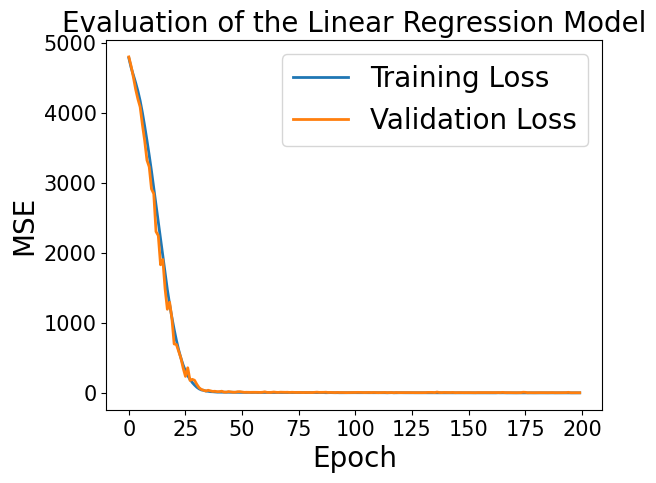

In [27]:
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Evaluation of the Linear Regression Model', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

evaluate the model on test-set:

In [28]:
model.evaluate(x=x_test, y=y_test)

10/10 [==============================] - 0s 8ms/step - loss: 5.3053


5.3053412437438965

#### now onto SHAP values:

first, kernelshap method:

since we don't have the enough processing power to process all train-set data, we just take 500 datapoints from it.

inspired by https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

In [29]:
#background = shap.kmeans(x_train, 500)
background = x_train[np.random.choice(x_train.shape[0], 500, replace=False)]

16/16 [==============================] - 0s 10ms/step


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|                                                                                                                    | 0/294 [00:00<?, ?it/s]

32657/32657 [==============================] - 195s 6ms/step


  0%|▎                                                                                                       | 1/294 [03:22<16:28:46, 202.48s/it]

32657/32657 [==============================] - 174s 5ms/step


  1%|▋                                                                                                       | 2/294 [06:23<15:22:55, 189.64s/it]

32657/32657 [==============================] - 176s 5ms/step


  1%|█                                                                                                       | 3/294 [09:25<15:04:20, 186.46s/it]

32657/32657 [==============================] - 176s 5ms/step


  1%|█▍                                                                                                      | 4/294 [12:29<14:55:29, 185.27s/it]

32657/32657 [==============================] - 177s 5ms/step


  2%|█▊                                                                                                      | 5/294 [15:33<14:50:41, 184.92s/it]

32657/32657 [==============================] - 174s 5ms/step


  2%|██                                                                                                      | 6/294 [18:33<14:39:43, 183.28s/it]

32657/32657 [==============================] - 136s 4ms/step


  2%|██▍                                                                                                     | 7/294 [20:55<13:32:38, 169.89s/it]

32657/32657 [==============================] - 133s 4ms/step


  3%|██▊                                                                                                     | 8/294 [23:16<12:44:34, 160.40s/it]

32657/32657 [==============================] - 133s 4ms/step


  3%|███▏                                                                                                    | 9/294 [25:35<12:10:28, 153.78s/it]

32657/32657 [==============================] - 133s 4ms/step


  3%|███▌                                                                                                   | 10/294 [27:54<11:47:20, 149.44s/it]

32657/32657 [==============================] - 138s 4ms/step


  4%|███▊                                                                                                   | 11/294 [30:19<11:37:11, 147.81s/it]

32657/32657 [==============================] - 137s 4ms/step


  4%|████▏                                                                                                  | 12/294 [32:42<11:28:21, 146.46s/it]

32657/32657 [==============================] - 133s 4ms/step


  4%|████▌                                                                                                  | 13/294 [35:01<11:15:40, 144.27s/it]

32657/32657 [==============================] - 133s 4ms/step


  5%|████▉                                                                                                  | 14/294 [37:20<11:06:11, 142.76s/it]

32657/32657 [==============================] - 132s 4ms/step


  5%|█████▎                                                                                                 | 15/294 [39:39<10:58:08, 141.54s/it]

32657/32657 [==============================] - 135s 4ms/step


  5%|█████▌                                                                                                 | 16/294 [42:00<10:55:19, 141.44s/it]

32657/32657 [==============================] - 137s 4ms/step


  6%|█████▉                                                                                                 | 17/294 [44:25<10:57:01, 142.32s/it]

32657/32657 [==============================] - 138s 4ms/step


  6%|██████▎                                                                                                | 18/294 [46:50<10:58:18, 143.11s/it]

32657/32657 [==============================] - 141s 4ms/step


  6%|██████▋                                                                                                | 19/294 [49:17<11:02:01, 144.44s/it]

32657/32657 [==============================] - 138s 4ms/step


  7%|███████                                                                                                | 20/294 [51:43<11:00:45, 144.69s/it]

32657/32657 [==============================] - 141s 4ms/step


  7%|███████▎                                                                                               | 21/294 [54:11<11:03:01, 145.72s/it]

32657/32657 [==============================] - 141s 4ms/step


  7%|███████▋                                                                                               | 22/294 [56:39<11:03:39, 146.40s/it]

32657/32657 [==============================] - 140s 4ms/step


  8%|████████                                                                                               | 23/294 [59:06<11:01:53, 146.54s/it]

32657/32657 [==============================] - 140s 4ms/step


  8%|████████▏                                                                                            | 24/294 [1:01:32<10:59:09, 146.48s/it]

32657/32657 [==============================] - 133s 4ms/step


  9%|████████▌                                                                                            | 25/294 [1:03:51<10:46:58, 144.31s/it]

32657/32657 [==============================] - 133s 4ms/step


  9%|████████▉                                                                                            | 26/294 [1:06:11<10:39:05, 143.08s/it]

32657/32657 [==============================] - 136s 4ms/step


  9%|█████████▎                                                                                           | 27/294 [1:08:34<10:35:54, 142.90s/it]

32657/32657 [==============================] - 135s 4ms/step


 10%|█████████▌                                                                                           | 28/294 [1:10:55<10:31:43, 142.50s/it]

32657/32657 [==============================] - 130s 4ms/step


 10%|█████████▉                                                                                           | 29/294 [1:13:12<10:20:58, 140.60s/it]

32657/32657 [==============================] - 131s 4ms/step


 10%|██████████▎                                                                                          | 30/294 [1:15:30<10:15:25, 139.87s/it]

32657/32657 [==============================] - 130s 4ms/step


 11%|██████████▋                                                                                          | 31/294 [1:17:46<10:08:04, 138.72s/it]

32657/32657 [==============================] - 132s 4ms/step


 11%|██████████▉                                                                                          | 32/294 [1:20:04<10:05:18, 138.62s/it]

32657/32657 [==============================] - 138s 4ms/step


 11%|███████████▎                                                                                         | 33/294 [1:22:29<10:10:36, 140.37s/it]

32657/32657 [==============================] - 136s 4ms/step


 12%|███████████▋                                                                                         | 34/294 [1:24:51<10:11:15, 141.06s/it]

32657/32657 [==============================] - 136s 4ms/step


 12%|████████████                                                                                         | 35/294 [1:27:14<10:11:11, 141.59s/it]

32657/32657 [==============================] - 134s 4ms/step


 12%|████████████▎                                                                                        | 36/294 [1:29:35<10:07:52, 141.37s/it]

32657/32657 [==============================] - 138s 4ms/step


 13%|████████████▋                                                                                        | 37/294 [1:32:00<10:10:23, 142.51s/it]

32657/32657 [==============================] - 147s 5ms/step


 13%|█████████████                                                                                        | 38/294 [1:34:34<10:23:09, 146.05s/it]

32657/32657 [==============================] - 136s 4ms/step


 13%|█████████████▍                                                                                       | 39/294 [1:36:57<10:16:34, 145.08s/it]

32657/32657 [==============================] - 132s 4ms/step


 14%|█████████████▋                                                                                       | 40/294 [1:39:16<10:06:03, 143.16s/it]

32657/32657 [==============================] - 167s 5ms/step


 14%|██████████████                                                                                       | 41/294 [1:42:10<10:42:36, 152.40s/it]

32657/32657 [==============================] - 165s 5ms/step


 14%|██████████████▍                                                                                      | 42/294 [1:45:02<11:04:43, 158.27s/it]

32657/32657 [==============================] - 176s 5ms/step


 15%|██████████████▊                                                                                      | 43/294 [1:48:05<11:33:06, 165.68s/it]

32657/32657 [==============================] - 169s 5ms/step


 15%|███████████████                                                                                      | 44/294 [1:51:01<11:42:59, 168.72s/it]

32657/32657 [==============================] - 168s 5ms/step


 15%|███████████████▍                                                                                     | 45/294 [1:53:56<11:48:36, 170.75s/it]

32657/32657 [==============================] - 171s 5ms/step


 16%|███████████████▊                                                                                     | 46/294 [1:56:55<11:55:24, 173.08s/it]

32657/32657 [==============================] - 164s 5ms/step


 16%|████████████████▏                                                                                    | 47/294 [1:59:45<11:49:31, 172.35s/it]

32657/32657 [==============================] - 153s 5ms/step


 16%|████████████████▍                                                                                    | 48/294 [2:02:25<11:30:57, 168.53s/it]

32657/32657 [==============================] - 155s 5ms/step


 17%|████████████████▊                                                                                    | 49/294 [2:05:07<11:19:46, 166.48s/it]

32657/32657 [==============================] - 158s 5ms/step


 17%|█████████████████▏                                                                                   | 50/294 [2:07:51<11:14:37, 165.89s/it]

32657/32657 [==============================] - 170s 5ms/step


 17%|█████████████████▌                                                                                   | 51/294 [2:10:48<11:25:35, 169.28s/it]

32657/32657 [==============================] - 161s 5ms/step


 18%|█████████████████▊                                                                                   | 52/294 [2:13:36<11:21:18, 168.92s/it]

32657/32657 [==============================] - 158s 5ms/step


 18%|██████████████████▏                                                                                  | 53/294 [2:16:22<11:14:01, 167.81s/it]

32657/32657 [==============================] - 171s 5ms/step


 18%|██████████████████▌                                                                                  | 54/294 [2:19:20<11:24:09, 171.04s/it]

32657/32657 [==============================] - 166s 5ms/step


 19%|██████████████████▉                                                                                  | 55/294 [2:22:13<11:22:56, 171.45s/it]

32657/32657 [==============================] - 156s 5ms/step


 19%|███████████████████▏                                                                                 | 56/294 [2:24:55<11:09:42, 168.83s/it]

32657/32657 [==============================] - 171s 5ms/step


 19%|███████████████████▌                                                                                 | 57/294 [2:27:54<11:18:30, 171.77s/it]

32657/32657 [==============================] - 183s 6ms/step


 20%|███████████████████▉                                                                                 | 58/294 [2:31:04<11:37:28, 177.32s/it]

32657/32657 [==============================] - 169s 5ms/step


 20%|████████████████████▎                                                                                | 59/294 [2:34:00<11:32:46, 176.88s/it]

32657/32657 [==============================] - 164s 5ms/step


 20%|████████████████████▌                                                                                | 60/294 [2:36:51<11:23:00, 175.13s/it]

32657/32657 [==============================] - 165s 5ms/step


 21%|████████████████████▉                                                                                | 61/294 [2:39:42<11:15:33, 173.97s/it]

32657/32657 [==============================] - 149s 5ms/step


 21%|█████████████████████▎                                                                               | 62/294 [2:42:18<10:51:07, 168.40s/it]

32657/32657 [==============================] - 149s 5ms/step


 21%|█████████████████████▋                                                                               | 63/294 [2:44:54<10:34:09, 164.72s/it]

32657/32657 [==============================] - 162s 5ms/step


 22%|█████████████████████▉                                                                               | 64/294 [2:47:43<10:36:42, 166.10s/it]

32657/32657 [==============================] - 153s 5ms/step


 22%|██████████████████████▎                                                                              | 65/294 [2:50:23<10:26:51, 164.24s/it]

32657/32657 [==============================] - 154s 5ms/step


 22%|██████████████████████▋                                                                              | 66/294 [2:53:05<10:20:55, 163.40s/it]

32657/32657 [==============================] - 166s 5ms/step


 23%|███████████████████████                                                                              | 67/294 [2:55:57<10:29:02, 166.27s/it]

32657/32657 [==============================] - 179s 5ms/step


 23%|███████████████████████▎                                                                             | 68/294 [2:59:04<10:49:02, 172.31s/it]

32657/32657 [==============================] - 170s 5ms/step


 23%|███████████████████████▋                                                                             | 69/294 [3:02:01<10:51:34, 173.75s/it]

32657/32657 [==============================] - 164s 5ms/step


 24%|████████████████████████                                                                             | 70/294 [3:04:52<10:45:04, 172.79s/it]

32657/32657 [==============================] - 165s 5ms/step


 24%|████████████████████████▍                                                                            | 71/294 [3:07:43<10:41:11, 172.52s/it]

32657/32657 [==============================] - 155s 5ms/step


 24%|████████████████████████▋                                                                            | 72/294 [3:10:26<10:27:00, 169.46s/it]

32657/32657 [==============================] - 162s 5ms/step


 25%|█████████████████████████                                                                            | 73/294 [3:13:15<10:23:55, 169.39s/it]

32657/32657 [==============================] - 173s 5ms/step


 25%|█████████████████████████▍                                                                           | 74/294 [3:16:15<10:32:57, 172.63s/it]

32657/32657 [==============================] - 163s 5ms/step


 26%|█████████████████████████▊                                                                           | 75/294 [3:19:05<10:27:31, 171.92s/it]

32657/32657 [==============================] - 163s 5ms/step


 26%|██████████████████████████                                                                           | 76/294 [3:21:55<10:22:30, 171.33s/it]

32657/32657 [==============================] - 156s 5ms/step


 26%|██████████████████████████▍                                                                          | 77/294 [3:24:38<10:10:26, 168.79s/it]

32657/32657 [==============================] - 168s 5ms/step


 27%|██████████████████████████▊                                                                          | 78/294 [3:27:34<10:15:02, 170.85s/it]

32657/32657 [==============================] - 161s 5ms/step


 27%|███████████████████████████▏                                                                         | 79/294 [3:30:22<10:08:50, 169.91s/it]

32657/32657 [==============================] - 161s 5ms/step


 27%|███████████████████████████▍                                                                         | 80/294 [3:33:10<10:04:05, 169.37s/it]

32657/32657 [==============================] - 153s 5ms/step


 28%|████████████████████████████                                                                          | 81/294 [3:35:50<9:51:53, 166.73s/it]

32657/32657 [==============================] - 165s 5ms/step


 28%|████████████████████████████▍                                                                         | 82/294 [3:38:42<9:54:22, 168.22s/it]

32657/32657 [==============================] - 164s 5ms/step


 28%|████████████████████████████▊                                                                         | 83/294 [3:41:33<9:54:08, 168.95s/it]

32657/32657 [==============================] - 162s 5ms/step


 29%|█████████████████████████████▏                                                                        | 84/294 [3:44:23<9:53:10, 169.48s/it]

32657/32657 [==============================] - 154s 5ms/step


 29%|█████████████████████████████▍                                                                        | 85/294 [3:47:04<9:41:31, 166.94s/it]

32657/32657 [==============================] - 151s 5ms/step


 29%|█████████████████████████████▊                                                                        | 86/294 [3:49:42<9:29:31, 164.28s/it]

32657/32657 [==============================] - 162s 5ms/step


 30%|██████████████████████████████▏                                                                       | 87/294 [3:52:32<9:32:07, 165.83s/it]

32657/32657 [==============================] - 161s 5ms/step


 30%|██████████████████████████████▌                                                                       | 88/294 [3:55:20<9:31:46, 166.54s/it]

32657/32657 [==============================] - 167s 5ms/step


 30%|██████████████████████████████▉                                                                       | 89/294 [3:58:14<9:36:47, 168.82s/it]

32657/32657 [==============================] - 151s 5ms/step


 31%|███████████████████████████████▏                                                                      | 90/294 [4:00:52<9:22:40, 165.49s/it]

32657/32657 [==============================] - 152s 5ms/step


 31%|███████████████████████████████▌                                                                      | 91/294 [4:03:31<9:13:04, 163.47s/it]

32657/32657 [==============================] - 150s 5ms/step


 31%|███████████████████████████████▉                                                                      | 92/294 [4:06:07<9:03:25, 161.41s/it]

32657/32657 [==============================] - 151s 5ms/step


 32%|████████████████████████████████▎                                                                     | 93/294 [4:08:45<8:56:55, 160.27s/it]

32657/32657 [==============================] - 136s 4ms/step


 32%|████████████████████████████████▌                                                                     | 94/294 [4:11:08<8:36:55, 155.08s/it]

32657/32657 [==============================] - 128s 4ms/step


 32%|████████████████████████████████▉                                                                     | 95/294 [4:13:23<8:14:13, 149.01s/it]

32657/32657 [==============================] - 132s 4ms/step


 33%|█████████████████████████████████▎                                                                    | 96/294 [4:15:41<8:01:10, 145.81s/it]

32657/32657 [==============================] - 131s 4ms/step


 33%|█████████████████████████████████▋                                                                    | 97/294 [4:17:59<7:50:38, 143.34s/it]

32657/32657 [==============================] - 130s 4ms/step


 33%|██████████████████████████████████                                                                    | 98/294 [4:20:16<7:41:56, 141.41s/it]

32657/32657 [==============================] - 131s 4ms/step


 34%|██████████████████████████████████▎                                                                   | 99/294 [4:22:33<7:35:50, 140.26s/it]

32657/32657 [==============================] - 132s 4ms/step


 34%|██████████████████████████████████▎                                                                  | 100/294 [4:24:52<7:31:54, 139.77s/it]

32657/32657 [==============================] - 132s 4ms/step


 34%|██████████████████████████████████▋                                                                  | 101/294 [4:27:10<7:28:15, 139.36s/it]

32657/32657 [==============================] - 130s 4ms/step


 35%|███████████████████████████████████                                                                  | 102/294 [4:29:27<7:23:08, 138.48s/it]

32657/32657 [==============================] - 131s 4ms/step


 35%|███████████████████████████████████▍                                                                 | 103/294 [4:31:44<7:19:34, 138.09s/it]

32657/32657 [==============================] - 141s 4ms/step


 35%|███████████████████████████████████▋                                                                 | 104/294 [4:34:11<7:26:01, 140.85s/it]

32657/32657 [==============================] - 130s 4ms/step


 36%|████████████████████████████████████                                                                 | 105/294 [4:36:28<7:19:54, 139.65s/it]

32657/32657 [==============================] - 132s 4ms/step


 36%|████████████████████████████████████▍                                                                | 106/294 [4:38:47<7:16:42, 139.37s/it]

32657/32657 [==============================] - 130s 4ms/step


 36%|████████████████████████████████████▊                                                                | 107/294 [4:41:03<7:11:34, 138.47s/it]

32657/32657 [==============================] - 131s 4ms/step


 37%|█████████████████████████████████████                                                                | 108/294 [4:43:21<7:08:34, 138.25s/it]

32657/32657 [==============================] - 131s 4ms/step


 37%|█████████████████████████████████████▍                                                               | 109/294 [4:45:38<7:05:45, 138.08s/it]

32657/32657 [==============================] - 130s 4ms/step


 37%|█████████████████████████████████████▊                                                               | 110/294 [4:47:55<7:01:56, 137.59s/it]

32657/32657 [==============================] - 130s 4ms/step


 38%|██████████████████████████████████████▏                                                              | 111/294 [4:50:11<6:58:44, 137.29s/it]

32657/32657 [==============================] - 132s 4ms/step


 38%|██████████████████████████████████████▍                                                              | 112/294 [4:52:30<6:57:38, 137.68s/it]

32657/32657 [==============================] - 130s 4ms/step


 38%|██████████████████████████████████████▊                                                              | 113/294 [4:54:46<6:54:03, 137.26s/it]

32657/32657 [==============================] - 140s 4ms/step


 39%|███████████████████████████████████████▏                                                             | 114/294 [4:57:13<7:00:03, 140.02s/it]

32657/32657 [==============================] - 133s 4ms/step


 39%|███████████████████████████████████████▌                                                             | 115/294 [4:59:32<6:57:12, 139.85s/it]

32657/32657 [==============================] - 135s 4ms/step


 39%|███████████████████████████████████████▊                                                             | 116/294 [5:01:54<6:56:09, 140.28s/it]

32657/32657 [==============================] - 131s 4ms/step


 40%|████████████████████████████████████████▏                                                            | 117/294 [5:04:11<6:51:06, 139.36s/it]

32657/32657 [==============================] - 130s 4ms/step


 40%|████████████████████████████████████████▌                                                            | 118/294 [5:06:28<6:46:41, 138.65s/it]

32657/32657 [==============================] - 129s 4ms/step


 40%|████████████████████████████████████████▉                                                            | 119/294 [5:08:43<6:41:42, 137.73s/it]

32657/32657 [==============================] - 132s 4ms/step


 41%|█████████████████████████████████████████▏                                                           | 120/294 [5:11:02<6:39:48, 137.86s/it]

32657/32657 [==============================] - 140s 4ms/step


 41%|█████████████████████████████████████████▌                                                           | 121/294 [5:13:28<6:44:58, 140.45s/it]

32657/32657 [==============================] - 143s 4ms/step


 41%|█████████████████████████████████████████▉                                                           | 122/294 [5:15:58<6:50:26, 143.18s/it]

32657/32657 [==============================] - 130s 4ms/step


 42%|██████████████████████████████████████████▎                                                          | 123/294 [5:18:15<6:42:45, 141.32s/it]

32657/32657 [==============================] - 141s 4ms/step


 42%|██████████████████████████████████████████▌                                                          | 124/294 [5:20:42<6:45:40, 143.18s/it]

32657/32657 [==============================] - 131s 4ms/step


 43%|██████████████████████████████████████████▉                                                          | 125/294 [5:23:00<6:38:49, 141.59s/it]

32657/32657 [==============================] - 130s 4ms/step


 43%|███████████████████████████████████████████▎                                                         | 126/294 [5:25:17<6:32:40, 140.24s/it]

32657/32657 [==============================] - 131s 4ms/step


 43%|███████████████████████████████████████████▋                                                         | 127/294 [5:27:35<6:28:09, 139.46s/it]

32657/32657 [==============================] - 130s 4ms/step


 44%|███████████████████████████████████████████▉                                                         | 128/294 [5:29:51<6:23:15, 138.53s/it]

32657/32657 [==============================] - 131s 4ms/step


 44%|████████████████████████████████████████████▎                                                        | 129/294 [5:32:08<6:19:47, 138.10s/it]

32657/32657 [==============================] - 131s 4ms/step


 44%|████████████████████████████████████████████▋                                                        | 130/294 [5:34:26<6:17:18, 138.04s/it]

32657/32657 [==============================] - 136s 4ms/step


 45%|█████████████████████████████████████████████                                                        | 131/294 [5:36:49<6:18:54, 139.48s/it]

32657/32657 [==============================] - 131s 4ms/step


 45%|█████████████████████████████████████████████▎                                                       | 132/294 [5:39:06<6:14:54, 138.86s/it]

32657/32657 [==============================] - 130s 4ms/step


 45%|█████████████████████████████████████████████▋                                                       | 133/294 [5:41:22<6:10:18, 138.00s/it]

32657/32657 [==============================] - 130s 4ms/step


 46%|██████████████████████████████████████████████                                                       | 134/294 [5:43:39<6:07:13, 137.71s/it]

32657/32657 [==============================] - 131s 4ms/step


 46%|██████████████████████████████████████████████▍                                                      | 135/294 [5:45:57<6:05:04, 137.76s/it]

32657/32657 [==============================] - 131s 4ms/step


 46%|██████████████████████████████████████████████▋                                                      | 136/294 [5:48:14<6:02:21, 137.60s/it]

32657/32657 [==============================] - 130s 4ms/step


 47%|███████████████████████████████████████████████                                                      | 137/294 [5:50:31<5:59:11, 137.27s/it]

32657/32657 [==============================] - 130s 4ms/step


 47%|███████████████████████████████████████████████▍                                                     | 138/294 [5:52:47<5:56:05, 136.96s/it]

32657/32657 [==============================] - 130s 4ms/step


 47%|███████████████████████████████████████████████▊                                                     | 139/294 [5:55:04<5:53:27, 136.82s/it]

32657/32657 [==============================] - 132s 4ms/step


 48%|████████████████████████████████████████████████                                                     | 140/294 [5:57:22<5:52:17, 137.26s/it]

32657/32657 [==============================] - 129s 4ms/step


 48%|████████████████████████████████████████████████▍                                                    | 141/294 [5:59:38<5:48:57, 136.85s/it]

32657/32657 [==============================] - 129s 4ms/step


 48%|████████████████████████████████████████████████▊                                                    | 142/294 [6:01:53<5:45:48, 136.51s/it]

32657/32657 [==============================] - 129s 4ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 143/294 [6:04:09<5:42:50, 136.23s/it]

32657/32657 [==============================] - 132s 4ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 144/294 [6:06:27<5:41:54, 136.76s/it]

32657/32657 [==============================] - 131s 4ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 145/294 [6:08:44<5:39:52, 136.87s/it]

32657/32657 [==============================] - 130s 4ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 146/294 [6:11:01<5:37:38, 136.88s/it]

32657/32657 [==============================] - 130s 4ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 147/294 [6:13:18<5:35:00, 136.74s/it]

32657/32657 [==============================] - 130s 4ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 148/294 [6:15:34<5:32:38, 136.71s/it]

32657/32657 [==============================] - 131s 4ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 149/294 [6:17:52<5:30:52, 136.91s/it]

32657/32657 [==============================] - 130s 4ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 150/294 [6:20:08<5:28:20, 136.81s/it]

32657/32657 [==============================] - 130s 4ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 151/294 [6:22:24<5:25:40, 136.65s/it]

32657/32657 [==============================] - 131s 4ms/step


 52%|████████████████████████████████████████████████████▏                                                | 152/294 [6:24:42<5:24:15, 137.01s/it]

32657/32657 [==============================] - 129s 4ms/step


 52%|████████████████████████████████████████████████████▌                                                | 153/294 [6:26:58<5:20:47, 136.51s/it]

32657/32657 [==============================] - 130s 4ms/step


 52%|████████████████████████████████████████████████████▉                                                | 154/294 [6:29:14<5:18:26, 136.47s/it]

32657/32657 [==============================] - 131s 4ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 155/294 [6:31:31<5:16:46, 136.74s/it]

32657/32657 [==============================] - 130s 4ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 156/294 [6:33:48<5:14:39, 136.81s/it]

32657/32657 [==============================] - 128s 4ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 157/294 [6:36:03<5:11:05, 136.25s/it]

32657/32657 [==============================] - 131s 4ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 158/294 [6:38:21<5:09:33, 136.57s/it]

32657/32657 [==============================] - 129s 4ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 159/294 [6:40:36<5:06:29, 136.22s/it]

32657/32657 [==============================] - 130s 4ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 160/294 [6:42:52<5:04:13, 136.22s/it]

32657/32657 [==============================] - 130s 4ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 161/294 [6:45:09<5:02:07, 136.30s/it]

32657/32657 [==============================] - 130s 4ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 162/294 [6:47:26<5:00:14, 136.48s/it]

32657/32657 [==============================] - 129s 4ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 163/294 [6:49:41<4:57:20, 136.19s/it]

32657/32657 [==============================] - 129s 4ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 164/294 [6:51:57<4:54:48, 136.07s/it]

32657/32657 [==============================] - 131s 4ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 165/294 [6:54:15<4:53:39, 136.58s/it]

32657/32657 [==============================] - 130s 4ms/step


 56%|█████████████████████████████████████████████████████████                                            | 166/294 [6:56:31<4:51:00, 136.41s/it]

32657/32657 [==============================] - 130s 4ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 167/294 [6:58:47<4:48:53, 136.49s/it]

32657/32657 [==============================] - 140s 4ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 168/294 [7:01:13<4:52:36, 139.33s/it]

32657/32657 [==============================] - 131s 4ms/step


 57%|██████████████████████████████████████████████████████████                                           | 169/294 [7:03:30<4:48:57, 138.70s/it]

32657/32657 [==============================] - 140s 4ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 170/294 [7:05:57<4:51:22, 140.99s/it]

32657/32657 [==============================] - 132s 4ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 171/294 [7:08:15<4:47:14, 140.12s/it]

32657/32657 [==============================] - 131s 4ms/step


 59%|███████████████████████████████████████████████████████████                                          | 172/294 [7:10:32<4:43:05, 139.22s/it]

32657/32657 [==============================] - 130s 4ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 173/294 [7:12:49<4:39:15, 138.47s/it]

32657/32657 [==============================] - 131s 4ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 174/294 [7:15:06<4:36:21, 138.18s/it]

32657/32657 [==============================] - 129s 4ms/step


 60%|████████████████████████████████████████████████████████████                                         | 175/294 [7:17:22<4:32:41, 137.49s/it]

32657/32657 [==============================] - 130s 4ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 176/294 [7:19:38<4:29:36, 137.09s/it]

32657/32657 [==============================] - 131s 4ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 177/294 [7:21:56<4:27:24, 137.13s/it]

32657/32657 [==============================] - 130s 4ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 178/294 [7:24:12<4:24:42, 136.92s/it]

32657/32657 [==============================] - 129s 4ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 179/294 [7:26:28<4:21:43, 136.55s/it]

32657/32657 [==============================] - 131s 4ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 180/294 [7:28:45<4:20:09, 136.93s/it]

32657/32657 [==============================] - 131s 4ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 181/294 [7:31:03<4:18:13, 137.11s/it]

32657/32657 [==============================] - 131s 4ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 182/294 [7:33:21<4:16:31, 137.42s/it]

32657/32657 [==============================] - 130s 4ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 183/294 [7:35:38<4:13:57, 137.28s/it]

32657/32657 [==============================] - 132s 4ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 184/294 [7:37:58<4:13:09, 138.09s/it]

32657/32657 [==============================] - 132s 4ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 185/294 [7:40:16<4:11:00, 138.17s/it]

32657/32657 [==============================] - 131s 4ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 186/294 [7:42:34<4:08:33, 138.09s/it]

32657/32657 [==============================] - 129s 4ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 187/294 [7:44:50<4:05:05, 137.44s/it]

32657/32657 [==============================] - 131s 4ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 188/294 [7:47:08<4:02:59, 137.55s/it]

32657/32657 [==============================] - 132s 4ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 189/294 [7:49:26<4:00:57, 137.69s/it]

32657/32657 [==============================] - 132s 4ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 190/294 [7:51:45<3:59:10, 137.99s/it]

32657/32657 [==============================] - 131s 4ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 191/294 [7:54:02<3:56:39, 137.86s/it]

32657/32657 [==============================] - 130s 4ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 192/294 [7:56:19<3:53:46, 137.52s/it]

32657/32657 [==============================] - 131s 4ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 193/294 [7:58:37<3:51:35, 137.58s/it]

32657/32657 [==============================] - 131s 4ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 194/294 [8:00:54<3:49:17, 137.57s/it]

32657/32657 [==============================] - 131s 4ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 195/294 [8:03:11<3:46:43, 137.41s/it]

32657/32657 [==============================] - 131s 4ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 196/294 [8:05:29<3:44:39, 137.54s/it]

32657/32657 [==============================] - 133s 4ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 197/294 [8:07:48<3:43:10, 138.05s/it]

32657/32657 [==============================] - 141s 4ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 198/294 [8:10:16<3:45:13, 140.77s/it]

32657/32657 [==============================] - 131s 4ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 199/294 [8:12:33<3:41:29, 139.89s/it]

32657/32657 [==============================] - 132s 4ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 200/294 [8:14:52<3:38:35, 139.53s/it]

32657/32657 [==============================] - 131s 4ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 201/294 [8:17:10<3:35:19, 138.92s/it]

32657/32657 [==============================] - 131s 4ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 202/294 [8:19:27<3:32:31, 138.60s/it]

32657/32657 [==============================] - 130s 4ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 203/294 [8:21:44<3:29:25, 138.09s/it]

32657/32657 [==============================] - 132s 4ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 204/294 [8:24:03<3:27:15, 138.17s/it]

32657/32657 [==============================] - 130s 4ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 205/294 [8:26:19<3:24:09, 137.64s/it]

32657/32657 [==============================] - 130s 4ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 206/294 [8:28:36<3:21:27, 137.36s/it]

32657/32657 [==============================] - 131s 4ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 207/294 [8:30:53<3:19:05, 137.31s/it]

32657/32657 [==============================] - 132s 4ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 208/294 [8:33:12<3:17:31, 137.81s/it]

32657/32657 [==============================] - 131s 4ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 209/294 [8:35:30<3:15:12, 137.79s/it]

32657/32657 [==============================] - 130s 4ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 210/294 [8:37:47<3:12:31, 137.52s/it]

32657/32657 [==============================] - 129s 4ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 211/294 [8:40:02<3:09:26, 136.94s/it]

32657/32657 [==============================] - 131s 4ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 212/294 [8:42:20<3:07:22, 137.11s/it]

32657/32657 [==============================] - 129s 4ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 213/294 [8:44:36<3:04:34, 136.73s/it]

32657/32657 [==============================] - 132s 4ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 214/294 [8:46:54<3:03:02, 137.28s/it]

32657/32657 [==============================] - 130s 4ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 215/294 [8:49:11<3:00:29, 137.09s/it]

32657/32657 [==============================] - 130s 4ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 216/294 [8:51:28<2:58:08, 137.03s/it]

32657/32657 [==============================] - 131s 4ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 217/294 [8:53:45<2:55:57, 137.11s/it]

32657/32657 [==============================] - 131s 4ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 218/294 [8:56:02<2:53:42, 137.13s/it]

32657/32657 [==============================] - 130s 4ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 219/294 [8:58:19<2:51:12, 136.96s/it]

32657/32657 [==============================] - 131s 4ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 220/294 [9:00:36<2:49:08, 137.14s/it]

32657/32657 [==============================] - 130s 4ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 221/294 [9:02:52<2:46:27, 136.82s/it]

32657/32657 [==============================] - 131s 4ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 222/294 [9:05:10<2:44:39, 137.22s/it]

32657/32657 [==============================] - 131s 4ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 223/294 [9:07:28<2:42:33, 137.37s/it]

32657/32657 [==============================] - 129s 4ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 224/294 [9:09:44<2:39:38, 136.83s/it]

32657/32657 [==============================] - 130s 4ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 225/294 [9:12:00<2:37:17, 136.78s/it]

32657/32657 [==============================] - 130s 4ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 226/294 [9:14:17<2:34:55, 136.70s/it]

32657/32657 [==============================] - 130s 4ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 227/294 [9:16:33<2:32:30, 136.57s/it]

32657/32657 [==============================] - 132s 4ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 228/294 [9:18:51<2:30:47, 137.08s/it]

32657/32657 [==============================] - 131s 4ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 229/294 [9:21:09<2:28:48, 137.36s/it]

32657/32657 [==============================] - 130s 4ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 230/294 [9:23:27<2:26:25, 137.27s/it]

32657/32657 [==============================] - 130s 4ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 231/294 [9:25:43<2:23:49, 136.97s/it]

32657/32657 [==============================] - 131s 4ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 232/294 [9:28:00<2:21:34, 137.01s/it]

32657/32657 [==============================] - 131s 4ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 233/294 [9:30:17<2:19:25, 137.14s/it]

32657/32657 [==============================] - 132s 4ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 234/294 [9:32:36<2:17:40, 137.67s/it]

32657/32657 [==============================] - 130s 4ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 235/294 [9:34:53<2:15:01, 137.32s/it]

32657/32657 [==============================] - 131s 4ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 236/294 [9:37:11<2:12:53, 137.47s/it]

32657/32657 [==============================] - 130s 4ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 237/294 [9:39:27<2:10:10, 137.03s/it]

32657/32657 [==============================] - 131s 4ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 238/294 [9:41:44<2:07:59, 137.13s/it]

32657/32657 [==============================] - 131s 4ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 239/294 [9:44:02<2:05:51, 137.30s/it]

32657/32657 [==============================] - 132s 4ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 240/294 [9:46:20<2:03:50, 137.61s/it]

32657/32657 [==============================] - 131s 4ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 241/294 [9:48:37<2:01:27, 137.51s/it]

32657/32657 [==============================] - 132s 4ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 242/294 [9:50:56<1:59:22, 137.74s/it]

32657/32657 [==============================] - 130s 4ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 243/294 [9:53:12<1:56:42, 137.30s/it]

32657/32657 [==============================] - 133s 4ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 244/294 [9:55:31<1:54:53, 137.88s/it]

32657/32657 [==============================] - 129s 4ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 245/294 [9:57:47<1:52:06, 137.27s/it]

32657/32657 [==============================] - 132s 4ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 246/294 [10:00:05<1:50:02, 137.56s/it]

32657/32657 [==============================] - 131s 4ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████                | 247/294 [10:02:23<1:47:50, 137.66s/it]

32657/32657 [==============================] - 132s 4ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 248/294 [10:04:41<1:45:38, 137.80s/it]

32657/32657 [==============================] - 129s 4ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 249/294 [10:06:57<1:42:52, 137.16s/it]

32657/32657 [==============================] - 130s 4ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 250/294 [10:09:14<1:40:32, 137.11s/it]

32657/32657 [==============================] - 131s 4ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 251/294 [10:11:32<1:38:25, 137.35s/it]

32657/32657 [==============================] - 132s 4ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 252/294 [10:13:50<1:36:19, 137.62s/it]

32657/32657 [==============================] - 132s 4ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 253/294 [10:16:08<1:34:07, 137.74s/it]

32657/32657 [==============================] - 131s 4ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 254/294 [10:18:26<1:31:49, 137.73s/it]

32657/32657 [==============================] - 132s 4ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 255/294 [10:20:44<1:29:39, 137.93s/it]

32657/32657 [==============================] - 131s 4ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 256/294 [10:23:02<1:27:17, 137.82s/it]

32657/32657 [==============================] - 132s 4ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 257/294 [10:25:20<1:25:03, 137.93s/it]

32657/32657 [==============================] - 130s 4ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 258/294 [10:27:37<1:22:36, 137.68s/it]

32657/32657 [==============================] - 131s 4ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 259/294 [10:29:54<1:20:15, 137.58s/it]

32657/32657 [==============================] - 130s 4ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 260/294 [10:32:11<1:17:49, 137.33s/it]

32657/32657 [==============================] - 129s 4ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 261/294 [10:34:27<1:15:14, 136.80s/it]

32657/32657 [==============================] - 131s 4ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 262/294 [10:36:44<1:13:02, 136.97s/it]

32657/32657 [==============================] - 130s 4ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 263/294 [10:39:01<1:10:42, 136.86s/it]

32657/32657 [==============================] - 132s 4ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 264/294 [10:41:19<1:08:37, 137.25s/it]

32657/32657 [==============================] - 131s 4ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 265/294 [10:43:36<1:06:20, 137.27s/it]

32657/32657 [==============================] - 130s 4ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 266/294 [10:45:53<1:04:01, 137.19s/it]

32657/32657 [==============================] - 129s 4ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 267/294 [10:48:09<1:01:31, 136.72s/it]

32657/32657 [==============================] - 132s 4ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 268/294 [10:50:27<59:29, 137.29s/it]

32657/32657 [==============================] - 131s 4ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 269/294 [10:52:45<57:16, 137.44s/it]

32657/32657 [==============================] - 130s 4ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 270/294 [10:55:02<54:53, 137.22s/it]

32657/32657 [==============================] - 130s 4ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 271/294 [10:57:18<52:29, 136.94s/it]

32657/32657 [==============================] - 132s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 272/294 [10:59:37<50:23, 137.44s/it]

32657/32657 [==============================] - 131s 4ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 273/294 [11:01:54<48:03, 137.32s/it]

32657/32657 [==============================] - 131s 4ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 274/294 [11:04:11<45:47, 137.39s/it]

32657/32657 [==============================] - 130s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 275/294 [11:06:28<43:24, 137.10s/it]

32657/32657 [==============================] - 131s 4ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 276/294 [11:08:45<41:10, 137.23s/it]

32657/32657 [==============================] - 131s 4ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 277/294 [11:11:03<38:54, 137.30s/it]

32657/32657 [==============================] - 131s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 278/294 [11:13:20<36:38, 137.40s/it]

32657/32657 [==============================] - 132s 4ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 279/294 [11:15:39<34:27, 137.80s/it]

32657/32657 [==============================] - 133s 4ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 280/294 [11:17:59<32:16, 138.32s/it]

32657/32657 [==============================] - 131s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 281/294 [11:20:17<29:56, 138.21s/it]

32657/32657 [==============================] - 132s 4ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/294 [11:22:35<27:39, 138.25s/it]

32657/32657 [==============================] - 130s 4ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 283/294 [11:24:51<25:14, 137.69s/it]

32657/32657 [==============================] - 132s 4ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 284/294 [11:27:10<22:58, 137.88s/it]

32657/32657 [==============================] - 129s 4ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 285/294 [11:29:25<20:35, 137.29s/it]

32657/32657 [==============================] - 130s 4ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 286/294 [11:31:42<18:16, 137.08s/it]

32657/32657 [==============================] - 130s 4ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 287/294 [11:33:59<15:59, 137.01s/it]

32657/32657 [==============================] - 132s 4ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 288/294 [11:36:17<13:44, 137.36s/it]

32657/32657 [==============================] - 130s 4ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 289/294 [11:38:33<11:25, 137.03s/it]

32657/32657 [==============================] - 131s 4ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 290/294 [11:40:51<09:09, 137.29s/it]

32657/32657 [==============================] - 132s 4ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 291/294 [11:43:10<06:52, 137.62s/it]

32657/32657 [==============================] - 132s 4ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 292/294 [11:45:28<04:35, 137.98s/it]

32657/32657 [==============================] - 131s 4ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 293/294 [11:47:46<02:17, 137.72s/it]

32657/32657 [==============================] - 131s 4ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [11:50:03<00:00, 144.91s/it]


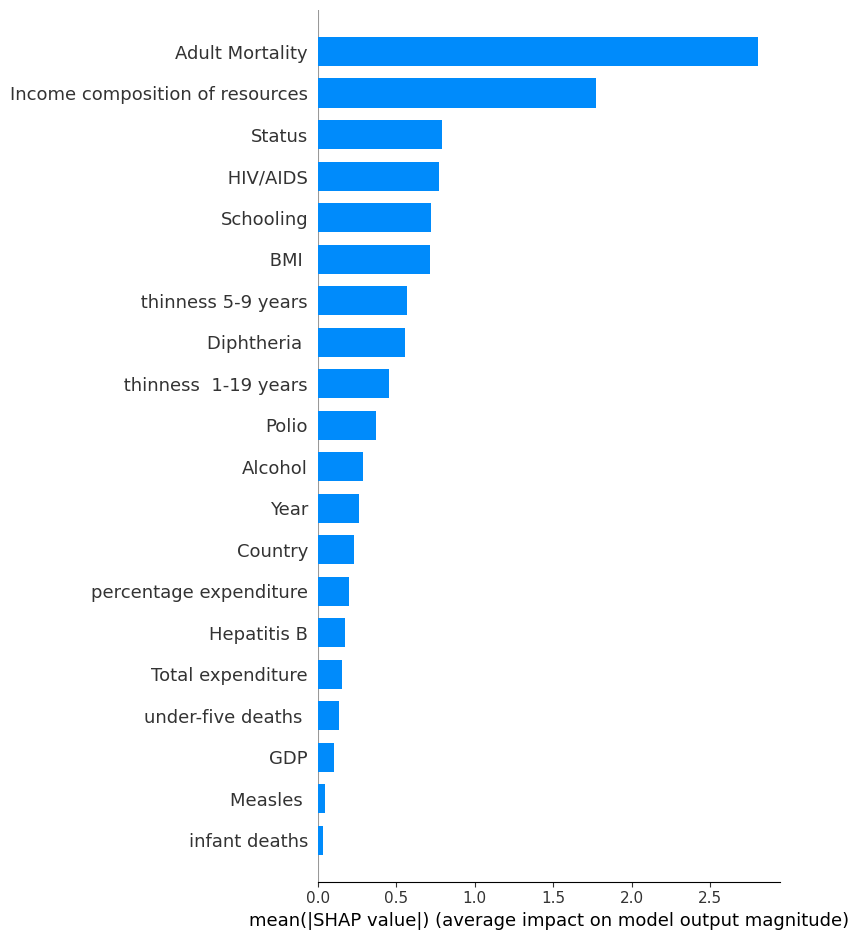

In [30]:
# we will create the objects for our explainer and SHAP method with the help of our model...
# ...and train data (all or part of the data) and try to explain based upon the features:

explainer_kernel_shap = shap.KernelExplainer(model.predict, background)
shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test)

# now, we will plot the summary plot for kernelshap method:
shap.summary_plot(shap_values_kernel_shap[0], x_test, feature_names=x.columns, plot_type='bar')

second, deepshap method:

some parts are inspired from https://snyk.io/advisor/python/shap/functions/shap.DeepExplainer and also https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/deep_explainer/DeepExplainer%20Genomics%20Example.html

"check_additivity=False" is inspired by https://github.com/slundberg/shap/issues/930

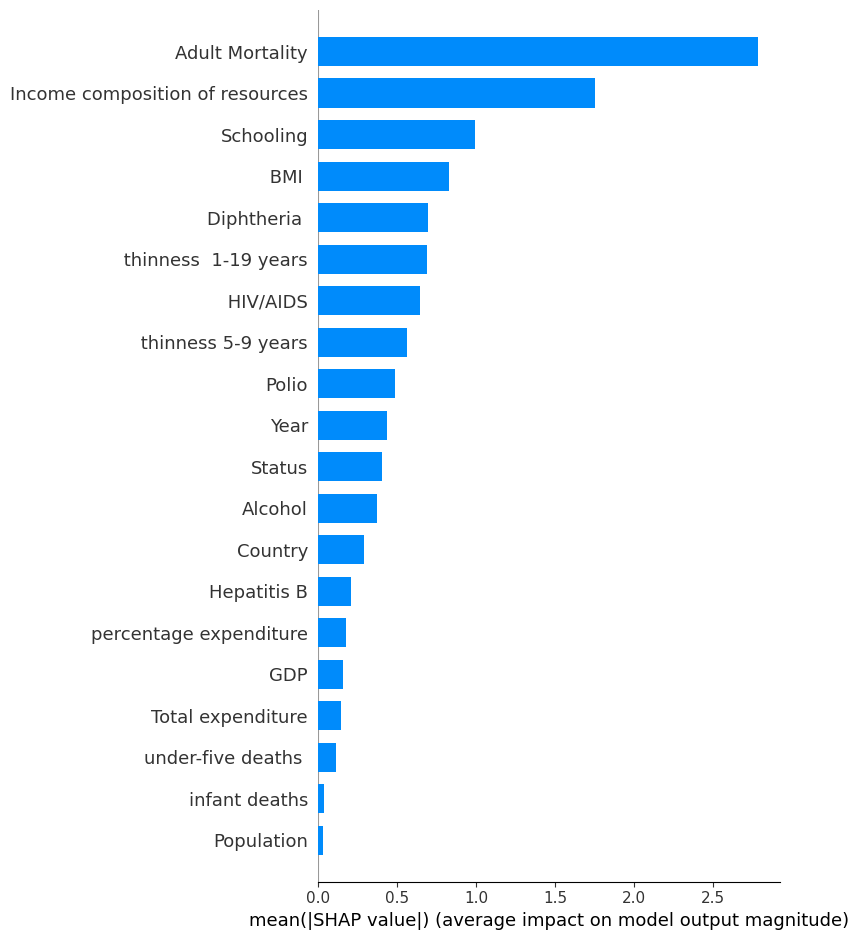

In [31]:
#explainer_deep_shap = shap.DeepExplainer(model, background)
#explainer_deep_shap = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
explainer_deep_shap = shap.DeepExplainer((model.input, model.output), background)

shap_values_deep_shap = explainer_deep_shap.shap_values(x_test, check_additivity=False)

# now, we will plot the summary plot for deepshap method:
shap.summary_plot(shap_values_deep_shap[0], x_test, feature_names=x.columns, plot_type='bar')

#### now, onto the last part and drawing the force_plot for each of the methods:

In [32]:
'''
# just for testing...

# first for kernelshap method:

shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test[1, :])

shap.force_plot(explainer_kernel_shap.expected_value, shap_values_kernel_shap[0], x_test[1, :],
                matplotlib=True, show=True, feature_names=x.columns, text_rotation=45)

plt.show()

# then, for deepshap method:

shap.force_plot(explainer_deep_shap.expected_value.numpy(), shap_values_deep_shap[0][1], x_test[1, :],
                matplotlib=True, show=True, feature_names=x.columns, text_rotation=45)

plt.show()
''';

32657/32657 [==============================] - 135s 4ms/step


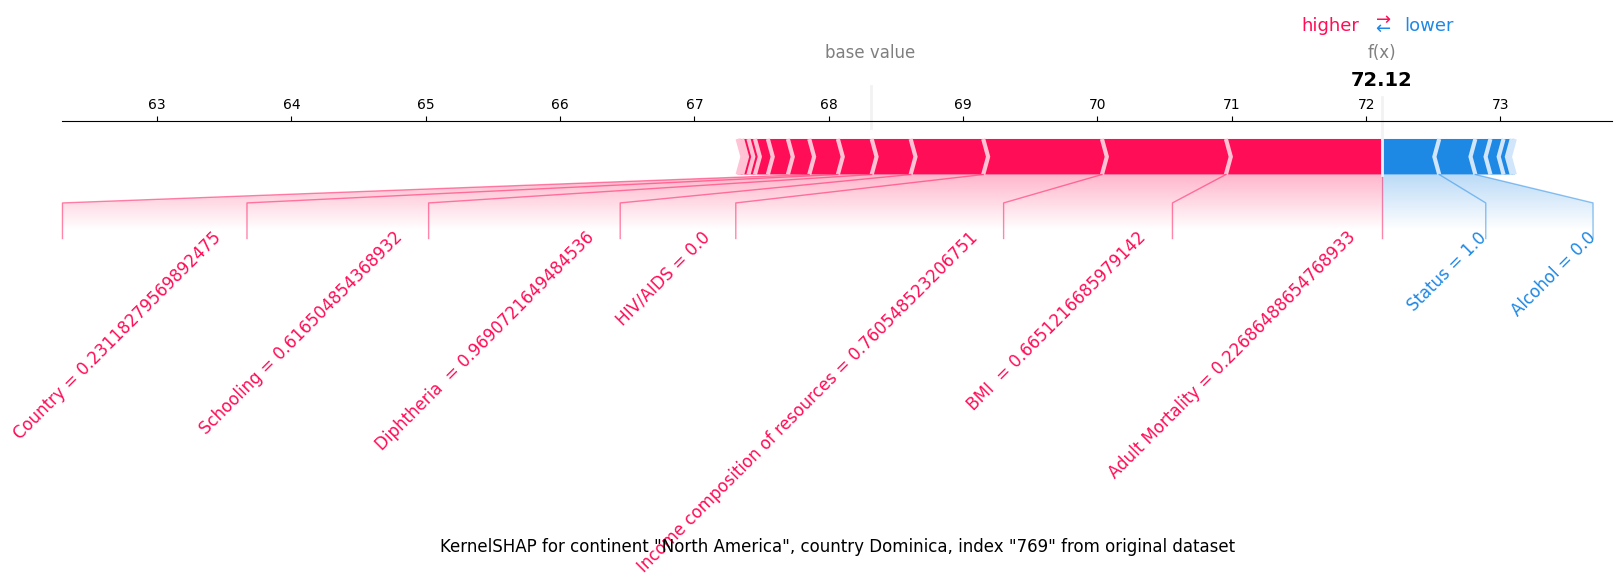

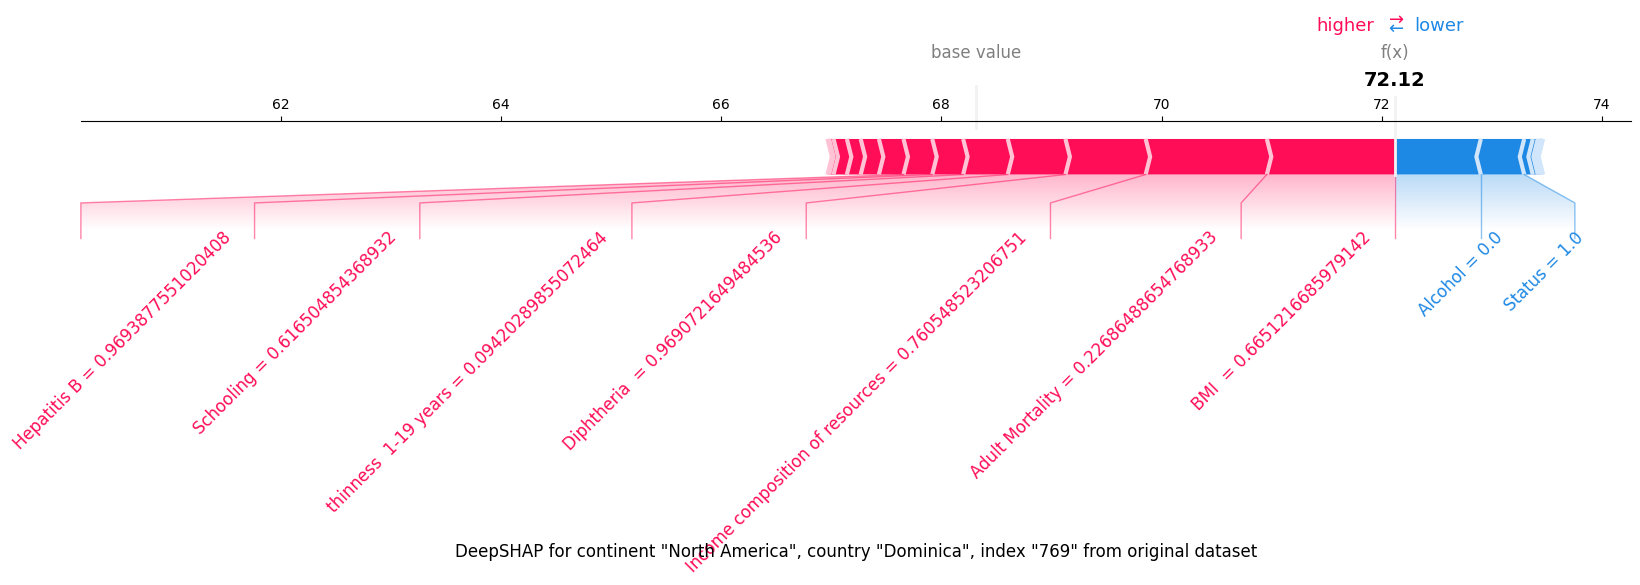

32657/32657 [==============================] - 128s 4ms/step


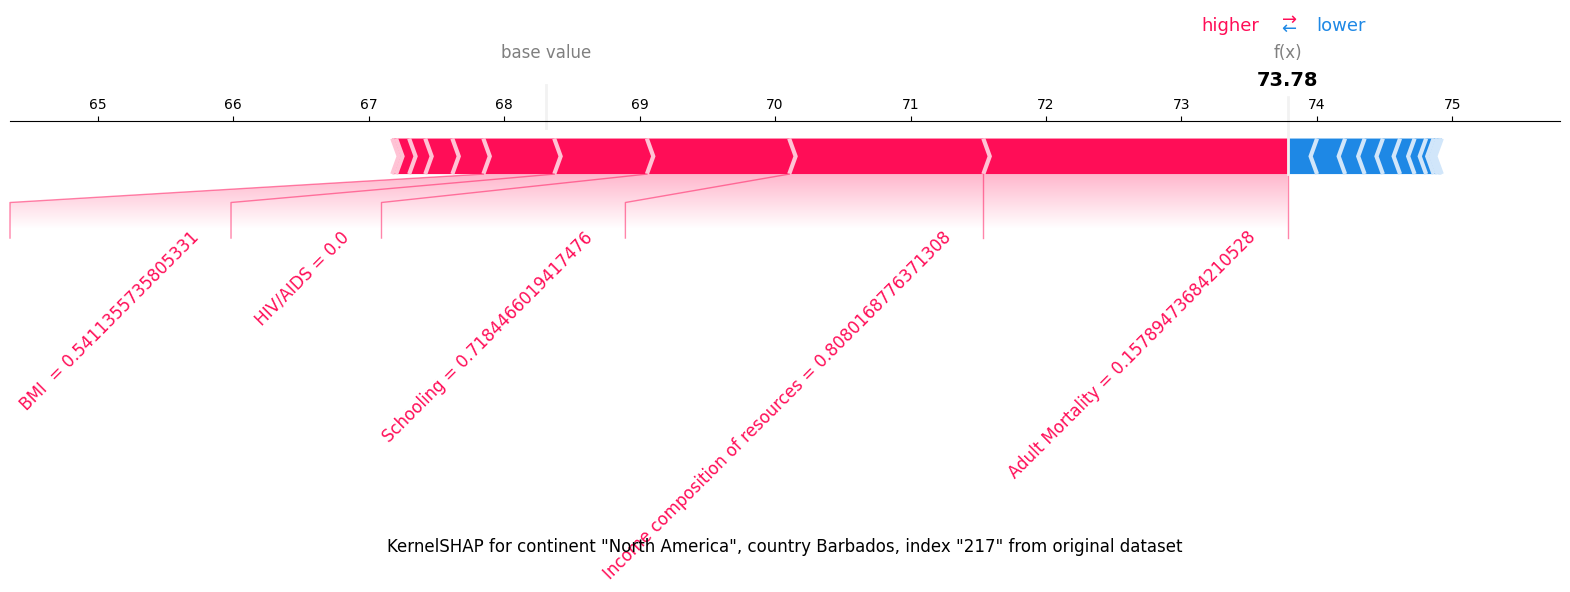

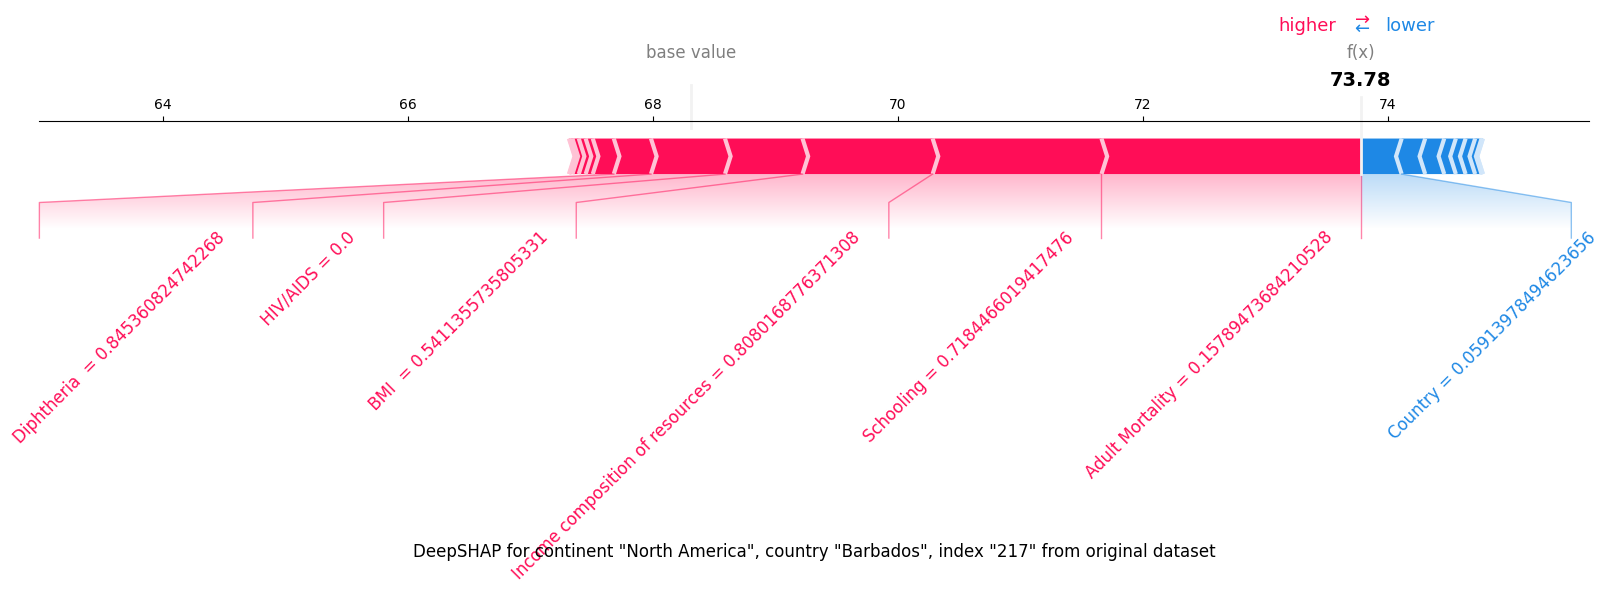

32657/32657 [==============================] - 128s 4ms/step


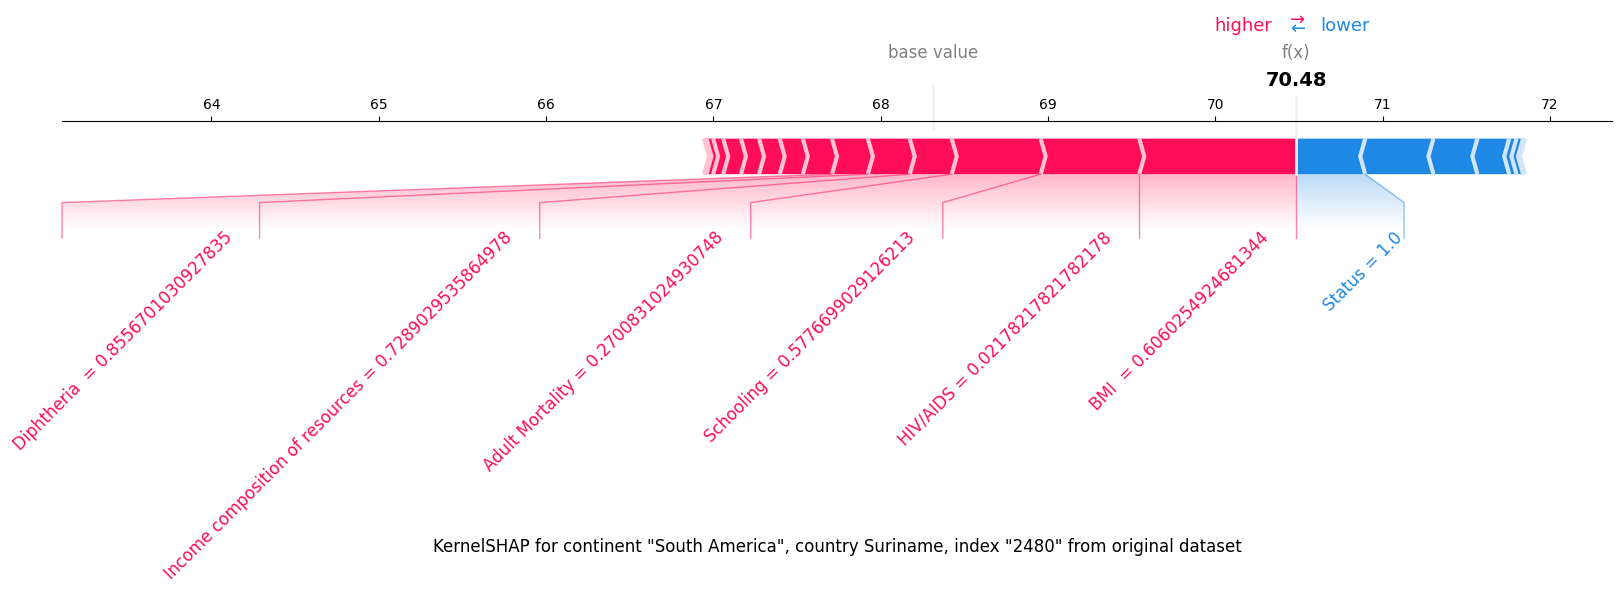

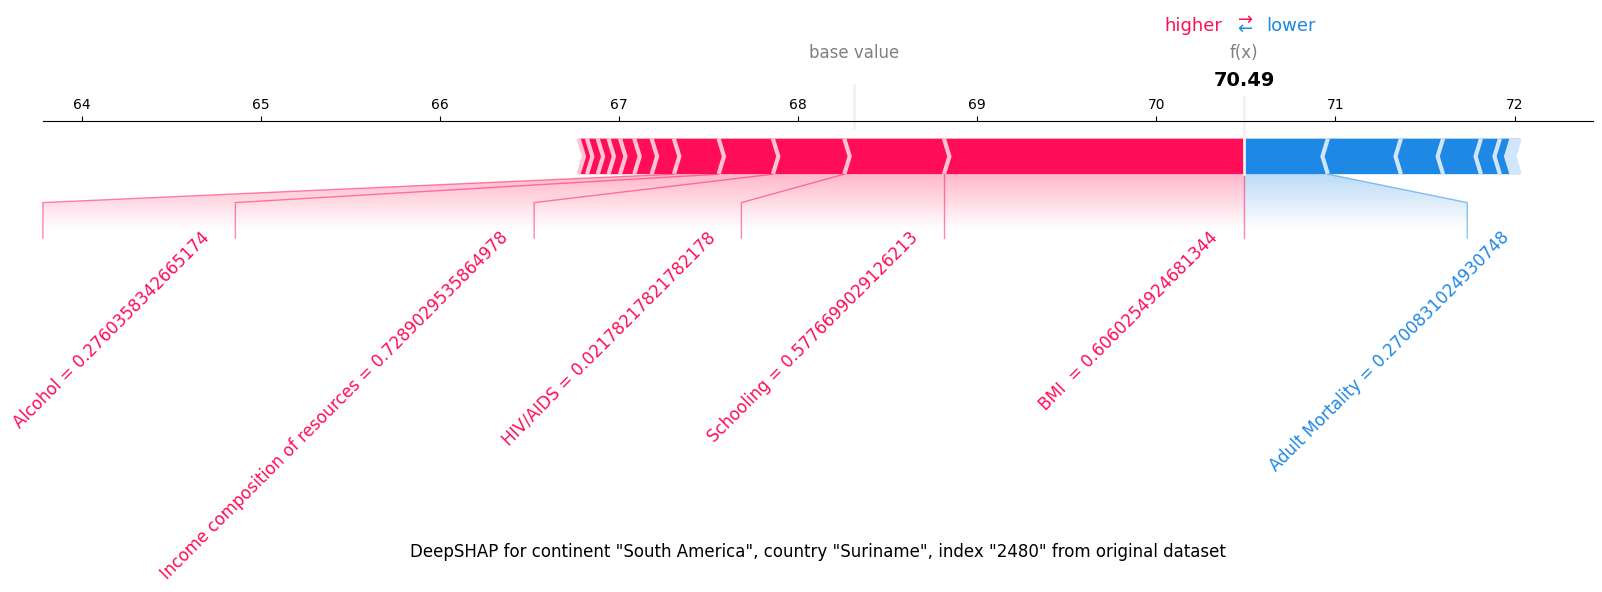

32657/32657 [==============================] - 127s 4ms/step


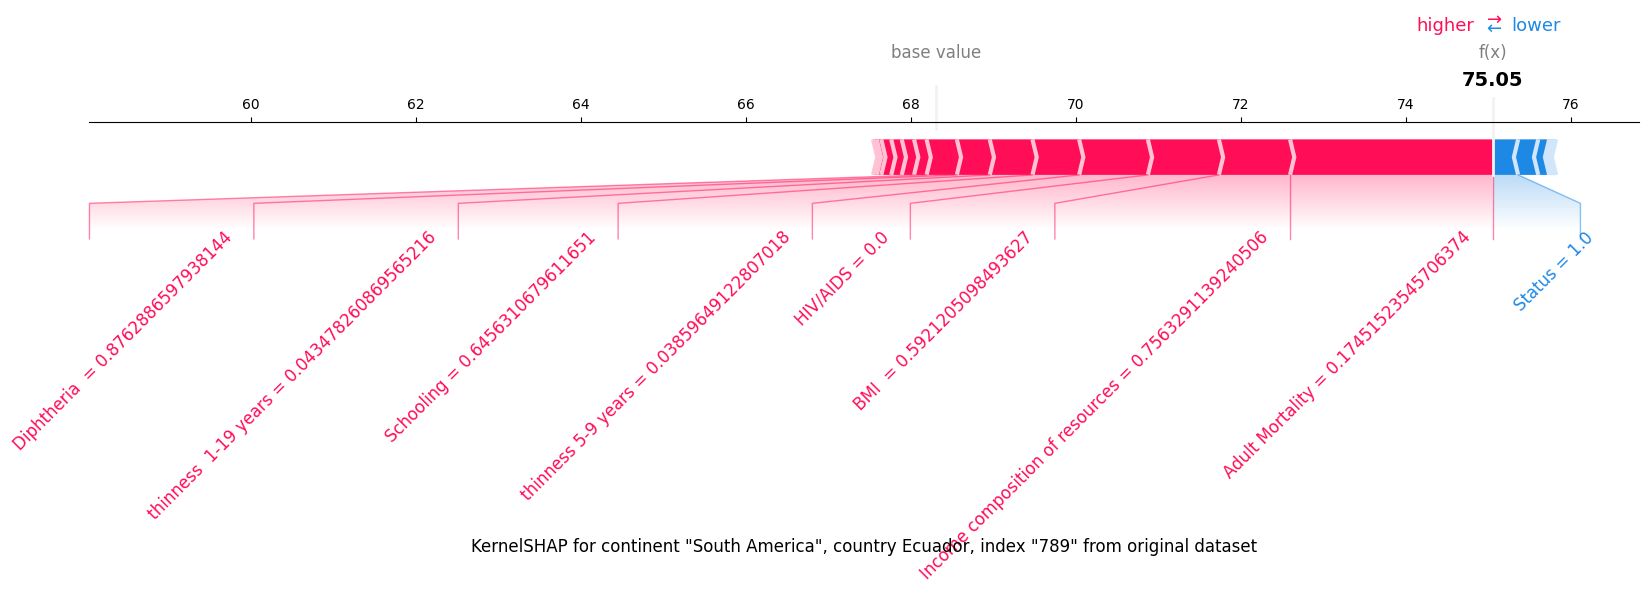

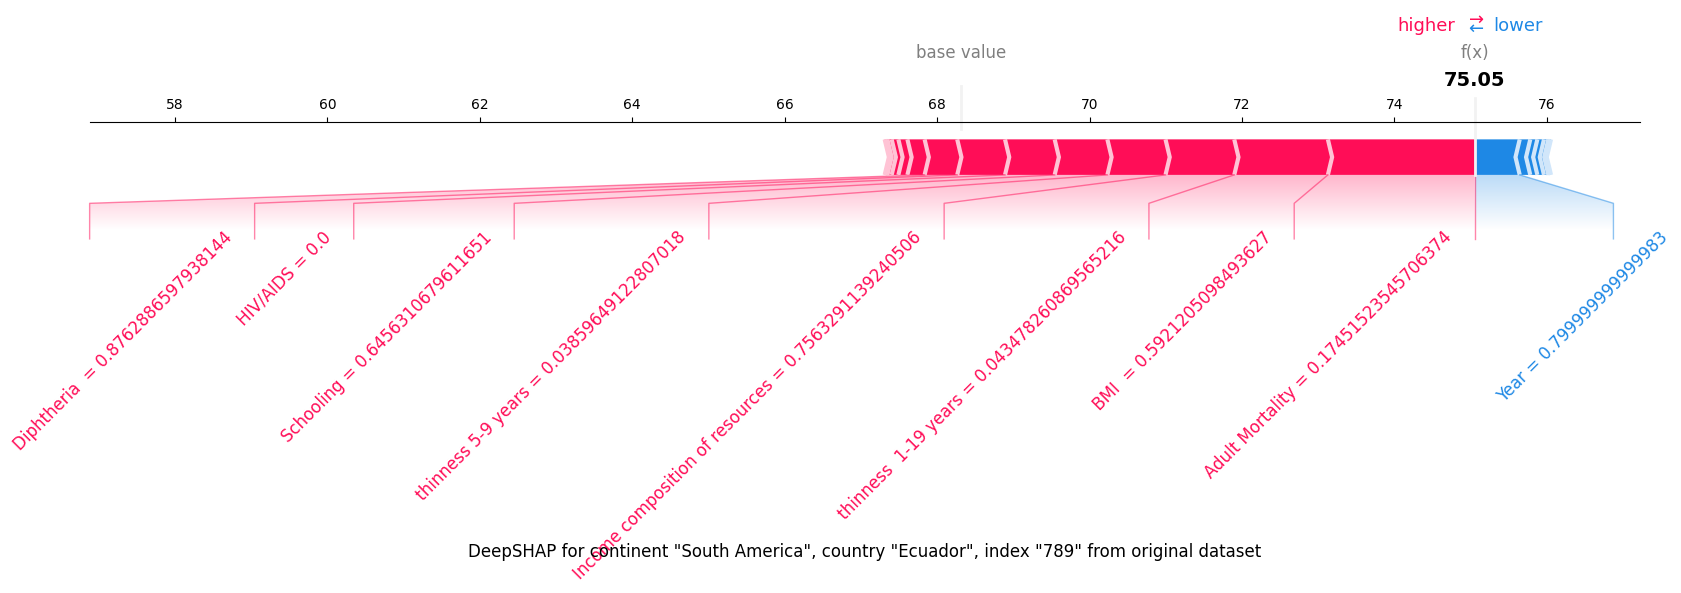

32657/32657 [==============================] - 128s 4ms/step


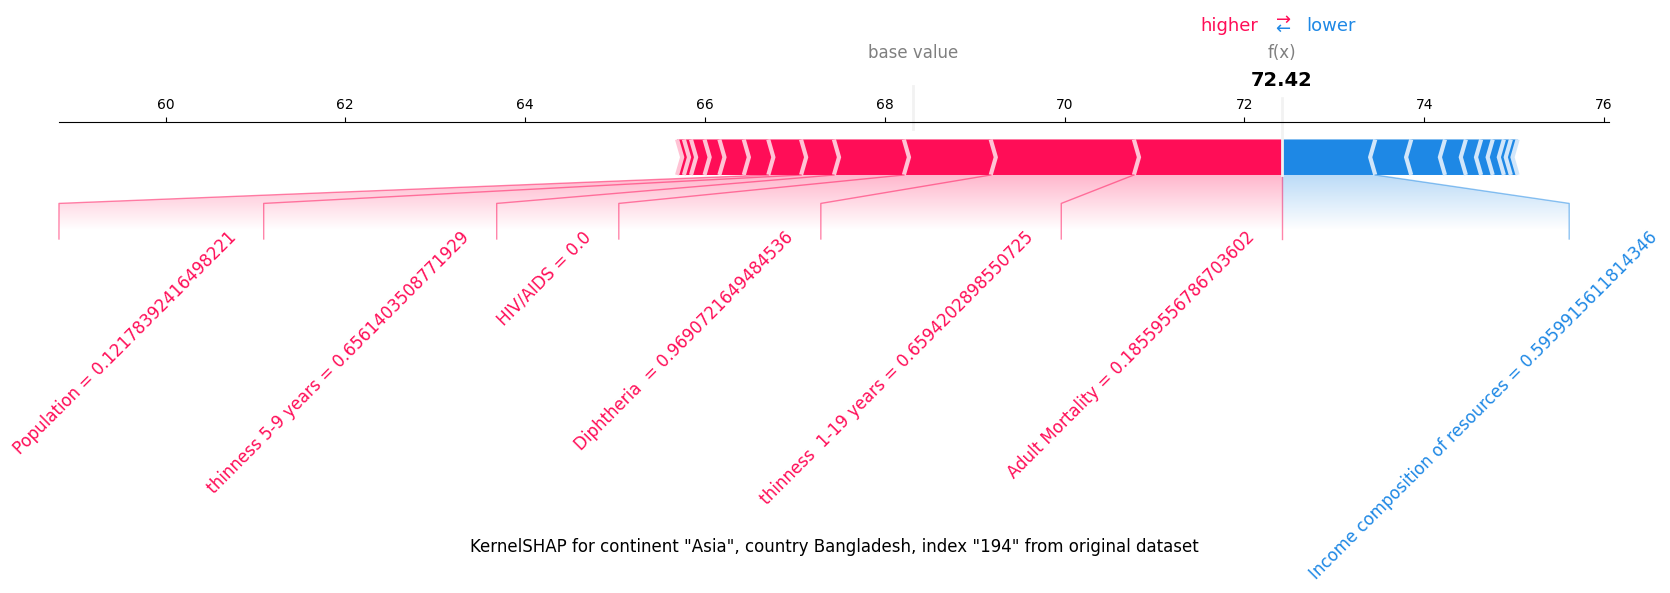

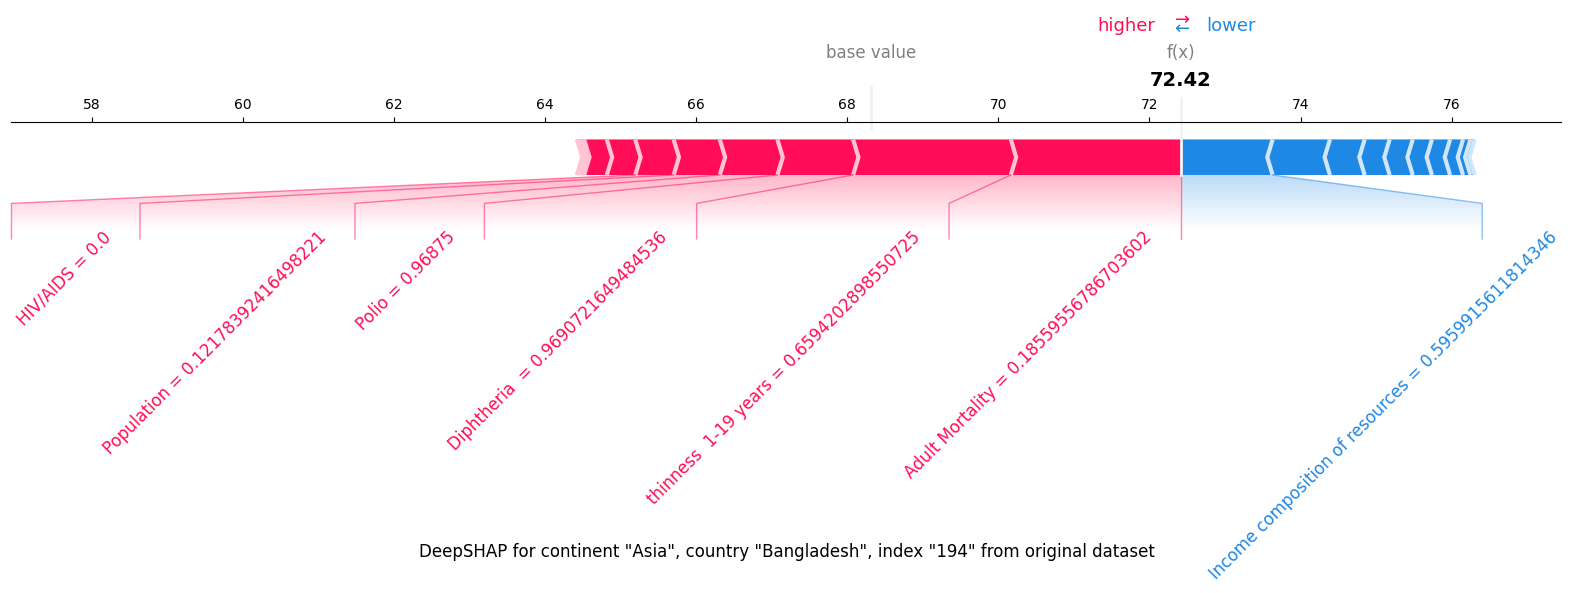

32657/32657 [==============================] - 129s 4ms/step


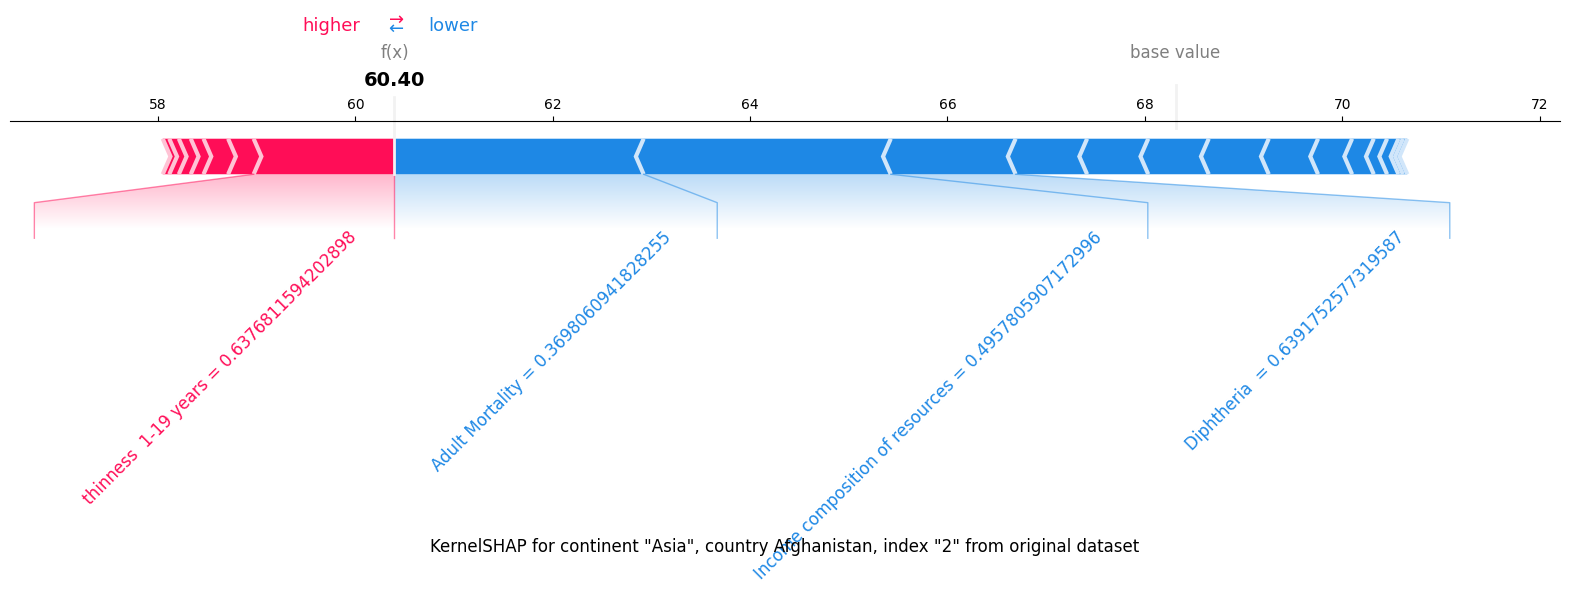

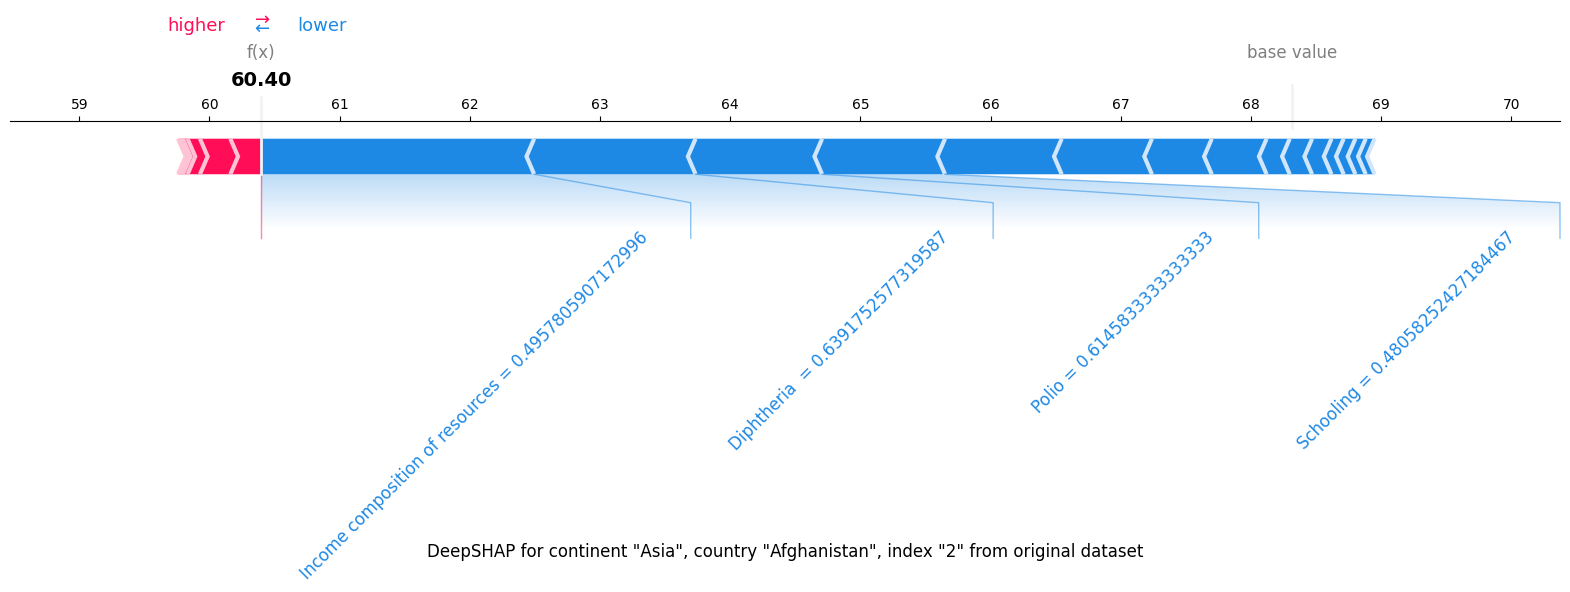

32657/32657 [==============================] - 131s 4ms/step


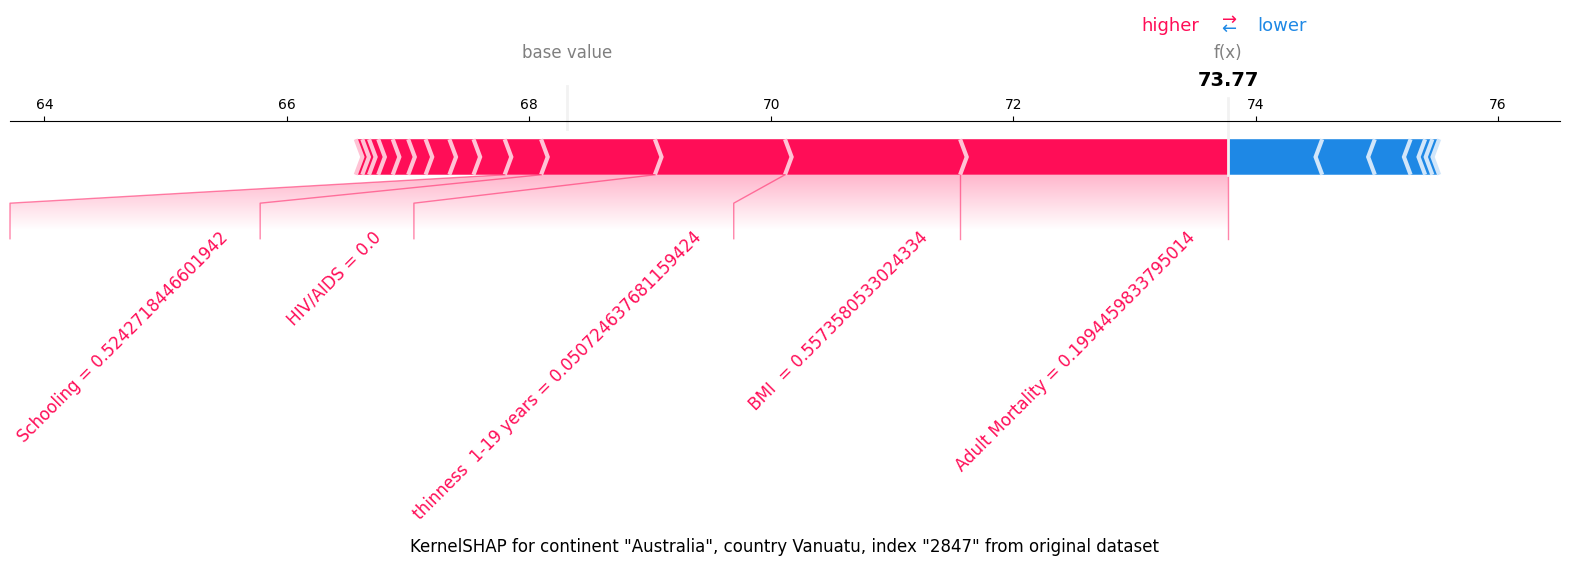

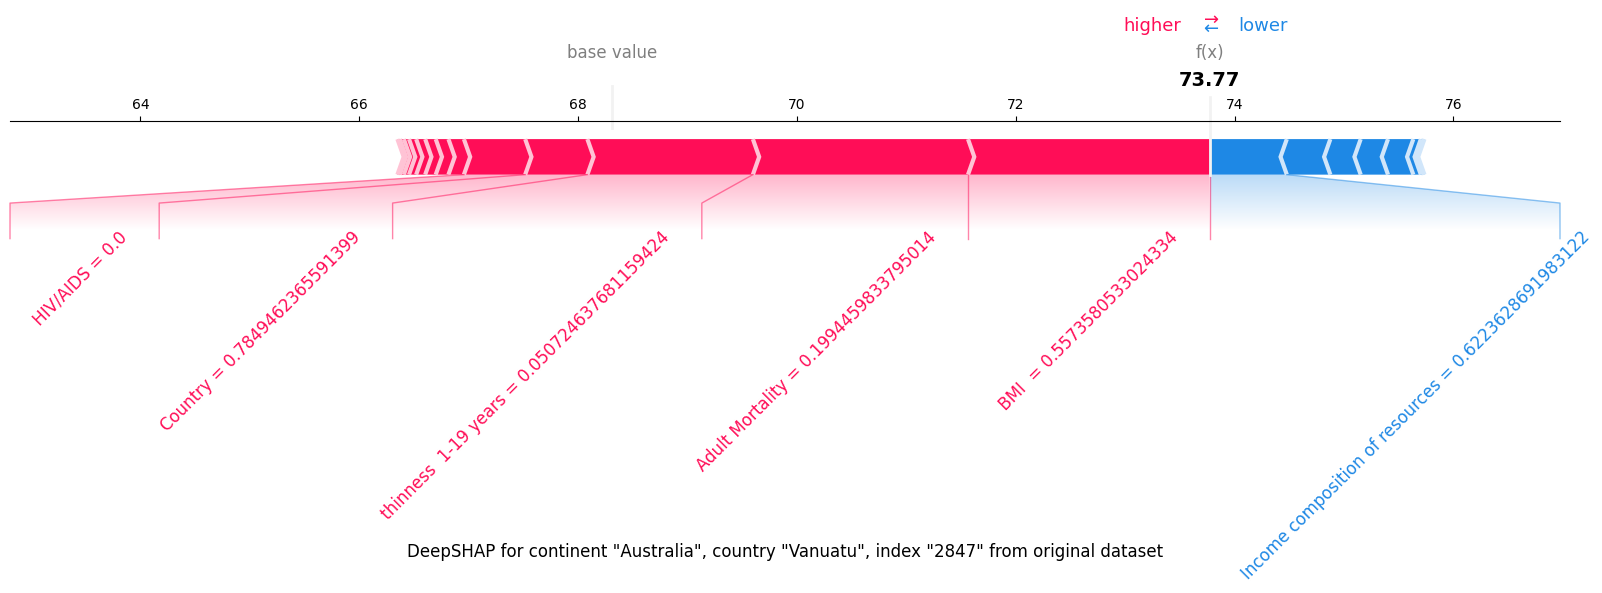

32657/32657 [==============================] - 139s 4ms/step


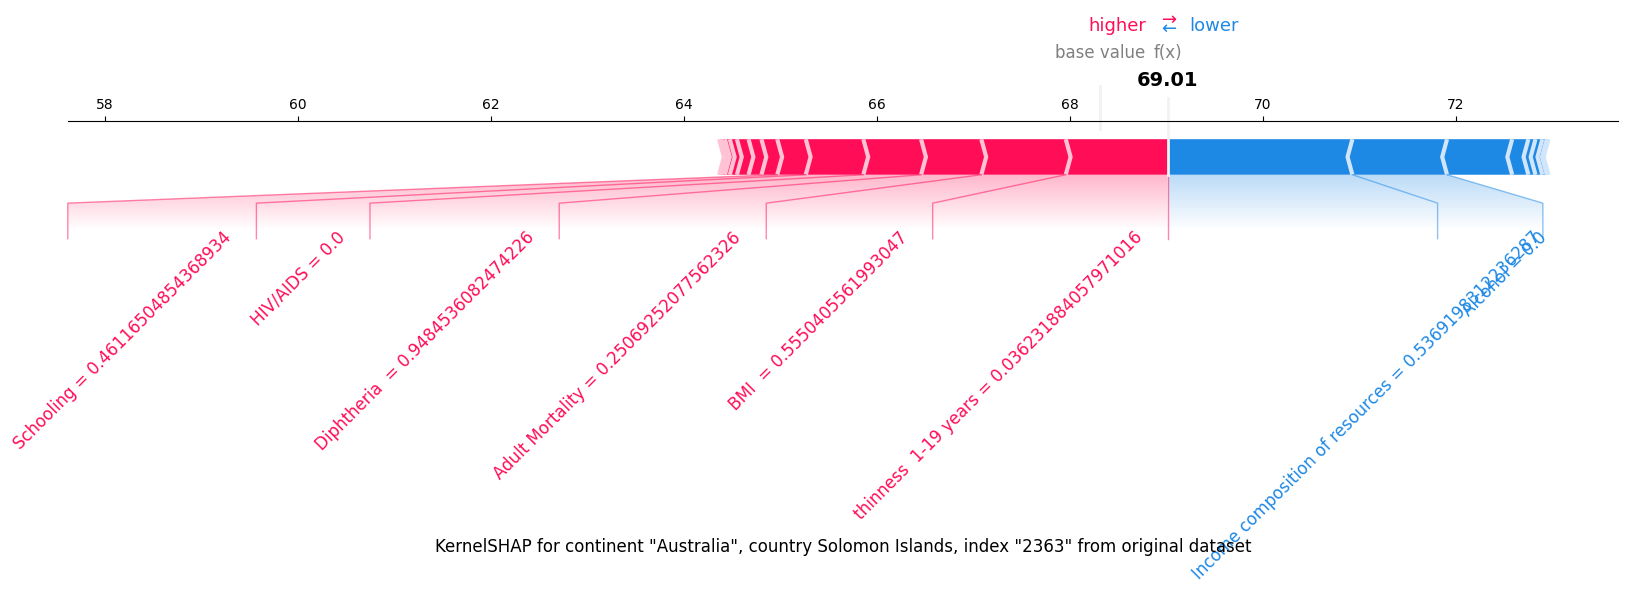

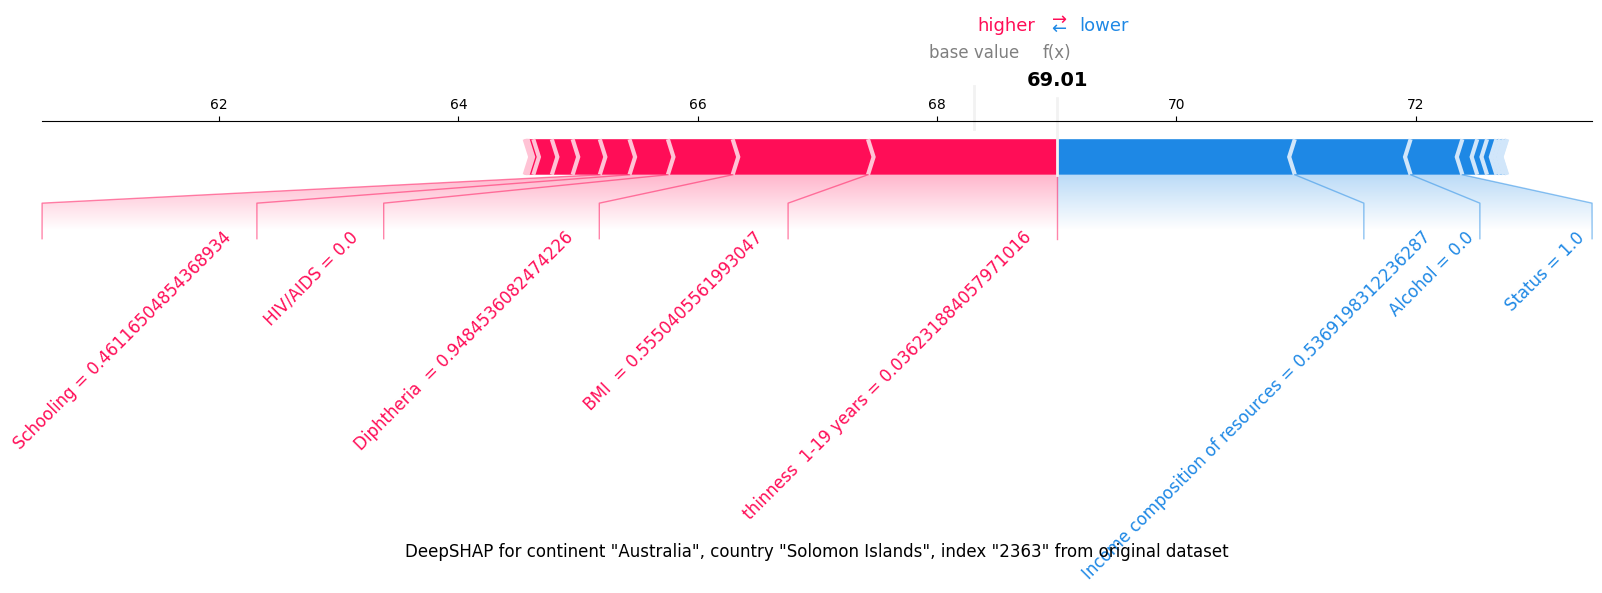

32657/32657 [==============================] - 142s 4ms/step


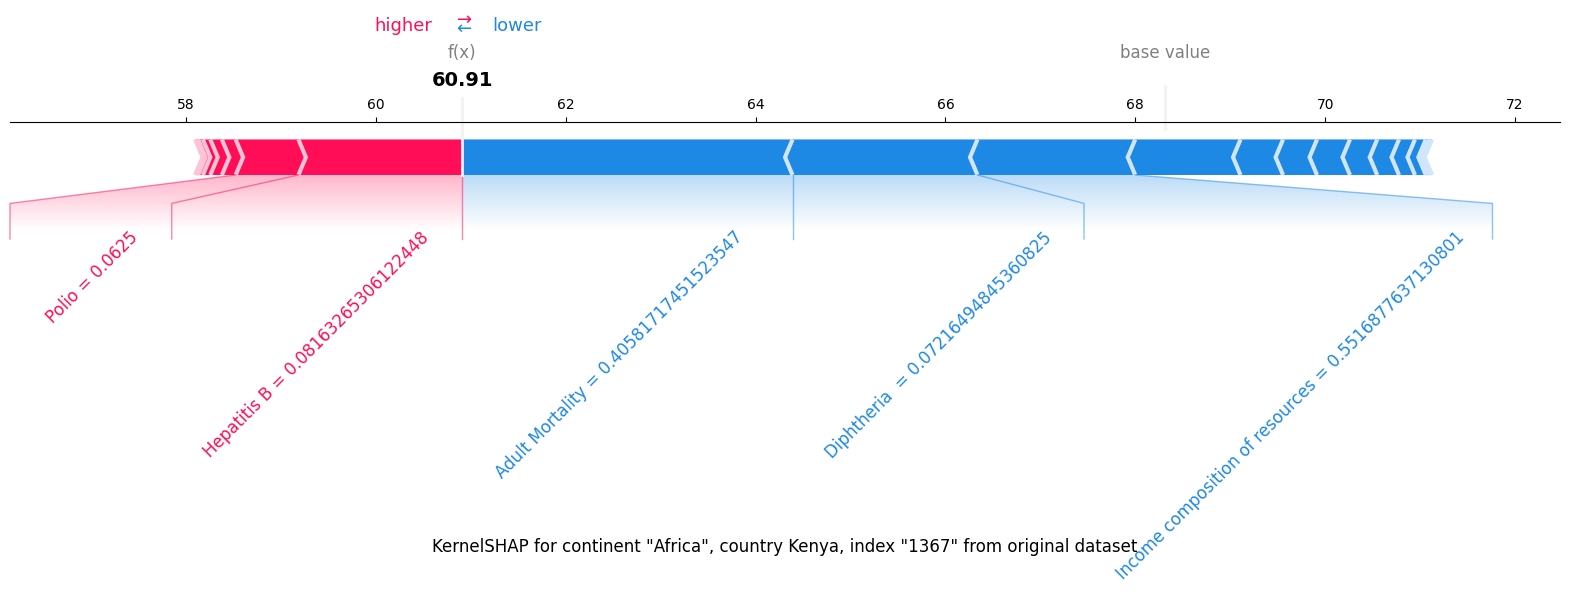

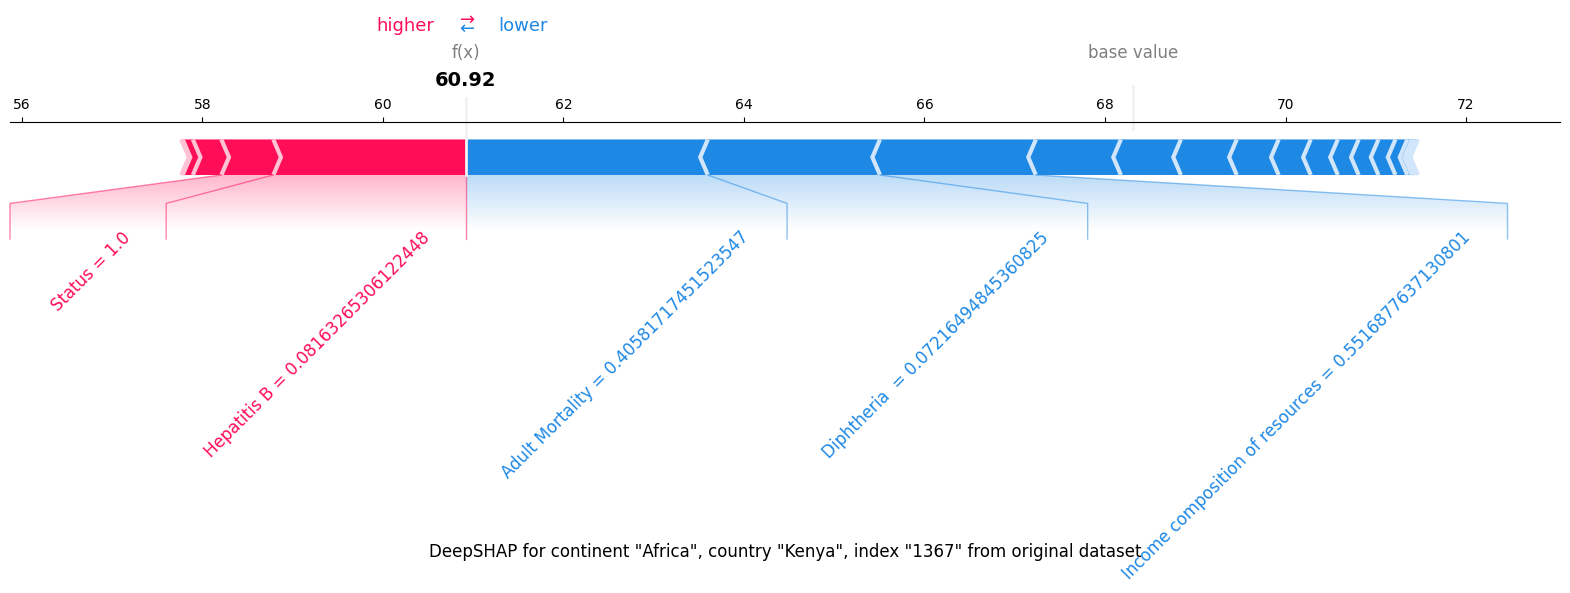

32657/32657 [==============================] - 135s 4ms/step


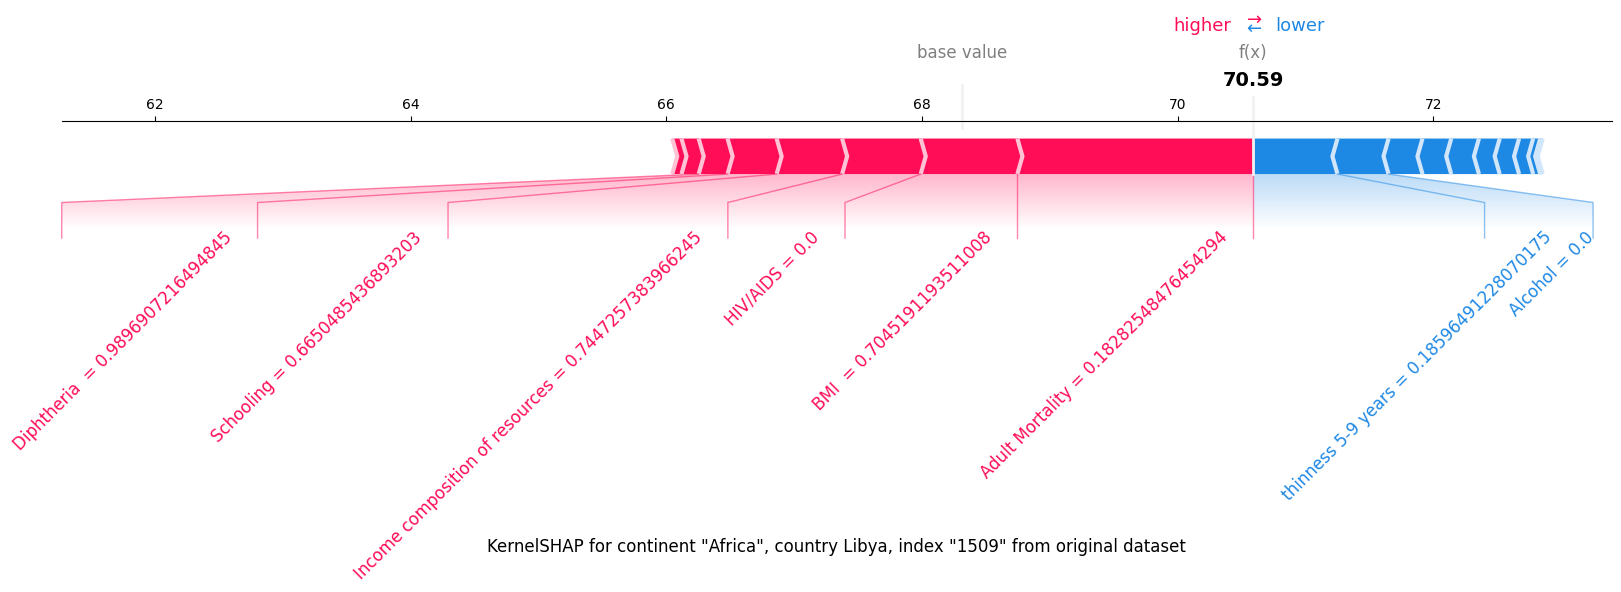

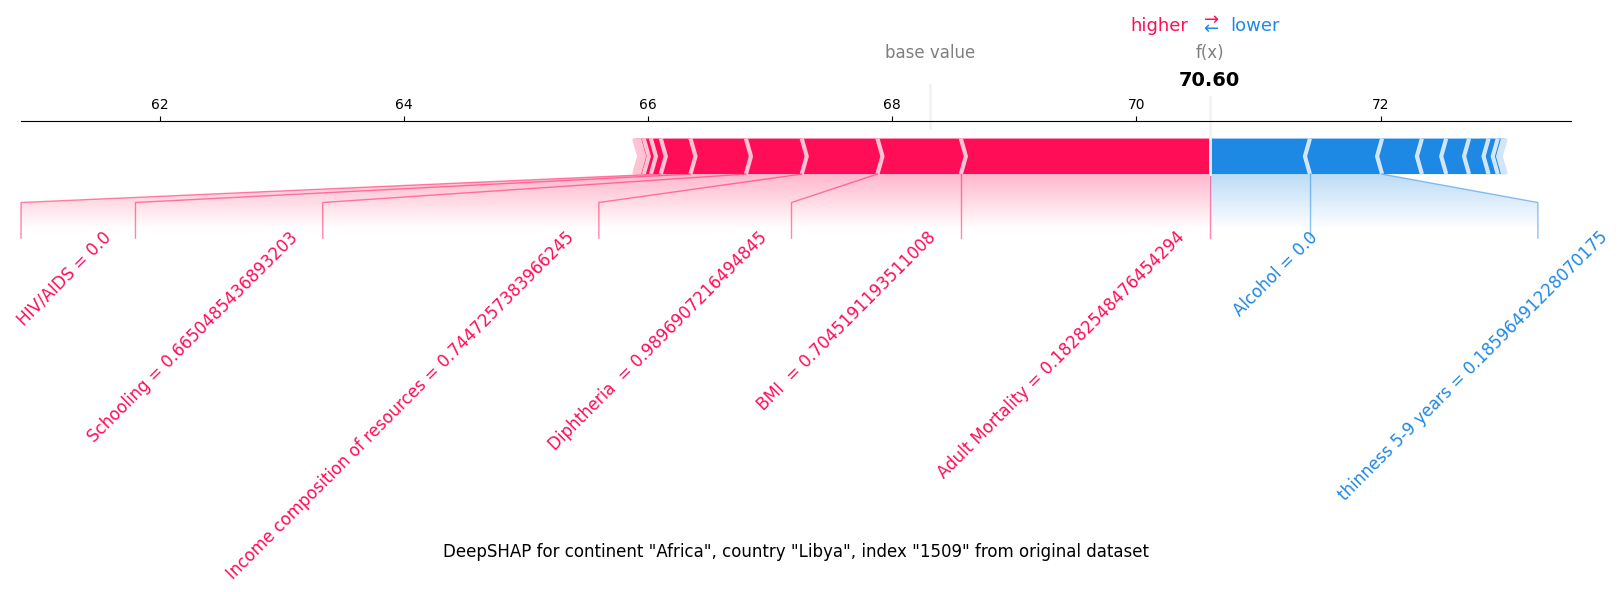

32657/32657 [==============================] - 139s 4ms/step


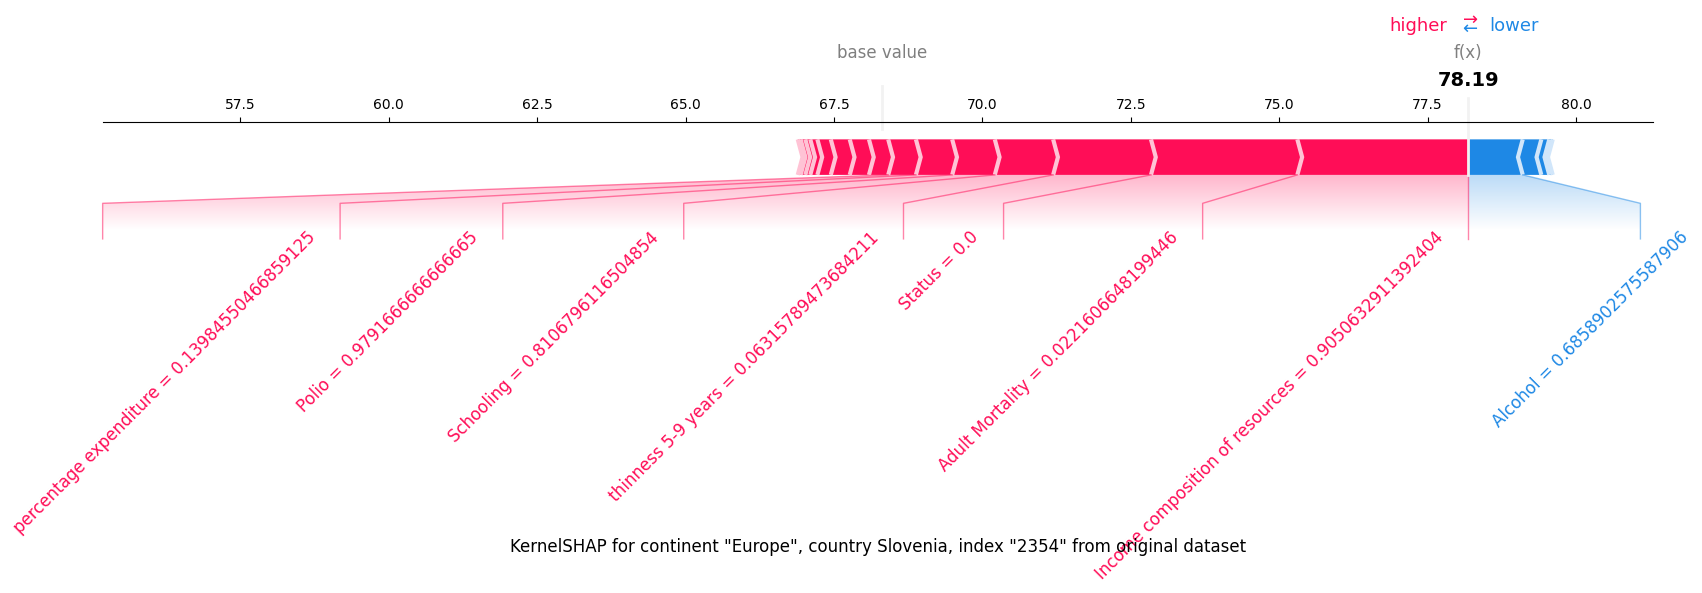

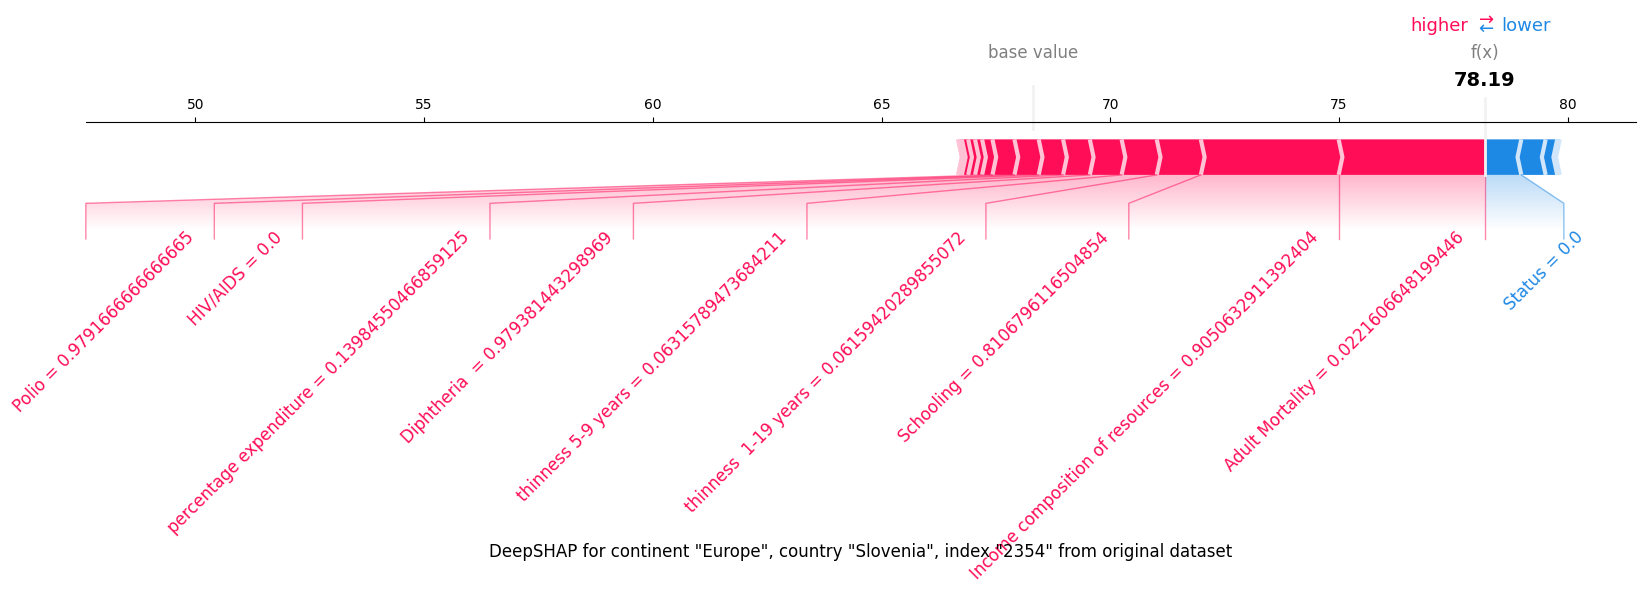

32657/32657 [==============================] - 128s 4ms/step


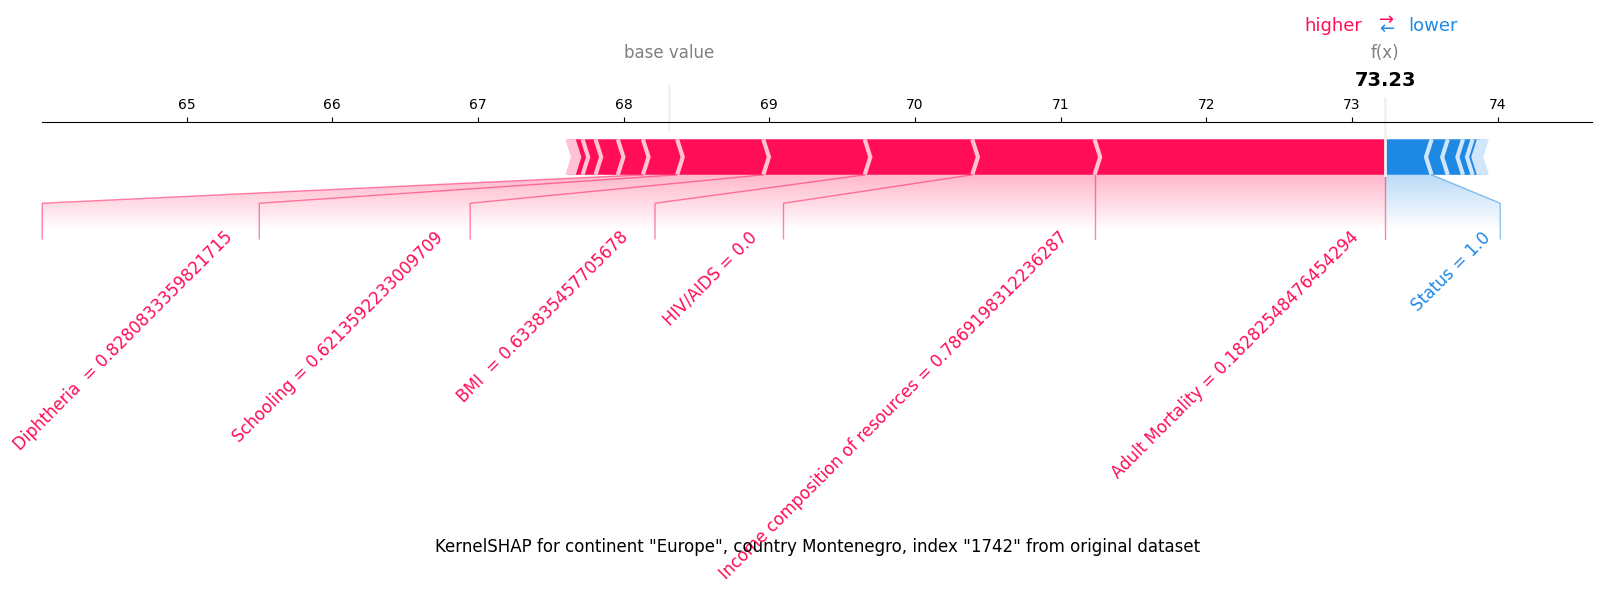

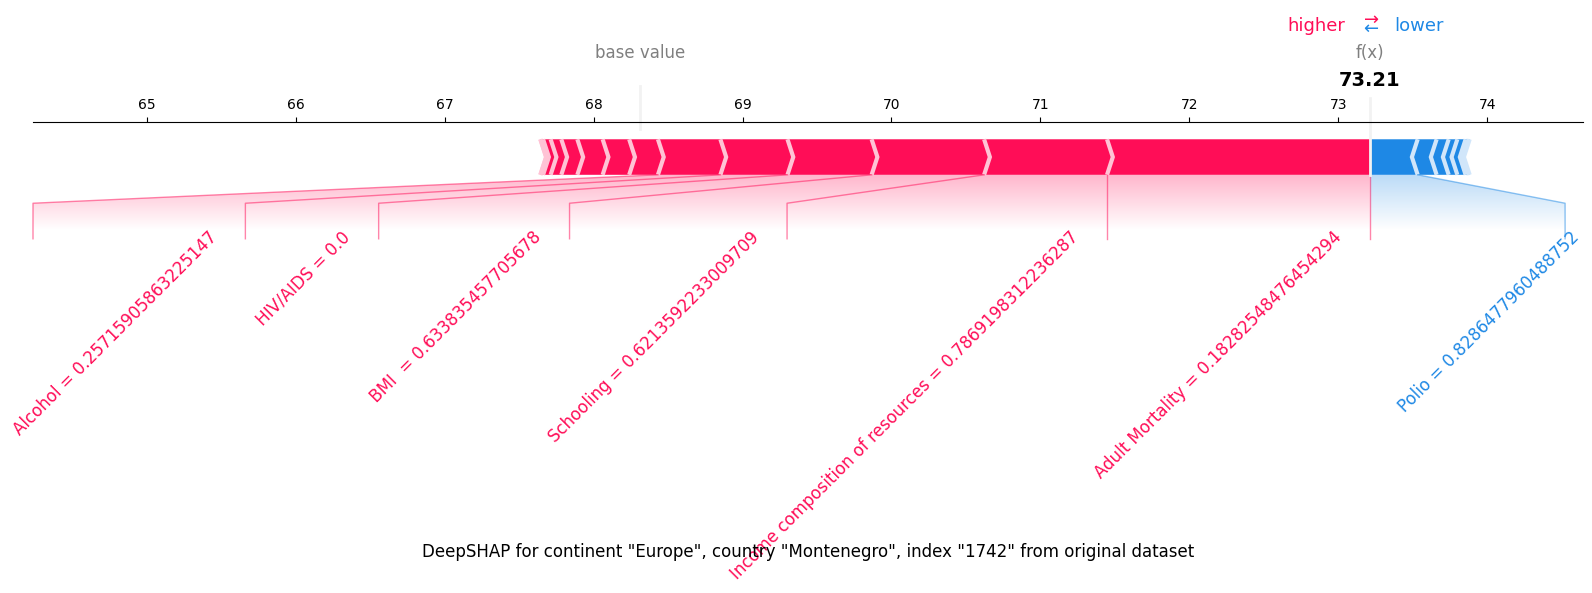

In [37]:
# we forgot to delete this feature from "x":
x.drop('Continent', inplace=True, axis=1)

for continent in continents_indices_for_x_test.keys():
    counter = 0
    #print(continent)

    for index in continents_indices_for_x_test[continent]:
        country = df.loc[continents_indices_for_df[continent][counter], 'Country']
        index_df = continents_indices_for_df[continent][counter]
        
        #print(country)
        #print(index)
        # first for kernelshap method:

        # we just perform on only one single datapoint from test-set:
        shap_values_kernel_shap = explainer_kernel_shap.shap_values(x_test[index, :])

        # we just plot and show on only one single datapoint from test-set:
        # inspired by https://www.youtube.com/watch?v=Z2kfLs2Dwqw&ab_channel=bsaldivar%3ADatascience
        shap.force_plot(explainer_kernel_shap.expected_value, shap_values_kernel_shap[0], x_test[index, :],
                        matplotlib=True, show=False, feature_names=x.columns, text_rotation=45)

        plt.title(f'KernelSHAP for continent "{continent}", country {country}, index "{index_df}" from original dataset', y=-0.9)
        plt.show()

        # then, for deepshap method:

        # we just plot and show on only one single datapoint from test-set:
        # inspired by https://www.youtube.com/watch?v=Z2kfLs2Dwqw&ab_channel=bsaldivar%3ADatascience
        # np.newaxis is for add a dimension to the first, meaning, instead of having only one single array...
        # ...we want to have an array which has that single array.
        # dimesnions we have: (21,) -> dimensions we will get after np.newaxis: (1, 21)
        shap_values_deep_shap = explainer_deep_shap.shap_values(x_test[index, :][np.newaxis, ...], check_additivity=False)

        shap.force_plot(explainer_deep_shap.expected_value.numpy(), shap_values_deep_shap[0], x_test[index, :],
                        matplotlib=True, show=False, feature_names=x.columns, text_rotation=45)

        plt.title(f'DeepSHAP for continent "{continent}", country "{country}", index "{index_df}" from original dataset', y=-0.92)
        plt.show()

        counter += 1

In [35]:
model.save('my_model.h5')

In [38]:
df.iloc[769]

Country                                   Dominica
Year                                          2013
Status                                  Developing
Life expectancy                          69.224932
Adult Mortality                         164.796448
infant deaths                                    0
Alcohol                                       0.01
percentage expenditure                   11.419555
Hepatitis B                                   96.0
Measles                                          0
 BMI                                          58.4
under-five deaths                                0
Polio                                         96.0
Total expenditure                             5.58
Diphtheria                                    96.0
 HIV/AIDS                                      0.1
GDP                                      722.75665
Population                         12753375.120052
 thinness  1-19 years                          2.7
 thinness 5-9 years            

In [42]:
df.iloc[217]

Country                                   Barbados
Year                                          2006
Status                                  Developing
Life expectancy                               74.1
Adult Mortality                              115.0
infant deaths                                    0
Alcohol                                       8.39
percentage expenditure                  181.500086
Hepatitis B                                   84.0
Measles                                          0
 BMI                                          47.7
under-five deaths                                0
Polio                                         85.0
Total expenditure                             5.27
Diphtheria                                    84.0
 HIV/AIDS                                      0.1
GDP                                     15646.5591
Population                         12753375.120052
 thinness  1-19 years                          4.0
 thinness 5-9 years            

# Question 4 - (a):

In [2]:
# load the model with the weights trained on imagenet dataset:
model = MobileNetV2(weights='imagenet')
#model.summary()

# Question 4 - (b):

In [3]:
# for each part, i create a function so that when i want to try other pictures as well...
# ...i wouldn't rewrite and repeat the codes again and again and again...
# ...just like these comments i'm, shamelessly repeating. ./

def q2_part_b(model_temp, image_name, extension):
    # first read the image, resize it, and save it:
    image = Image.open(f'images/q4 images/{image_name}.{extension}')
    new_image = image.resize((224, 224))
    new_image.save(f'images/q4 images/{image_name} resized.{extension}')

    # now, we will read the image and try to have the model predict the probabilities for the image:
    # inspired by https://pythontutorials.eu/deep-learning/image-classification/

    images = np.empty((1, 224, 224, 3))
    images[0] = imread(f'images/q4 images/{image_name} resized.{extension}')

    # we have to preprocess the image so that the model wouldn't throw errors:
    images = preprocess_input(images)

    # have the model predict some labels for that image:
    predictions = model.predict(images)
    print('Shape: {}'.format(predictions.shape))

    # show the top 5 predictions:
    for name, desc, score in decode_predictions(predictions)[0]:
        print('- {} ({:.2f}%%)'.format(desc, 100 * score))

    return images

In [4]:
images = q2_part_b(model, 'Komondor-standing-in-the-park', 'jpg') # (contains Komondor)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


1/1 [==============================] - 2s 2s/step
Shape: (1, 1000)
- komondor (96.07%%)
- hay (0.26%%)
- briard (0.18%%)
- Kerry_blue_terrier (0.06%%)
- Bouvier_des_Flandres (0.06%%)


# Question 4 - (c):

In [5]:
# for each part, i create a function so that when i want to try other pictures as well...
# ...i wouldn't rewrite and repeat the codes again and again and again...
# ...just like these comments i'm, shamelessly repeating. ./

def q2_part_c(images_temp, model_temp):
    # we will create an object of the lime image explainer and then explain the model with that technique:
    # this function is inspired by the documentation itself.

    explainer = lime_image.LimeImageExplainer()
    exp_temp = explainer.explain_instance(images_temp[0], model_temp.predict, top_labels=5, hide_color=0, num_samples=1000)

    return exp_temp

In [6]:
exp = q2_part_c(images, model)

  0%|                                                                                                                   | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 276ms/step


  1%|█                                                                                                         | 10/1000 [00:00<00:31, 31.43it/s]

1/1 [==============================] - 0s 17ms/step


  3%|███▏                                                                                                      | 30/1000 [00:00<00:12, 74.70it/s]

1/1 [==============================] - 0s 17ms/step


  5%|█████▎                                                                                                    | 50/1000 [00:00<00:09, 99.98it/s]

1/1 [==============================] - 0s 17ms/step


  7%|███████▎                                                                                                 | 70/1000 [00:00<00:08, 115.09it/s]

1/1 [==============================] - 0s 17ms/step


  9%|█████████▍                                                                                               | 90/1000 [00:00<00:07, 126.01it/s]

1/1 [==============================] - 0s 17ms/step


 11%|███████████▍                                                                                            | 110/1000 [00:00<00:06, 133.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█████████████▌                                                                                          | 130/1000 [00:01<00:06, 135.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|███████████████▌                                                                                        | 150/1000 [00:01<00:06, 138.17it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█████████████████▋                                                                                      | 170/1000 [00:01<00:06, 137.86it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████████▊                                                                                    | 190/1000 [00:01<00:05, 138.62it/s]

1/1 [==============================] - 0s 20ms/step


 21%|█████████████████████▊                                                                                  | 210/1000 [00:01<00:05, 138.21it/s]

1/1 [==============================] - 0s 18ms/step


 23%|███████████████████████▉                                                                                | 230/1000 [00:01<00:05, 137.73it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██████████████████████████                                                                              | 250/1000 [00:02<00:05, 138.47it/s]

1/1 [==============================] - 0s 18ms/step


 27%|████████████████████████████                                                                            | 270/1000 [00:02<00:05, 137.41it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██████████████████████████████▏                                                                         | 290/1000 [00:02<00:05, 134.95it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████████████████████████▏                                                                       | 310/1000 [00:02<00:05, 135.44it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████████████▎                                                                     | 330/1000 [00:02<00:05, 131.32it/s]

1/1 [==============================] - 0s 18ms/step


 35%|████████████████████████████████████▍                                                                   | 350/1000 [00:02<00:04, 132.42it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████████████████████████████▍                                                                 | 370/1000 [00:02<00:04, 133.94it/s]

1/1 [==============================] - 0s 18ms/step


 39%|████████████████████████████████████████▌                                                               | 390/1000 [00:03<00:04, 132.86it/s]

1/1 [==============================] - 0s 18ms/step


 41%|██████████████████████████████████████████▋                                                             | 410/1000 [00:03<00:04, 130.54it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████████████████████████████████████████████▋                                                           | 430/1000 [00:03<00:04, 128.21it/s]

1/1 [==============================] - 0s 19ms/step


 45%|██████████████████████████████████████████████▊                                                         | 450/1000 [00:03<00:04, 126.84it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████████████████████████████████████████████████▉                                                       | 470/1000 [00:03<00:04, 127.41it/s]

1/1 [==============================] - 0s 18ms/step


 49%|██████████████████████████████████████████████████▉                                                     | 490/1000 [00:03<00:03, 129.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████████████████████████████████████████████████████                                                   | 510/1000 [00:04<00:03, 129.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|███████████████████████████████████████████████████████                                                 | 530/1000 [00:04<00:03, 127.96it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████████████████████████████████████████▏                                              | 550/1000 [00:04<00:03, 128.38it/s]

1/1 [==============================] - 0s 18ms/step


 57%|███████████████████████████████████████████████████████████▎                                            | 570/1000 [00:04<00:03, 128.83it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████████████████████████████████████████████████████████████▎                                          | 590/1000 [00:04<00:03, 128.43it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████████████████████████████████████████████▍                                        | 610/1000 [00:04<00:03, 129.76it/s]

1/1 [==============================] - 0s 17ms/step


 63%|█████████████████████████████████████████████████████████████████▌                                      | 630/1000 [00:04<00:02, 128.89it/s]

1/1 [==============================] - 0s 17ms/step


 65%|███████████████████████████████████████████████████████████████████▌                                    | 650/1000 [00:05<00:02, 129.14it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 670/1000 [00:05<00:02, 128.02it/s]

1/1 [==============================] - 0s 17ms/step


 69%|███████████████████████████████████████████████████████████████████████▊                                | 690/1000 [00:05<00:02, 127.67it/s]

1/1 [==============================] - 0s 18ms/step


 71%|█████████████████████████████████████████████████████████████████████████▍                              | 706/1000 [00:05<00:02, 134.62it/s]

1/1 [==============================] - 0s 18ms/step


 72%|██████████████████████████████████████████████████████████████████████████▉                             | 720/1000 [00:05<00:02, 119.62it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████████████████████████████████████████████████████▉                           | 740/1000 [00:05<00:02, 120.84it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████████████████████████████████████████████████████████████████████████████                         | 760/1000 [00:05<00:01, 121.47it/s]

1/1 [==============================] - 0s 17ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████                       | 780/1000 [00:06<00:01, 123.57it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████                     | 799/1000 [00:06<00:01, 137.79it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████▋                   | 814/1000 [00:06<00:01, 120.91it/s]

1/1 [==============================] - 0s 18ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████                  | 828/1000 [00:06<00:01, 125.00it/s]

1/1 [==============================] - 0s 18ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▌                | 842/1000 [00:06<00:01, 108.03it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 860/1000 [00:06<00:01, 110.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 880/1000 [00:07<00:01, 114.40it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 900/1000 [00:07<00:00, 116.97it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 915/1000 [00:07<00:00, 123.84it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 930/1000 [00:07<00:00, 115.27it/s]

1/1 [==============================] - 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 950/1000 [00:07<00:00, 116.87it/s]

1/1 [==============================] - 0s 18ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 969/1000 [00:07<00:00, 132.86it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 984/1000 [00:07<00:00, 119.26it/s]

1/1 [==============================] - 0s 18ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.70it/s]


# Question 4 - (d):

In [13]:
# for each part, i create a function so that when i want to try other pictures as well...
# ...i wouldn't rewrite and repeat the codes again and again and again...
# ...just like these comments i'm, shamelessly repeating. ./

def q2_part_d(exp_temp, exp_class, weight=0.1):
    # this is a method to display and highlight super-pixels used by the black-box model to make predictions:
    # this function is inspired by https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image ...
    # ...and also https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html ...
    # ...also shout-out to https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4

    image, mask = exp_temp.get_image_and_mask(exp_class, positive_only=True, num_features=6, 
                                              hide_rest=False, min_weight=weight)

    # now, we will plot and show the boundaries on the image:
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


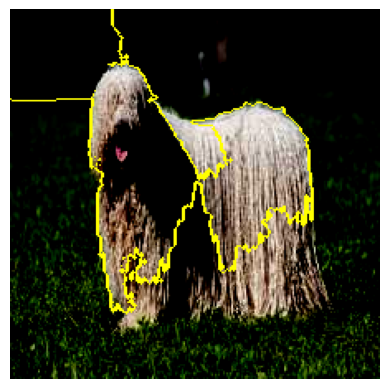

In [14]:
q2_part_d(exp, exp.top_labels[0])

# Question 4 - (e):

In [15]:
# for each part, i create a function so that when i want to try other pictures as well...
# ...i wouldn't rewrite and repeat the codes again and again and again...
# ...just like these comments i'm, shamelessly repeating. ./

def q2_part_e(exp_temp):
    # this function is inspired by https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

    # the parameters are set in a way so that we can produce the resulting images in a correct way...
    # ...especially "positive_only" and "hide_rest" features.
    image, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=6, hide_rest=False)

    # now we will plot and show:
    plt.imshow(mark_boundaries(image / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()

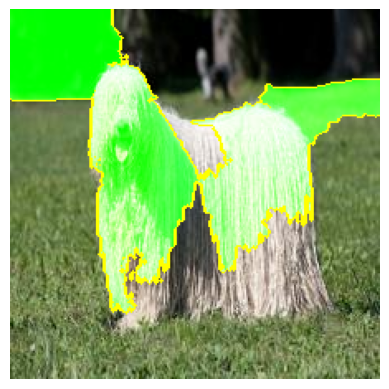

In [16]:
q2_part_e(exp)

# Question 4 - (f):

In [17]:
# for each part, i create a function so that when i want to try other pictures as well...
# ...i wouldn't rewrite and repeat the codes again and again and again...
# ...just like these comments i'm, shamelessly repeating. ./

def q2_part_f(exp_temp):
    # this function is inspired by https://medium.com/swlh/immediately-understand-lime-for-ml-model-explanation-part-2-35e4fe9c8264

    # select the same class explained on the figures above:
    index =  exp_temp.top_labels[0]

    # map each explanation weight to the corresponding superpixel:
    dict_heatmap = dict(exp_temp.local_exp[index])
    heatmap = np.vectorize(dict_heatmap.get)(exp_temp.segments)

    # now we will plot and show:
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.show()

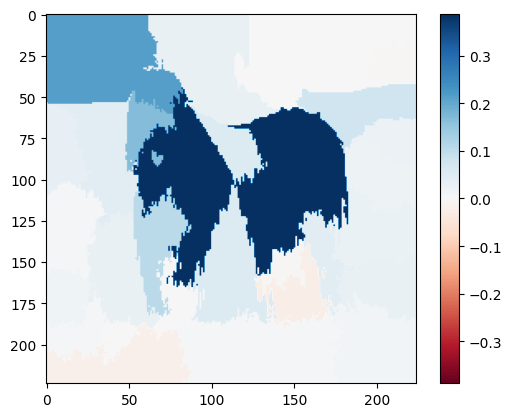

In [18]:
q2_part_f(exp)

# Question 4 - (g):

now, we will try all those parts for two other images... we will use the functions we created above:

Part (b):
1/1 [==============================] - 0s 17ms/step
Shape: (1, 1000)
- Siamese_cat (52.08%%)
- Arctic_fox (20.36%%)
- Persian_cat (1.82%%)
- keeshond (0.91%%)
- pug (0.81%%)

Part (c):


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  0%|                                                                                                                   | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|█                                                                                                         | 10/1000 [00:00<00:30, 32.75it/s]

1/1 [==============================] - 0s 19ms/step


  3%|███▏                                                                                                      | 30/1000 [00:00<00:12, 77.63it/s]

1/1 [==============================] - 0s 18ms/step


  5%|█████▎                                                                                                   | 50/1000 [00:00<00:09, 101.88it/s]

1/1 [==============================] - 0s 18ms/step


  7%|███████▎                                                                                                 | 70/1000 [00:00<00:08, 115.31it/s]

1/1 [==============================] - 0s 18ms/step


  9%|█████████▍                                                                                               | 90/1000 [00:00<00:07, 123.39it/s]

1/1 [==============================] - 0s 16ms/step


 11%|███████████▍                                                                                            | 110/1000 [00:01<00:06, 130.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█████████████▌                                                                                          | 130/1000 [00:01<00:06, 134.44it/s]

1/1 [==============================] - 0s 18ms/step


 15%|███████████████▌                                                                                        | 150/1000 [00:01<00:06, 137.74it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█████████████████▋                                                                                      | 170/1000 [00:01<00:05, 140.95it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████████████████▊                                                                                    | 190/1000 [00:01<00:05, 137.85it/s]

1/1 [==============================] - 0s 17ms/step


 21%|█████████████████████▊                                                                                  | 210/1000 [00:01<00:05, 140.21it/s]

1/1 [==============================] - 0s 18ms/step


 23%|███████████████████████▉                                                                                | 230/1000 [00:01<00:05, 142.16it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██████████████████████████                                                                              | 250/1000 [00:01<00:05, 143.19it/s]

1/1 [==============================] - 0s 18ms/step


 27%|████████████████████████████                                                                            | 270/1000 [00:02<00:05, 142.24it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██████████████████████████████▏                                                                         | 290/1000 [00:02<00:05, 137.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████████████████████████▏                                                                       | 310/1000 [00:02<00:05, 136.21it/s]

1/1 [==============================] - 0s 19ms/step


 33%|██████████████████████████████████▎                                                                     | 330/1000 [00:02<00:04, 135.36it/s]

1/1 [==============================] - 0s 18ms/step


 35%|████████████████████████████████████▍                                                                   | 350/1000 [00:02<00:04, 135.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████████████████████████████▍                                                                 | 370/1000 [00:02<00:04, 134.81it/s]

1/1 [==============================] - 0s 18ms/step


 39%|████████████████████████████████████████▌                                                               | 390/1000 [00:03<00:04, 131.45it/s]

1/1 [==============================] - 0s 18ms/step


 41%|██████████████████████████████████████████▋                                                             | 410/1000 [00:03<00:04, 131.54it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████████████████████████████████████████████▋                                                           | 430/1000 [00:03<00:04, 131.22it/s]

1/1 [==============================] - 0s 17ms/step


 45%|██████████████████████████████████████████████▊                                                         | 450/1000 [00:03<00:04, 131.42it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████████████████████████████████████████████████▉                                                       | 470/1000 [00:03<00:04, 130.67it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████████████████▋                                                     | 487/1000 [00:03<00:03, 138.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████████████████████████████████████████████████████▏                                                   | 502/1000 [00:03<00:03, 127.56it/s]

1/1 [==============================] - 0s 18ms/step


 52%|██████████████████████████████████████████████████████                                                  | 520/1000 [00:04<00:03, 122.50it/s]

1/1 [==============================] - 0s 17ms/step


 54%|████████████████████████████████████████████████████████▏                                               | 540/1000 [00:04<00:03, 123.22it/s]

1/1 [==============================] - 0s 18ms/step


 56%|██████████████████████████████████████████████████████████▏                                             | 560/1000 [00:04<00:03, 123.49it/s]

1/1 [==============================] - 0s 17ms/step


 58%|████████████████████████████████████████████████████████████▏                                           | 579/1000 [00:04<00:03, 137.93it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████████████████████████████████████████████████████████████▊                                          | 594/1000 [00:04<00:03, 122.03it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████████████████████████████████████████████▍                                        | 610/1000 [00:04<00:03, 114.39it/s]

1/1 [==============================] - 0s 18ms/step


 63%|█████████████████████████████████████████████████████████████████▌                                      | 630/1000 [00:04<00:03, 116.38it/s]

1/1 [==============================] - 0s 17ms/step


 65%|███████████████████████████████████████████████████████████████████▌                                    | 650/1000 [00:05<00:03, 115.53it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████████████████████████████████████████████████▌                                  | 669/1000 [00:05<00:02, 130.91it/s]

1/1 [==============================] - 0s 17ms/step


 68%|███████████████████████████████████████████████████████████████████████                                 | 683/1000 [00:05<00:02, 116.16it/s]

1/1 [==============================] - 0s 17ms/step


 70%|████████████████████████████████████████████████████████████████████████▊                               | 700/1000 [00:05<00:02, 113.25it/s]

1/1 [==============================] - 0s 17ms/step


 71%|██████████████████████████████████████████████████████████████████████████                              | 712/1000 [00:05<00:02, 111.91it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 730/1000 [00:05<00:02, 111.05it/s]

1/1 [==============================] - 0s 19ms/step


 75%|██████████████████████████████████████████████████████████████████████████████                          | 750/1000 [00:06<00:02, 113.49it/s]

1/1 [==============================] - 0s 18ms/step


 77%|████████████████████████████████████████████████████████████████████████████████                        | 770/1000 [00:06<00:02, 112.62it/s]

1/1 [==============================] - 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 788/1000 [00:06<00:01, 126.66it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████▍                    | 802/1000 [00:06<00:01, 113.02it/s]

1/1 [==============================] - 0s 17ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 820/1000 [00:06<00:01, 112.06it/s]

1/1 [==============================] - 0s 20ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 839/1000 [00:06<00:01, 128.75it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▋               | 853/1000 [00:06<00:01, 112.70it/s]

1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 870/1000 [00:07<00:01, 105.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 889/1000 [00:07<00:00, 123.68it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉          | 903/1000 [00:07<00:00, 111.68it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 920/1000 [00:07<00:00, 108.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 938/1000 [00:07<00:00, 124.34it/s]

1/1 [==============================] - 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 952/1000 [00:07<00:00, 109.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 968/1000 [00:07<00:00, 120.32it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/1000 [00:08<00:00, 106.69it/s]

1/1 [==============================] - 0s 18ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [00:08<00:00, 112.00it/s]

1/1 [==============================] - 0s 18ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.59it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Part (d):


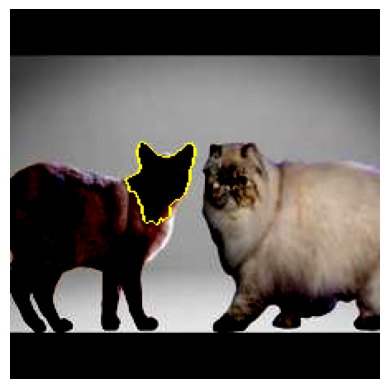


Part (e):


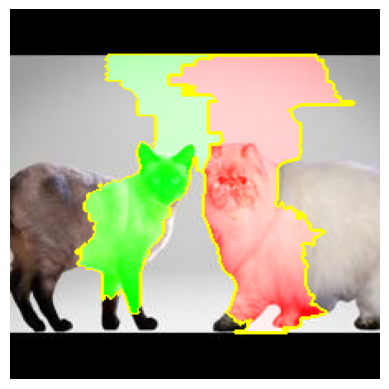


Part (f):


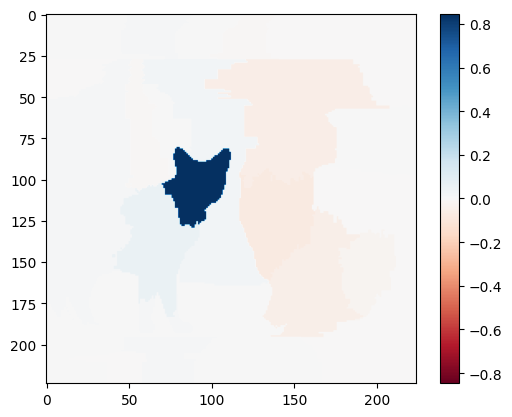

In [20]:
# image #2: (Siamese cat and Persian cat)

print('Part (b):')
images = q2_part_b(model, 'hqdefault', 'jpg')

print('\nPart (c):')
exp = q2_part_c(images, model)

print('\nPart (d):')
q2_part_d(exp, exp.top_labels[0])

print('\nPart (e):')
q2_part_e(exp)

print('\nPart (f):')
q2_part_f(exp)

Part (b):
1/1 [==============================] - 0s 16ms/step
Shape: (1, 1000)
- French_bulldog (23.75%%)
- Persian_cat (10.53%%)
- Brabancon_griffon (8.89%%)
- chow (1.53%%)
- Pekinese (1.37%%)

Part (c):


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  0%|                                                                                                                   | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|█                                                                                                         | 10/1000 [00:00<00:11, 89.58it/s]

1/1 [==============================] - 0s 18ms/step


  2%|██                                                                                                        | 20/1000 [00:00<00:10, 89.96it/s]

1/1 [==============================] - 0s 18ms/step


  3%|███▏                                                                                                      | 30/1000 [00:00<00:11, 87.59it/s]

1/1 [==============================] - 0s 19ms/step


  4%|████▋                                                                                                    | 45/1000 [00:00<00:08, 109.88it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██████▎                                                                                                  | 60/1000 [00:00<00:09, 103.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|████████▎                                                                                                | 79/1000 [00:00<00:07, 128.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|█████████▊                                                                                               | 93/1000 [00:00<00:08, 108.73it/s]

1/1 [==============================] - 0s 18ms/step


 11%|███████████▍                                                                                            | 110/1000 [00:01<00:08, 106.75it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█████████████                                                                                           | 125/1000 [00:01<00:07, 116.71it/s]

1/1 [==============================] - 0s 18ms/step


 14%|██████████████▌                                                                                         | 140/1000 [00:01<00:08, 107.25it/s]

1/1 [==============================] - 0s 18ms/step


 16%|████████████████▍                                                                                       | 158/1000 [00:01<00:06, 123.94it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█████████████████▉                                                                                      | 172/1000 [00:01<00:07, 108.86it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████████████████▏                                                                                    | 184/1000 [00:01<00:07, 110.68it/s]

1/1 [==============================] - 0s 18ms/step


 20%|████████████████████▍                                                                                   | 197/1000 [00:01<00:06, 115.49it/s]

1/1 [==============================] - 0s 19ms/step


 21%|█████████████████████▊                                                                                  | 210/1000 [00:01<00:07, 103.23it/s]

1/1 [==============================] - 0s 18ms/step


 23%|███████████████████████▌                                                                                | 226/1000 [00:02<00:06, 116.76it/s]

1/1 [==============================] - 0s 18ms/step


 24%|████████████████████████▊                                                                               | 239/1000 [00:02<00:06, 119.83it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██████████████████████████▏                                                                             | 252/1000 [00:02<00:07, 102.32it/s]

1/1 [==============================] - 0s 18ms/step


 27%|███████████████████████████▋                                                                            | 266/1000 [00:02<00:06, 111.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|█████████████████████████████▍                                                                           | 280/1000 [00:02<00:07, 99.00it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██████████████████████████████▋                                                                         | 295/1000 [00:02<00:06, 110.80it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████████████████████████▏                                                                       | 310/1000 [00:02<00:06, 101.75it/s]

1/1 [==============================] - 0s 18ms/step


 33%|█████████████████████████████████▉                                                                      | 326/1000 [00:02<00:05, 115.17it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███████████████████████████████████▎                                                                    | 340/1000 [00:03<00:06, 104.92it/s]

1/1 [==============================] - 0s 18ms/step


 36%|████████████████████████████████████▉                                                                   | 355/1000 [00:03<00:05, 115.47it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████████████████████████████▍                                                                 | 370/1000 [00:03<00:05, 107.35it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███████████████████████████████████████▊                                                                | 383/1000 [00:03<00:05, 112.42it/s]

1/1 [==============================] - 0s 18ms/step


 40%|█████████████████████████████████████████▌                                                              | 400/1000 [00:03<00:05, 109.38it/s]

1/1 [==============================] - 0s 16ms/step


 42%|███████████████████████████████████████████▎                                                            | 417/1000 [00:03<00:04, 123.75it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████████████████████████████████████████████▊                                                           | 431/1000 [00:03<00:05, 111.15it/s]

1/1 [==============================] - 0s 17ms/step


 45%|██████████████████████████████████████████████▍                                                         | 447/1000 [00:04<00:04, 122.64it/s]

1/1 [==============================] - 0s 18ms/step


 46%|███████████████████████████████████████████████▉                                                        | 461/1000 [00:04<00:04, 109.84it/s]

1/1 [==============================] - 0s 17ms/step


 48%|█████████████████████████████████████████████████▊                                                      | 479/1000 [00:04<00:04, 126.54it/s]

1/1 [==============================] - 0s 18ms/step


 49%|███████████████████████████████████████████████████▎                                                    | 493/1000 [00:04<00:04, 110.37it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████████████████████████████████████████████████████                                                   | 510/1000 [00:04<00:04, 108.74it/s]

1/1 [==============================] - 0s 17ms/step


 53%|██████████████████████████████████████████████████████▋                                                 | 526/1000 [00:04<00:03, 119.93it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████████████████████████████████████████▏                                               | 540/1000 [00:04<00:04, 107.09it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████████████████████████████████████████▌                                              | 554/1000 [00:04<00:03, 114.43it/s]

1/1 [==============================] - 0s 17ms/step


 57%|███████████████████████████████████████████████████████████▏                                            | 569/1000 [00:05<00:03, 122.73it/s]

1/1 [==============================] - 0s 17ms/step


 58%|████████████████████████████████████████████████████████████▌                                           | 582/1000 [00:05<00:03, 105.37it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████████████████████████████████████████████████████████████▏                                         | 598/1000 [00:05<00:03, 118.28it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████████████████████████████████████████████▌                                        | 611/1000 [00:05<00:03, 104.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|█████████████████████████████████████████████████████████████████▎                                      | 628/1000 [00:05<00:03, 119.24it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████████████████████████████████████████████████████████████████▋                                     | 641/1000 [00:05<00:03, 104.00it/s]

1/1 [==============================] - 0s 17ms/step


 66%|████████████████████████████████████████████████████████████████████                                    | 655/1000 [00:05<00:03, 112.28it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 670/1000 [00:06<00:03, 100.62it/s]

1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████████████████████████████████████████████████▏                                | 684/1000 [00:06<00:02, 109.36it/s]

1/1 [==============================] - 0s 16ms/step


 70%|████████████████████████████████████████████████████████████████████████▊                               | 700/1000 [00:06<00:02, 103.94it/s]

1/1 [==============================] - 0s 17ms/step


 72%|██████████████████████████████████████████████████████████████████████████▎                             | 715/1000 [00:06<00:02, 114.30it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 728/1000 [00:06<00:02, 118.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|█████████████████████████████████████████████████████████████████████████████                           | 741/1000 [00:06<00:02, 102.04it/s]

1/1 [==============================] - 0s 18ms/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                         | 754/1000 [00:06<00:02, 108.44it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████████████████████████████████████████████████████████████████████████████▊                        | 767/1000 [00:06<00:02, 113.49it/s]

1/1 [==============================] - 0s 18ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████                       | 779/1000 [00:07<00:01, 113.04it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 791/1000 [00:07<00:02, 97.05it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 802/1000 [00:07<00:02, 97.50it/s]

1/1 [==============================] - 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 813/1000 [00:07<00:01, 99.20it/s]

1/1 [==============================] - 0s 17ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████                  | 827/1000 [00:07<00:01, 109.66it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 840/1000 [00:07<00:01, 95.01it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 851/1000 [00:07<00:01, 97.75it/s]

1/1 [==============================] - 0s 18ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 862/1000 [00:07<00:01, 96.68it/s]

1/1 [==============================] - 0s 19ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▊             | 873/1000 [00:08<00:01, 100.08it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 890/1000 [00:08<00:01, 101.84it/s]

1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▎         | 907/1000 [00:08<00:00, 118.54it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 920/1000 [00:08<00:00, 102.97it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████       | 933/1000 [00:08<00:00, 109.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▋     | 949/1000 [00:08<00:00, 121.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████    | 962/1000 [00:08<00:00, 104.61it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 979/1000 [00:08<00:00, 119.95it/s]

1/1 [==============================] - 0s 18ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏| 992/1000 [00:09<00:00, 100.58it/s]

1/1 [==============================] - 0s 17ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Part (d):


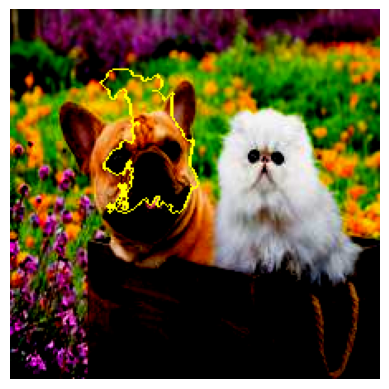


Part (e):


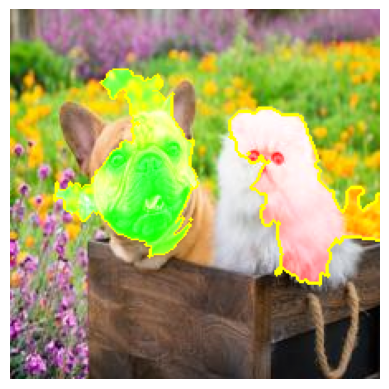


Part (f):


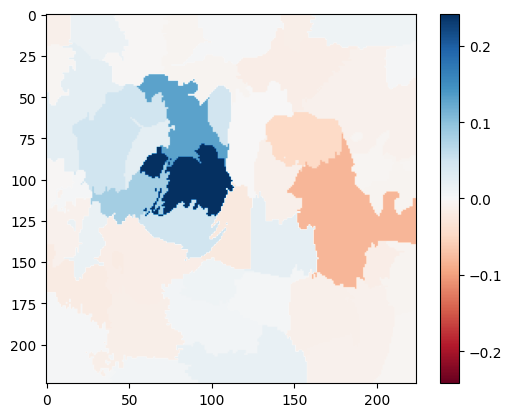

In [21]:
# image #3: (French bulldog and Persian cat)

print('Part (b):')
images = q2_part_b(model, 'dok-01-bk1108-01p', 'jpg')

print('\nPart (c):')
exp = q2_part_c(images, model)

print('\nPart (d):')
q2_part_d(exp, exp.top_labels[0])

print('\nPart (e):')
q2_part_e(exp)

print('\nPart (f):')
q2_part_f(exp)